In [2]:
from IPython.display import display, Image, clear_output

# Comprehensive Lipidome Automation Workflow (CLAW)

Welcome to CLAW, a tool designed to facilitate and optimize the processing of lipidomic MRM data. This Jupyter notebook encapsulates a suite of tools that streamline the various stages of lipidomics data analysis.

Our toolset enables users to efficiently process MRM data files in the mzML format. Upload a file and CLAW will parse the data into a structured Pandas dataframe. This dataframe includes critical information like sample_ID, MRM transition, and signal intensity. Furthermore, our tool aligns each MRM transition with a default or custom lipid_database for accurate and swift annotation.

Moreover, CLAW is equipped with an OzESI option, a tool to elucidate the double bond location in lipid isomers. This feature allows users to input OzESI data and pinpoint the precise location of double bonds in isomeric lipids. Users have the flexibility to select which double bond locations they want to analyze. Following this, CLAW autonomously predicts potential m/z values and cross-references these predictions with sample data, ensuring a comprehensive and meticulous analysis.

With automation at its core, CLAW eliminates the need for manual data processing, significantly reducing time expenditure. It is a robust and invaluable tool for handling large volumes of lipid MRM data, accelerating scientific discovery in the field of lipidomics.

In [3]:
#Import all the necessary python libraries
import pymzml
import csv
import os
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import json
from scipy.integrate import trapz

#Import all the necessary CLAW libraries
import create_directory
import CLAW
import matplotlib.pyplot as plt
import warnings

import re
from sklearn.mixture import GaussianMixture

# Suppress all warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Directory and File Management
For structured data management and efficient workflow, the system first ensures the presence of an output directory. If such a directory already exists you can skip this step.

In [4]:
# # Create the output directory. If it already exists you can skip this step.
# create_directory.create_project_folder()


The name of the project is defined next. This is important as the created directory will bear this name, allowing users to manage and identify their data with ease.

After the mzML files are uploaded to the designated mzML folder, the next block of code segregates these files based on their characteristics. More specifically, it filters the files and transfers them to respective folders named 'o3on' and 'o2only'.

In [5]:
name_of_project = 'FaceFats'
#After you load mzml files to mzml folder. this will filter the files and move them to o3on and o2only folders
create_directory.filter_o3mzml_files(name_of_project)

One or both of the destination directories 'Projects/FaceFats/o3on' and 'Projects/FaceFats/o2only' do not exist.


## Pre-Parsing Setup
The following block of code takes the preset variable values and uses them to parse the mzML files. The parsed data, including the sample ID, MRM transitions, and intensities, is stored in a pandas dataframe for easy manipulation and analysis.

The function CLAW.parsing_mzml_to_df takes several arguments. data_base_name_location is the location of the lipid database that contains information on lipid classes, fatty acid chains, and their corresponding MRM transitions. Project_Folder_data is the location of the mzML files for the samples to be analyzed. tolerance defines the acceptable range of deviation for the MRM transitions when matching them with the lipid database. The argument remove_std is a boolean that, when True, indicates to remove the MRM transitions that correspond to standards (internal or external) present in the samples.

The function outputs a pandas dataframe (df) where each row corresponds to an MRM transition detected in a sample, and columns include the sample ID, MRM transition, and intensity of the transition, among other values.

In [6]:
# Set default values
data_base_name_location = 'lipid_database/Lipid_Database.xlsx'
Project = './Projects/'
Project_Name = 'FaceFats'
Project_Folder_data = Project + Project_Name + '/mzml_liver_OzON/'
Project_results = Project + Project_Name + '/results/'
file_name_to_save = 'Liver_OzON'
tolerance = 0.3
remove_std = True
save_data = True

# Call pre_parsing_setup to initialize the variables
data_base_name_location, Project_Folder_data, Project_results, file_name_to_save, tolerance, remove_std, save_data = CLAW.pre_parsing_setup(data_base_name_location,
 Project, 
 Project_Name, 
 Project_Folder_data,
 Project_results, 
 file_name_to_save, 
 tolerance, 
 remove_std,
 save_data)


data_base_name_location: lipid_database/Lipid_Database.xlsx
Project: ./Projects/
Project_Name: FaceFats
Project_Folder_data: ./Projects/FaceFats/mzml_liver_OzON/
Project_results: ./Projects/FaceFats/results/
file_name_to_save: Liver_OzON
tolerance: 0.3
remove_std: True
save_data: True


Define the master dataframes where the data will be stored during the parsing step.

In [7]:
time_and_intensity_df, master_df, OzESI_time_df = CLAW.create_analysis_dataframes()

## CLAW.full_parse()
In this code, the `CLAW.full_parse()` function is used to analyze the MRM data. It takes several parameters like the location of the lipid database, paths to the data and results folders, the name of the result files, and the tolerance for MRM transitions matching. The function returns two dataframes: `df_matched` that contains information about each detected lipid species and their corresponding MRM transitions, and `OzESI_time_df` which captures data related to OzESI-MS scans, including potential double bond locations of lipids. If `remove_std` is `True`, it removes MRM transitions related to standards from the dataframe, and if `save_data` is `True`, the dataframe is saved as a .csv file in the specified results folder.

In [8]:
# Use the initialized variables as arguments to full_parse
df_MRM, df_OzESI = CLAW.full_parse(data_base_name_location, 
                                               Project_Folder_data, 
                                               Project_results, 
                                               file_name_to_save, 
                                               tolerance, 
                                               remove_std=True, 
                                               save_data=False,
                                               batch_processing=True,
                                               plot_chromatogram=False)

/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_MRM_data['Parent_Ion'] = np.round(lipid_MRM_data['Parent_Ion'], 1)
/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_MRM_data['Product_Ion'] = np.round(lipid_MRM_data['Product_Ion'], 1)
/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Finished parsing mzML file: ./Projects/FaceFats/mzml_liver_OzON/12012023_DOD73_M2_5xFAD_liver_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_liver_OzON/12012023_FAD131_M1_5xFAD_liver_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_liver_OzON/12012023_FAD131_M2_5xFAD_liver_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_liver_OzON/12012023_FAD131_M4_5xFAD_liver_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_liver_OzON/12012023_FAD173_M1_5xFAD_liver_O3on_01.mzML

Finished parsing all mzML files



In [9]:
df_MRM.head(None)

Class      Intensity                        Lipid  Parent_Ion  \
0     NaN   23873.981735                          NaN       584.4   
1     NaN   30013.202080                          NaN       612.4   
2     NaN   27567.021954                          NaN       622.5   
3     NaN   30535.462173                          NaN       624.5   
4     NaN   81457.065533                          NaN       626.5   
..    ...            ...                          ...         ...   
745   TAG  233716.696194   [TG(57:9),TG(56:2)]_FA18:1       932.9   
746   TAG   49685.523727   [TG(58:7),TG(57:0)]_FA18:1       950.9   
747   TAG   34257.062469  [TG(59:13),TG(58:6)]_FA18:1       952.8   
748   TAG   40613.842754  [TG(59:12),TG(58:5)]_FA18:1       954.8   
749   TAG   70855.765076  [TG(59:11),TG(58:4)]_FA18:1       956.9   

     Product_Ion                               Sample_ID      Transition  
0          437.3   12012023_DOD73_M2_5xFAD_liver_O3on_01  584.4 -> 437.3  
1          437.3   12012023_DOD73_M2_5xFAD_liver_O3on_01  612.4 -> 437.3  
2          503.4   12012023_DOD73_M2_5xFAD_liver_O3on_01  622.5 -> 503.4  
3          505.4   12012023_DOD73_M2_5xFAD_liver_O3on_01  624.5 -> 505.4  
4          437.3   12012023_DOD73_M2_5xFAD_liver_O3on_01  626.5 -> 437.3  
..           ...                                     ...             ...  
745        633.6  12012023_FAD173_M1_5xFAD_liver_O3on_01  932.9 -> 633.6  
746        651.6  12012023_FAD173_M1_5xFAD_liver_O3on_01  950.9 -> 651.6  
747        653.5  12012023_FAD173_M1_5xFAD_liver_O3on_01  952.8 -> 653.5  
748        655.5  12012023_FAD173_M1_5xFAD_liver_O3on_01  954.8 -> 655.5  
749        657.6  12012023_FAD173_M1_5xFAD_liver_O3on_01  956.9 -> 657.6  

[750 rows x 7 columns]

In [10]:
df_OzESI.head(None)
# df_OzESI.to_csv('FF_OzOFF_full.csv')
# df_OzESI.to_excel('FaceFatsOzdf.xlsx')

Lipid  Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0        NaN       584.4        437.3        0.044183        41.140003   
1        NaN       584.4        437.3        0.088567        41.120003   
2        NaN       584.4        437.3        0.132967        41.140003   
3        NaN       584.4        437.3        0.177367        41.060001   
4        NaN       584.4        437.3        0.221783        41.100002   
...      ...         ...          ...             ...              ...   
422241   NaN       956.9        657.6       24.779117        41.080002   
422242   NaN       956.9        657.6       24.823533        40.980003   
422243   NaN       956.9        657.6       24.867933        40.980003   
422244   NaN       956.9        657.6       24.912333        40.960003   
422245   NaN       956.9        657.6       24.956750        40.900002   

                                     Sample_ID      Transition  
0        12012023_DOD73_M2_5xFAD_liver_O3on_01  584.4 -> 437.3  
1        12012023_DOD73_M2_5xFAD_liver_O3on_01  584.4 -> 437.3  
2        12012023_DOD73_M2_5xFAD_liver_O3on_01  584.4 -> 437.3  
3        12012023_DOD73_M2_5xFAD_liver_O3on_01  584.4 -> 437.3  
4        12012023_DOD73_M2_5xFAD_liver_O3on_01  584.4 -> 437.3  
...                                        ...             ...  
422241  12012023_FAD173_M1_5xFAD_liver_O3on_01  956.9 -> 657.6  
422242  12012023_FAD173_M1_5xFAD_liver_O3on_01  956.9 -> 657.6  
422243  12012023_FAD173_M1_5xFAD_liver_O3on_01  956.9 -> 657.6  
422244  12012023_FAD173_M1_5xFAD_liver_O3on_01  956.9 -> 657.6  
422245  12012023_FAD173_M1_5xFAD_liver_O3on_01  956.9 -> 657.6  

[422246 rows x 7 columns]

The `read_mrm_list()` function is first invoked to read the MRM database from the specified file location and return it as a pandas DataFrame `mrm_database`. Subsequently, the `match_lipids_parser()` function is called to match the detected lipids from the `OzESI_time_df` DataFrame, obtained from the OzESI-MS scans, with the known lipids in the `mrm_database` based on the MRM transitions within the specified `tolerance`. The result is saved in the `df_oz_matched` DataFrame, which now contains matched lipid species from the OzESI-MS data.

In [11]:
d1 = df_OzESI.iloc[:,1:9]

# Assuming d1 is your DataFrame

# Define the retention time range as a tuple (lower_bound, upper_bound)
retention_time_range = (9.5, 21.5)  # Replace with your specific range values

# Filter the DataFrame to keep only rows where Retention_Time is within the specified range
d1a = d1[(d1['Retention_Time'] >= retention_time_range[0]) & (d1['Retention_Time'] <= retention_time_range[1])]

# # Now, filtered_d1 contains only the rows from d1 where Retention_Time is within the specified range
# filtered_d1.to_csv('filtered_d1_FF_OzON_Liver.csv')
d1a

Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
213          584.4        437.3        9.502800        41.140003   
214          584.4        437.3        9.547217        41.140003   
215          584.4        437.3        9.591617        41.000004   
216          584.4        437.3        9.636017        40.960003   
217          584.4        437.3        9.680433        41.040005   
...            ...          ...             ...              ...   
422163       956.9        657.6       21.315367        41.180004   
422164       956.9        657.6       21.359783        41.060001   
422165       956.9        657.6       21.404183        41.240002   
422166       956.9        657.6       21.448600        41.240002   
422167       956.9        657.6       21.493000        41.140003   

                                     Sample_ID      Transition  
213      12012023_DOD73_M2_5xFAD_liver_O3on_01  584.4 -> 437.3  
214      12012023_DOD73_M2_5xFAD_liver_O3on_01  584.4 -> 437.3  
215      12012023_DOD73_M2_5xFAD_liver_O3on_01  584.4 -> 437.3  
216      12012023_DOD73_M2_5xFAD_liver_O3on_01  584.4 -> 437.3  
217      12012023_DOD73_M2_5xFAD_liver_O3on_01  584.4 -> 437.3  
...                                        ...             ...  
422163  12012023_FAD173_M1_5xFAD_liver_O3on_01  956.9 -> 657.6  
422164  12012023_FAD173_M1_5xFAD_liver_O3on_01  956.9 -> 657.6  
422165  12012023_FAD173_M1_5xFAD_liver_O3on_01  956.9 -> 657.6  
422166  12012023_FAD173_M1_5xFAD_liver_O3on_01  956.9 -> 657.6  
422167  12012023_FAD173_M1_5xFAD_liver_O3on_01  956.9 -> 657.6  

[202670 rows x 6 columns]

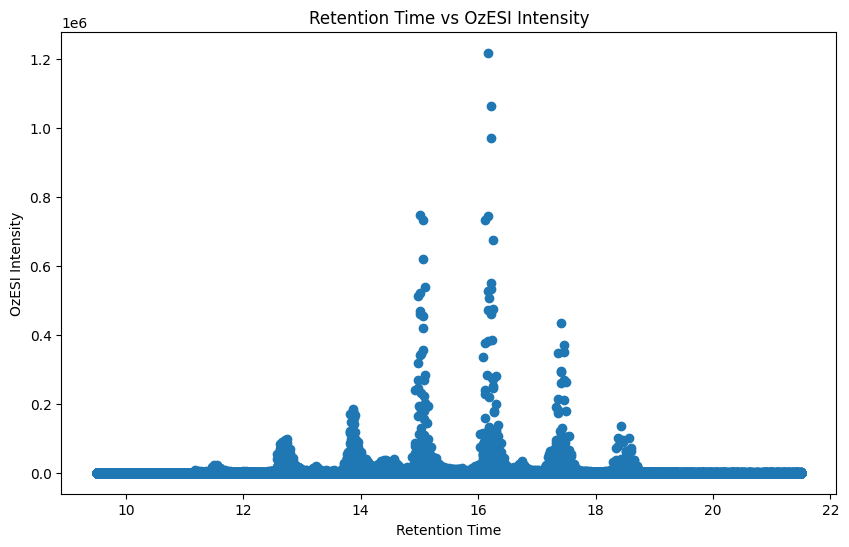

In [12]:


# Assuming clustered_data is your DataFrame with the necessary data

# Plotting the Intensity vs Retention Time
plt.figure(figsize=(10, 6))
plt.scatter(d1a['Retention_Time'], d1a['OzESI_Intensity'])

# Adding labels and title to the plot
plt.xlabel('Retention Time')
plt.ylabel('OzESI Intensity')
plt.title('Retention Time vs OzESI Intensity')

# Displaying the plot
plt.show()


Correct RTs add DB position based on correct RT

In [13]:
Correct_RT_directory = 'tools/RT/'
#MRM CORRECT RT DF
df_MRM_RT_correct = pd.read_csv(Correct_RT_directory + 'FF_MRM_CorrectRT_Liver_12dec23_v2.csv') #correct MRM RT
# df_MRM_RT_correct['Retention_Time'] = df_MRM_RT_correct['Average_Retention_Time']

# List of new column names based on db_pos_list
db_column_names = []
db_pos_list = [7, 9, 10, 12]


df_DB_aldehyde = pd.DataFrame(columns=['DB_Position','Aldehyde_Ion'])

# Loop through the range of DB_Position values to calculate the corresponding Aldehyde_Ion values
for position in range(3, 21):
    df_DB_aldehyde.loc[position, 'DB_Position'] = position
    df_DB_aldehyde.loc[position, 'Aldehyde_Ion'] = 26 + (14 * (position-3))

for number in db_pos_list:
    db_column_names.append(f'n-{number}')

# Create an empty DataFrame with initial columns
df_db_pos = pd.DataFrame(columns=['Lipid', 'Retention_Time', 'Parent_Ion','Product_Ion'])

# Append new column names to the DataFrame
for column_name in db_column_names:
    df_db_pos[column_name] = pd.NA  # Initialize the new columns with NA

# df_DB_aldehyde #aldehyde ion values


#append df_MRM_RT_correct to df_db_pos
df_db_pos = df_db_pos.append(df_MRM_RT_correct, ignore_index=True)


# Loop through the specified db_pos_list
for ozesi_position in db_pos_list:
    # Retrieve the corresponding Aldehyde_Ion value for the current DB_Position
    aldehyde_ion = df_DB_aldehyde.loc[df_DB_aldehyde["DB_Position"] == ozesi_position, "Aldehyde_Ion"].values[0]

    # Calculate and store the n-i value for the current OzESI position
    df_db_pos["n-{}".format(ozesi_position)] = df_db_pos["Parent_Ion"] - aldehyde_ion


# df_db_pos.to_csv('df_db_pos.csv')
# df_MRM_RT_correct  #correct MRM RT
#drop Average_Retention_Time column from df db pos
df_db_pos  #empty df with n-7, n-9, n-10, n-12 columns





Lipid  Retention_Time  Parent_Ion  Product_Ion  \
0             [TG(50:3)]_FA18:1           14.00       846.8        547.5   
1             [TG(52:5)]_FA16:1           12.75       870.8        599.5   
2    [TG(52:7),TG(51:0)]_FA18:1           17.06       866.8        567.5   
3             [TG(54:5)]_FA18:1           13.91       898.8        599.5   
4             [TG(54:6)]_FA18:1           12.80       896.8        597.5   
5   [TG(55:10),TG(54:3)]_FA18:1           16.26       902.8        603.5   
6   [TG(55:11),TG(54:4)]_FA16:1           15.01       900.8        629.5   
7   [TG(55:11),TG(54:4)]_FA18:1           15.10       900.8        601.5   
8    [TG(55:8),TG(54:1)]_FA18:1           18.61       906.8        607.5   
9    [TG(55:9),TG(54:2)]_FA18:1           17.50       904.8        605.5   
10  [TG(56:10),TG(55:3)]_FA18:1           16.79       916.8        617.5   
11  [TG(56:11),TG(55:4)]_FA18:1           15.68       914.8        615.5   
12            [TG(56:6)]_FA18:1           14.43       924.8        625.5   
13   [TG(56:7),TG(55:0)]_FA16:1           13.15       922.9        651.6   
14   [TG(56:7),TG(55:0)]_FA18:1           13.81       922.9        623.6   
15  [TG(57:10),TG(56:3)]_FA18:1           17.28       930.6        631.5   
16  [TG(57:11),TG(56:4)]_FA18:1           16.17       928.8        629.5   
17  [TG(57:12),TG(56:5)]_FA18:1           14.97       926.8        627.5   
18   [TG(57:9),TG(56:2)]_FA18:1           18.47       932.9        633.6   
19   [TG(58:7),TG(57:0)]_FA18:1           14.30       950.9        651.6   
20  [TG(59:11),TG(58:4)]_FA18:1           17.23       956.9        657.6   
21  [TG(59:12),TG(58:5)]_FA18:1           16.08       954.8        655.5   
22  [TG(59:13),TG(58:6)]_FA18:1           15.59       952.8        653.5   

      n-7    n-9   n-10   n-12  
0   764.8  736.8  722.8  694.8  
1   788.8  760.8  746.8  718.8  
2   784.8  756.8  742.8  714.8  
3   816.8  788.8  774.8  746.8  
4   814.8  786.8  772.8  744.8  
5   820.8  792.8  778.8  750.8  
6   818.8  790.8  776.8  748.8  
7   818.8  790.8  776.8  748.8  
8   824.8  796.8  782.8  754.8  
9   822.8  794.8  780.8  752.8  
10  834.8  806.8  792.8  764.8  
11  832.8  804.8  790.8  762.8  
12  842.8  814.8  800.8  772.8  
13  840.9  812.9  798.9  770.9  
14  840.9  812.9  798.9  770.9  
15  848.6  820.6  806.6  778.6  
16  846.8  818.8  804.8  776.8  
17  844.8  816.8  802.8  774.8  
18  850.9  822.9  808.9  780.9  
19  868.9  840.9  826.9  798.9  
20  874.9  846.9  832.9  804.9  
21  872.8  844.8  830.8  802.8  
22  870.8  842.8  828.8  800.8

Filter through filtered_d1 based on matched OzOFF lipids df_db_pos for n-7 and n-9 values

In [28]:
# Assuming df_db_pos and filtered_d1 are your DataFrames

tolerance = 0.3
retention_time_tolerance = 1.0  # Adjust this value as needed

# Re-initializing an empty DataFrame for filtered_d2
d2 = pd.DataFrame()

# Iterating through df_db_pos
for index, row in df_db_pos.iterrows():
    ground_truth_retention_time = row['Retention_Time']  # Ground truth retention time
    product_ion = row['Product_Ion']
    parent_ion_n7 = row['n-7']
    parent_ion_n9 = row['n-9']
    parent_ion_n10 = row['n-10']
    parent_ion_n12 = row['n-12']
    lipid_name = row['Lipid']  # Extracting Lipid name from df_db_pos

    # Defining the retention time window based on ground truth
    lower_bound_time = ground_truth_retention_time - retention_time_tolerance -0.1
    upper_bound_time = ground_truth_retention_time + retention_time_tolerance

    # Defining the tolerance for Parent and Product ions
    lower_bound_ion = product_ion - tolerance
    upper_bound_ion = product_ion + tolerance

    # Filtering filtered_d1 within the specified window and matching ions with tolerance
    matches = d1a[(d1a['Retention_Time'] >= lower_bound_time) & 
                        (d1a['Retention_Time'] <= upper_bound_time) &
                        (d1a['OzESI_Intensity'] >= 5) &
                        (d1a['Product_Ion'] >= lower_bound_ion) &
                        (d1a['Product_Ion'] <= upper_bound_ion)]

    # Adding 'db' and 'Lipid' columns based on the tolerance matching
    matches['db'] = ''
    matches['Lipid'] = lipid_name  # Adding the Lipid name to all matches
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n7 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n7 + tolerance), 'db'] = 'n-7'
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n9 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n9 + tolerance), 'db'] = 'n-9'
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n10 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n10 + tolerance), 'db'] = 'n-10'
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n12 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n12 + tolerance), 'db'] = 'n-12'

    # Append the matching rows to filtered_d2
    d2 = d2.append(matches)

# Resetting the index of the new DataFrame
d2 = d2.reset_index(drop=True)

# Display the first few rows of the new DataFrame
d2


/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0           694.6        547.5       12.918583       231.780014   
1           694.6        547.5       12.962983       354.560028   
2           694.6        547.5       13.007400       305.760010   
3           694.6        547.5       13.051800        70.180008   
4           694.6        547.5       13.096217       211.200012   
...           ...          ...             ...              ...   
34350       952.8        653.5       16.386817        41.180004   
34351       952.8        653.5       16.431217        41.160004   
34352       952.8        653.5       16.475633        41.200005   
34353       952.8        653.5       16.520033        41.360004   
34354       952.8        653.5       16.564450        41.140003   

                                    Sample_ID      Transition    db  \
0       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
1       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
2       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
3       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
4       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
...                                       ...             ...   ...   
34350  12012023_FAD173_M1_5xFAD_liver_O3on_01  952.8 -> 653.5         
34351  12012023_FAD173_M1_5xFAD_liver_O3on_01  952.8 -> 653.5         
34352  12012023_FAD173_M1_5xFAD_liver_O3on_01  952.8 -> 653.5         
34353  12012023_FAD173_M1_5xFAD_liver_O3on_01  952.8 -> 653.5         
34354  12012023_FAD173_M1_5xFAD_liver_O3on_01  952.8 -> 653.5         

                             Lipid  
0                [TG(50:3)]_FA18:1  
1                [TG(50:3)]_FA18:1  
2                [TG(50:3)]_FA18:1  
3                [TG(50:3)]_FA18:1  
4                [TG(50:3)]_FA18:1  
...                            ...  
34350  [TG(59:13),TG(58:6)]_FA18:1  
34351  [TG(59:13),TG(58:6)]_FA18:1  
34352  [TG(59:13),TG(58:6)]_FA18:1  
34353  [TG(59:13),TG(58:6)]_FA18:1  
34354  [TG(59:13),TG(58:6)]_FA18:1  

[34355 rows x 8 columns]

Check specific transition RT for validate RT

In [29]:
# Assuming filtered_d2 is already created and contains the 'db' column

# Filter to get only the rows where 'db' is 'n-7'
n7_values = d2[d2['db'] == 'n-7']

# Filter to get only the rows with specific transition: Parent_Ion 788.7 to Product_Ion 599.5
specific_transition = n7_values[(n7_values['Parent_Ion'] == 790.7) & (n7_values['Product_Ion'] == 573.6)]

specific_transition


Empty DataFrame
Columns: [Parent_Ion, Product_Ion, Retention_Time, OzESI_Intensity, Sample_ID, Transition, db, Lipid]
Index: []

Filter for only db values

In [30]:
# Creating filtered_d3 from filtered_d2
d3 = d2.copy()

# Dropping rows where 'db' column is blank
d3 = d3[d3['db'] != '']

# Alternatively, you can use:
# filtered_d3 = filtered_d3.dropna(subset=['db'])

d3


Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0           694.6        547.5       12.918583       231.780014   
1           694.6        547.5       12.962983       354.560028   
2           694.6        547.5       13.007400       305.760010   
3           694.6        547.5       13.051800        70.180008   
4           694.6        547.5       13.096217       211.200012   
...           ...          ...             ...              ...   
34303       870.7        653.5       16.393767       115.780006   
34304       870.7        653.5       16.438167        41.140003   
34305       870.7        653.5       16.482567        40.840004   
34306       870.7        653.5       16.526983        41.120003   
34307       870.7        653.5       16.571383        41.160004   

                                    Sample_ID      Transition    db  \
0       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
1       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
2       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
3       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
4       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
...                                       ...             ...   ...   
34303  12012023_FAD173_M1_5xFAD_liver_O3on_01  870.7 -> 653.5   n-7   
34304  12012023_FAD173_M1_5xFAD_liver_O3on_01  870.7 -> 653.5   n-7   
34305  12012023_FAD173_M1_5xFAD_liver_O3on_01  870.7 -> 653.5   n-7   
34306  12012023_FAD173_M1_5xFAD_liver_O3on_01  870.7 -> 653.5   n-7   
34307  12012023_FAD173_M1_5xFAD_liver_O3on_01  870.7 -> 653.5   n-7   

                             Lipid  
0                [TG(50:3)]_FA18:1  
1                [TG(50:3)]_FA18:1  
2                [TG(50:3)]_FA18:1  
3                [TG(50:3)]_FA18:1  
4                [TG(50:3)]_FA18:1  
...                            ...  
34303  [TG(59:13),TG(58:6)]_FA18:1  
34304  [TG(59:13),TG(58:6)]_FA18:1  
34305  [TG(59:13),TG(58:6)]_FA18:1  
34306  [TG(59:13),TG(58:6)]_FA18:1  
34307  [TG(59:13),TG(58:6)]_FA18:1  

[24695 rows x 8 columns]

# GMM

In [31]:


# Assuming filtered_d2 is your DataFrame
d4 = pd.DataFrame()  # Initialize an empty DataFrame to store clustered results

# Iterate over each group of Parent_Ion and Product_Ion
for (parent_ion, product_ion, db), group in d3.groupby(['Parent_Ion', 'Product_Ion','db']):
    # Calculate 1% below the maximum 'OzESI_Intensity'
    max_intensity = group['OzESI_Intensity'].max()
    cutoff_intensity = max_intensity * 0.00005

    # Apply the filters
    filtered_group = group[(group['OzESI_Intensity'] >= cutoff_intensity) & (group['OzESI_Intensity'] > 0)]

    # Check if the filtered group is empty or has less than 2 samples
    if filtered_group.empty or len(filtered_group) < 2:
        continue

    # Reshape the 'Retention_Time' data for GMM
    retention_times = filtered_group[['Retention_Time']].values

    # Apply GMM clustering to this specific ion pair group
    # Note: Adjust the number of components (n_components) as needed
    gmm = GaussianMixture(n_components=3, covariance_type='full').fit(retention_times)

    # Get the cluster labels
    labels = gmm.predict(retention_times)

    # Add the cluster labels to the filtered group
    filtered_group['Cluster_Label'] = labels

    # Append the clustered group to the results DataFrame
    d4 = pd.concat([d4, filtered_group])

# The resulting DataFrame, clustered_data, now contains separately clustered data for each ion pair
d4


Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0           694.6        547.5       12.918583       231.780014   
1           694.6        547.5       12.962983       354.560028   
2           694.6        547.5       13.007400       305.760010   
3           694.6        547.5       13.051800        70.180008   
4           694.6        547.5       13.096217       211.200012   
...           ...          ...             ...              ...   
31938       874.8        657.6       18.035917        41.020004   
31939       874.8        657.6       18.080317        41.220001   
31940       874.8        657.6       18.124717       224.260010   
31941       874.8        657.6       18.169133       178.900009   
31942       874.8        657.6       18.213533       104.900009   

                                    Sample_ID      Transition    db  \
0       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
1       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
2       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
3       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
4       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
...                                       ...             ...   ...   
31938  12012023_FAD173_M1_5xFAD_liver_O3on_01  874.8 -> 657.6   n-7   
31939  12012023_FAD173_M1_5xFAD_liver_O3on_01  874.8 -> 657.6   n-7   
31940  12012023_FAD173_M1_5xFAD_liver_O3on_01  874.8 -> 657.6   n-7   
31941  12012023_FAD173_M1_5xFAD_liver_O3on_01  874.8 -> 657.6   n-7   
31942  12012023_FAD173_M1_5xFAD_liver_O3on_01  874.8 -> 657.6   n-7   

                             Lipid  Cluster_Label  
0                [TG(50:3)]_FA18:1              1  
1                [TG(50:3)]_FA18:1              1  
2                [TG(50:3)]_FA18:1              1  
3                [TG(50:3)]_FA18:1              1  
4                [TG(50:3)]_FA18:1              1  
...                            ...            ...  
31938  [TG(59:11),TG(58:4)]_FA18:1              0  
31939  [TG(59:11),TG(58:4)]_FA18:1              0  
31940  [TG(59:11),TG(58:4)]_FA18:1              0  
31941  [TG(59:11),TG(58:4)]_FA18:1              0  
31942  [TG(59:11),TG(58:4)]_FA18:1              0  

[24695 rows x 9 columns]

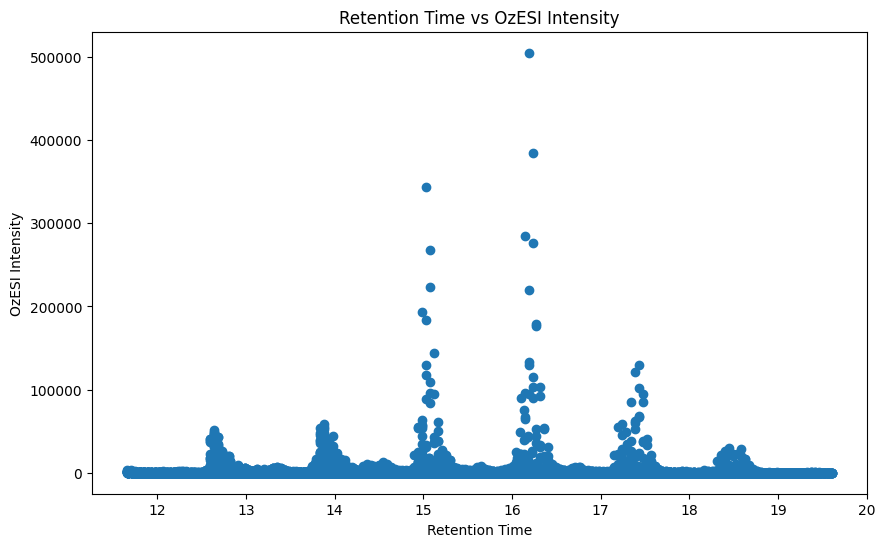

In [32]:


# Assuming clustered_data is your DataFrame with the necessary data

# Plotting the Intensity vs Retention Time
plt.figure(figsize=(10, 6))
plt.scatter(d4['Retention_Time'], d4['OzESI_Intensity'])

# Adding labels and title to the plot
plt.xlabel('Retention Time')
plt.ylabel('OzESI Intensity')
plt.title('Retention Time vs OzESI Intensity')

# Displaying the plot
plt.show()


# Determine Biology and Genotype

In [33]:
# Function to determine the value for the Biology and Genotype column
def extract_biology(sample_id):
    for term in ["liver", "cortex", "cereb", "hippo", "dienc"]:
        if term in sample_id.lower():
            return term
    return None

# Apply the function to the Sample_ID column to create the Biology and Genotype column
d4['Biology'] = d4['Sample_ID'].apply(extract_biology)
d4['Genotype'] = d4['Sample_ID'].apply(lambda x: '5xFAD' if 'WT' not in x else 'WT')
d4

# Function to remove the first TG if there are two TGs
def remove_first_tg(lipid):
    tg_parts = lipid.split(',')
    if len(tg_parts) > 1:
        return '[' + tg_parts[1]
    else:
        return lipid
    
# Function to determine the value for the FAC column
def determine_fac(lipid):
    if 'FA18:1' in lipid:
        return 'FA18:1'
    elif 'FA16:1' in lipid:
        return 'FA16:1'
    else:
        return None  # or some other default value

# Apply the function to the Lipid column to create the FAC column
d4['FAC'] = d4['Lipid'].apply(determine_fac)



# Function to extract TG values
def extract_tg(lipid):
    # Regular expression pattern to match TG(##:#) or similar patterns
    pattern = r'TG\(\d+:\d+\)'
    matches = re.findall(pattern, lipid)
    return ', '.join(matches) if matches else None

# Apply the function to the Lipid column to create the TG column
d4['TG'] = d4['Lipid'].apply(extract_tg)




# Function to sort TG values within a cell
def sort_tg_values(tg_cell):
    if not pd.isna(tg_cell) and ', ' in tg_cell:
        tg_list = tg_cell.split(', ')
        tg_list_sorted = sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')])
        return ', '.join(tg_list_sorted)
    else:
        return tg_cell

# Apply the function to the TG column
d4['TG'] = d4['TG'].apply(sort_tg_values)
d4 = d4.sort_values(by=['FAC', 'TG'])

# Apply the function to the Lipid column
d4['Lipid'] = d4['Lipid'].apply(remove_first_tg)


# Sorting by 'Biology and Genotype' and then by 'Lipid'
d4 = d4.sort_values(by=['Biology','Genotype', 'Lipid'])

grouped_cluster_data = d4.groupby(['Lipid','db','Biology','Genotype','Transition','Sample_ID'])
#add group number to each to a new column called Group
d4['Group'] = grouped_cluster_data.ngroup()
d4
d5= d4.copy()  # Create a copy of the clustered_data DataFrame
#print transition 870.8 -> 788.8
d5

Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0           694.6        547.5       12.918583       231.780014   
1           694.6        547.5       12.962983       354.560028   
2           694.6        547.5       13.007400       305.760010   
3           694.6        547.5       13.051800        70.180008   
4           694.6        547.5       13.096217       211.200012   
...           ...          ...             ...              ...   
34303       870.7        653.5       16.393767       115.780006   
34304       870.7        653.5       16.438167        41.140003   
34305       870.7        653.5       16.482567        40.840004   
34306       870.7        653.5       16.526983        41.120003   
34307       870.7        653.5       16.571383        41.160004   

                                    Sample_ID      Transition    db  \
0       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
1       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
2       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
3       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
4       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
...                                       ...             ...   ...   
34303  12012023_FAD173_M1_5xFAD_liver_O3on_01  870.7 -> 653.5   n-7   
34304  12012023_FAD173_M1_5xFAD_liver_O3on_01  870.7 -> 653.5   n-7   
34305  12012023_FAD173_M1_5xFAD_liver_O3on_01  870.7 -> 653.5   n-7   
34306  12012023_FAD173_M1_5xFAD_liver_O3on_01  870.7 -> 653.5   n-7   
34307  12012023_FAD173_M1_5xFAD_liver_O3on_01  870.7 -> 653.5   n-7   

                   Lipid  Cluster_Label Biology Genotype     FAC  \
0      [TG(50:3)]_FA18:1              1   liver    5xFAD  FA18:1   
1      [TG(50:3)]_FA18:1              1   liver    5xFAD  FA18:1   
2      [TG(50:3)]_FA18:1              1   liver    5xFAD  FA18:1   
3      [TG(50:3)]_FA18:1              1   liver    5xFAD  FA18:1   
4      [TG(50:3)]_FA18:1              1   liver    5xFAD  FA18:1   
...                  ...            ...     ...      ...     ...   
34303  [TG(58:6)]_FA18:1              0   liver    5xFAD  FA18:1   
34304  [TG(58:6)]_FA18:1              0   liver    5xFAD  FA18:1   
34305  [TG(58:6)]_FA18:1              0   liver    5xFAD  FA18:1   
34306  [TG(58:6)]_FA18:1              0   liver    5xFAD  FA18:1   
34307  [TG(58:6)]_FA18:1              0   liver    5xFAD  FA18:1   

                        TG  Group  
0                 TG(50:3)      5  
1                 TG(50:3)      5  
2                 TG(50:3)      5  
3                 TG(50:3)      5  
4                 TG(50:3)      5  
...                    ...    ...  
34303  TG(58:6), TG(59:13)    454  
34304  TG(58:6), TG(59:13)    454  
34305  TG(58:6), TG(59:13)    454  
34306  TG(58:6), TG(59:13)    454  
34307  TG(58:6), TG(59:13)    454  

[24695 rows x 14 columns]

# Find max intensity

In [34]:
d6 = d5.copy()
# Group by 'Group' and 'Cluster_Label' and find the maximum 'OzESI_Intensity' for each group
max_intensity_group = d5.groupby(['Group', 'Cluster_Label'])['OzESI_Intensity'].max().reset_index()

# Rename the column to 'Max_Intensity'
max_intensity_group = max_intensity_group.rename(columns={'OzESI_Intensity': 'Max_Intensity'})

# Merge the maximum intensity data back into the original DataFrame
d6 = d6.merge(max_intensity_group, on=['Group', 'Cluster_Label'])
#round max intensity to 0 decimal places
d6['Max_Intensity'] = d6['Max_Intensity'].round(0)
# Display the DataFrame
d6


Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0           694.6        547.5       12.918583       231.780014   
1           694.6        547.5       12.962983       354.560028   
2           694.6        547.5       13.007400       305.760010   
3           694.6        547.5       13.051800        70.180008   
4           694.6        547.5       13.096217       211.200012   
...           ...          ...             ...              ...   
24690       870.7        653.5       16.393767       115.780006   
24691       870.7        653.5       16.438167        41.140003   
24692       870.7        653.5       16.482567        40.840004   
24693       870.7        653.5       16.526983        41.120003   
24694       870.7        653.5       16.571383        41.160004   

                                    Sample_ID      Transition    db  \
0       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
1       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
2       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
3       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
4       12012023_DOD73_M2_5xFAD_liver_O3on_01  694.6 -> 547.5  n-12   
...                                       ...             ...   ...   
24690  12012023_FAD173_M1_5xFAD_liver_O3on_01  870.7 -> 653.5   n-7   
24691  12012023_FAD173_M1_5xFAD_liver_O3on_01  870.7 -> 653.5   n-7   
24692  12012023_FAD173_M1_5xFAD_liver_O3on_01  870.7 -> 653.5   n-7   
24693  12012023_FAD173_M1_5xFAD_liver_O3on_01  870.7 -> 653.5   n-7   
24694  12012023_FAD173_M1_5xFAD_liver_O3on_01  870.7 -> 653.5   n-7   

                   Lipid  Cluster_Label Biology Genotype     FAC  \
0      [TG(50:3)]_FA18:1              1   liver    5xFAD  FA18:1   
1      [TG(50:3)]_FA18:1              1   liver    5xFAD  FA18:1   
2      [TG(50:3)]_FA18:1              1   liver    5xFAD  FA18:1   
3      [TG(50:3)]_FA18:1              1   liver    5xFAD  FA18:1   
4      [TG(50:3)]_FA18:1              1   liver    5xFAD  FA18:1   
...                  ...            ...     ...      ...     ...   
24690  [TG(58:6)]_FA18:1              0   liver    5xFAD  FA18:1   
24691  [TG(58:6)]_FA18:1              0   liver    5xFAD  FA18:1   
24692  [TG(58:6)]_FA18:1              0   liver    5xFAD  FA18:1   
24693  [TG(58:6)]_FA18:1              0   liver    5xFAD  FA18:1   
24694  [TG(58:6)]_FA18:1              0   liver    5xFAD  FA18:1   

                        TG  Group  Max_Intensity  
0                 TG(50:3)      5          355.0  
1                 TG(50:3)      5          355.0  
2                 TG(50:3)      5          355.0  
3                 TG(50:3)      5          355.0  
4                 TG(50:3)      5          355.0  
...                    ...    ...            ...  
24690  TG(58:6), TG(59:13)    454          116.0  
24691  TG(58:6), TG(59:13)    454          116.0  
24692  TG(58:6), TG(59:13)    454          116.0  
24693  TG(58:6), TG(59:13)    454          116.0  
24694  TG(58:6), TG(59:13)    454          116.0  

[24695 rows x 15 columns]

# Match cluster to ground truth RT

In [35]:


# Assuming d6 DataFrame is already defined
d7 = d6.copy()

# Adding Cluster_RT column to d7 using Max_Intensity values
d7['Cluster_RT'] = d7.groupby(['Lipid', 'Sample_ID', 'db'])['Max_Intensity'].transform('idxmax').map(d7['Retention_Time'])

# Rounding Cluster_RT to 2 decimal places
d7['Cluster_RT'] = d7['Cluster_RT'].round(2)

###########

# Assuming d8 is already defined
d8 = d7.copy()

# Create a mapping from Lipid to ground truth Retention_Time
ground_truth_rt = dict(zip(df_db_pos['Lipid'], df_db_pos['Retention_Time']))

# Calculate the distance to the ground truth for each row in d8
d8['distance_to_truth'] = d8.apply(lambda row: abs(row['Retention_Time'] - ground_truth_rt.get(row['Lipid'], np.nan)), axis=1)

# Filter out rows with NaN in 'distance_to_truth'
d8_filtered = d8.dropna(subset=['distance_to_truth'])

# Function to keep all rows of the group with the closest Cluster_Label to the ground truth
def keep_group_with_closest_cluster(group):
    idx_min_distance = group['distance_to_truth'].idxmin()
    closest_cluster_label = group.loc[idx_min_distance, 'Cluster_Label']
    return group[group['Cluster_Label'] == closest_cluster_label]

# Apply the function to each group in the filtered DataFrame
df_true = d8_filtered.groupby('Group').apply(keep_group_with_closest_cluster).reset_index(drop=True)

# Displaying the updated DataFrame
df_true

d9 = df_true.copy()    
d9


Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0          722.7        547.5       13.627617        40.900002   
1          722.7        547.5       13.672017        40.880001   
2          722.7        547.5       13.716417        41.060001   
3          722.7        547.5       13.760833        41.200005   
4          722.7        547.5       13.805233        40.900002   
...          ...          ...             ...              ...   
1910       814.7        625.5       14.583133       129.980011   
1911       814.7        625.5       14.627533        41.220001   
1912       814.7        625.5       14.671950       186.760010   
1913       814.7        625.5       14.716350       454.360046   
1914       814.7        625.5       14.760750      1374.700073   

                                   Sample_ID      Transition    db  \
0      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
1      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
2      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
3      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
4      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
...                                      ...             ...   ...   
1910  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1911  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1912  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1913  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1914  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   

                  Lipid  Cluster_Label Biology Genotype     FAC        TG  \
0     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
1     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
2     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
3     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
4     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
...                 ...            ...     ...      ...     ...       ...   
1910  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1911  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1912  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1913  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1914  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   

      Group  Max_Intensity  Cluster_RT  distance_to_truth  
0         0          354.0       13.63           0.372383  
1         0          354.0       13.63           0.327983  
2         0          354.0       13.63           0.283583  
3         0          354.0       13.63           0.239167  
4         0          354.0       13.63           0.194767  
...     ...            ...         ...                ...  
1910    379         5795.0       14.09           0.153133  
1911    379         5795.0       14.09           0.197533  
1912    379         5795.0       14.09           0.241950  
1913    379         5795.0       14.09           0.286350  
1914    379         5795.0       14.09           0.330750  

[1915 rows x 17 columns]

# Keep Cluster with highest max intensity, remove other clusters

In [36]:
d10 = d9.copy()
# Step 1: Identify the Cluster_Label with the highest Max_Intensity for each Group
max_intensity_label_per_group = d10.groupby('Group').apply(lambda x: x['Cluster_Label'][x['Max_Intensity'].idxmax()])

# Step 2: Filter the original DataFrame
d10 = d10[d10.apply(lambda row: row['Cluster_Label'] == max_intensity_label_per_group[row['Group']], axis=1)]

# Filter out group-cluster pairs where the maximum intensity (Max_Intensity) is 500 or less
valid_pairs = d10[d10['Max_Intensity'] > 300]

# The resulting DataFrame, valid_pairs, now contains data for group-cluster pairs meeting the intensity criterion
d10 = valid_pairs

# Display the filtered DataFrame
d10



Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0          722.7        547.5       13.627617        40.900002   
1          722.7        547.5       13.672017        40.880001   
2          722.7        547.5       13.716417        41.060001   
3          722.7        547.5       13.760833        41.200005   
4          722.7        547.5       13.805233        40.900002   
...          ...          ...             ...              ...   
1910       814.7        625.5       14.583133       129.980011   
1911       814.7        625.5       14.627533        41.220001   
1912       814.7        625.5       14.671950       186.760010   
1913       814.7        625.5       14.716350       454.360046   
1914       814.7        625.5       14.760750      1374.700073   

                                   Sample_ID      Transition    db  \
0      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
1      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
2      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
3      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
4      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
...                                      ...             ...   ...   
1910  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1911  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1912  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1913  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1914  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   

                  Lipid  Cluster_Label Biology Genotype     FAC        TG  \
0     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
1     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
2     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
3     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
4     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
...                 ...            ...     ...      ...     ...       ...   
1910  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1911  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1912  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1913  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1914  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   

      Group  Max_Intensity  Cluster_RT  distance_to_truth  
0         0          354.0       13.63           0.372383  
1         0          354.0       13.63           0.327983  
2         0          354.0       13.63           0.283583  
3         0          354.0       13.63           0.239167  
4         0          354.0       13.63           0.194767  
...     ...            ...         ...                ...  
1910    379         5795.0       14.09           0.153133  
1911    379         5795.0       14.09           0.197533  
1912    379         5795.0       14.09           0.241950  
1913    379         5795.0       14.09           0.286350  
1914    379         5795.0       14.09           0.330750  

[1280 rows x 17 columns]

# Set Peak Boundaries using Peak Width at % of Peak Height

354.3600158691406


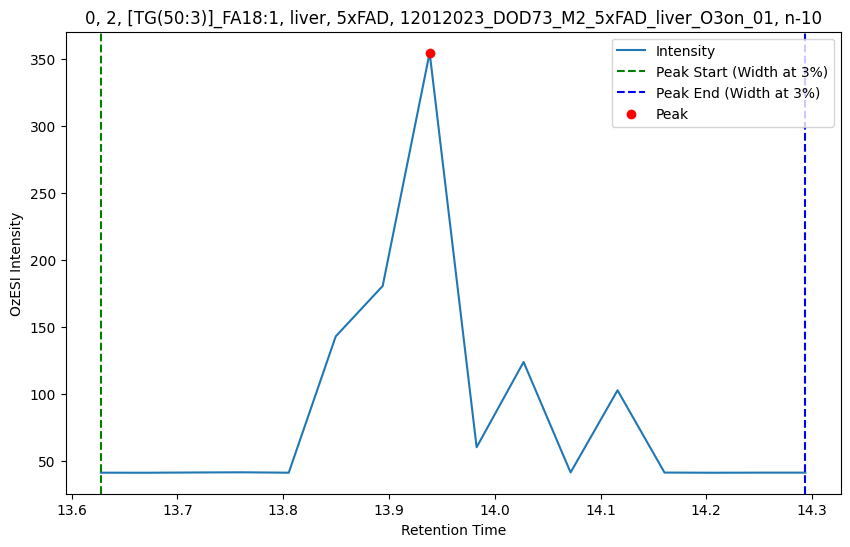

471.8800354003906


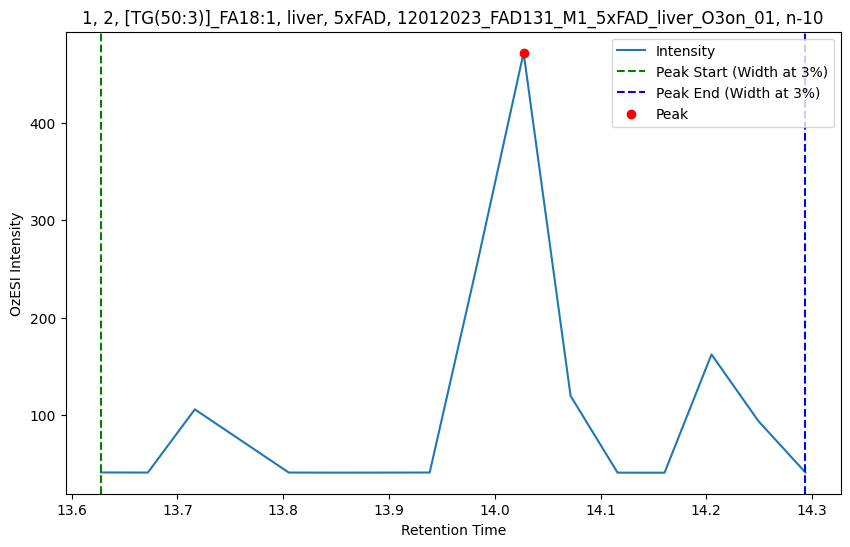

394.6600341796875


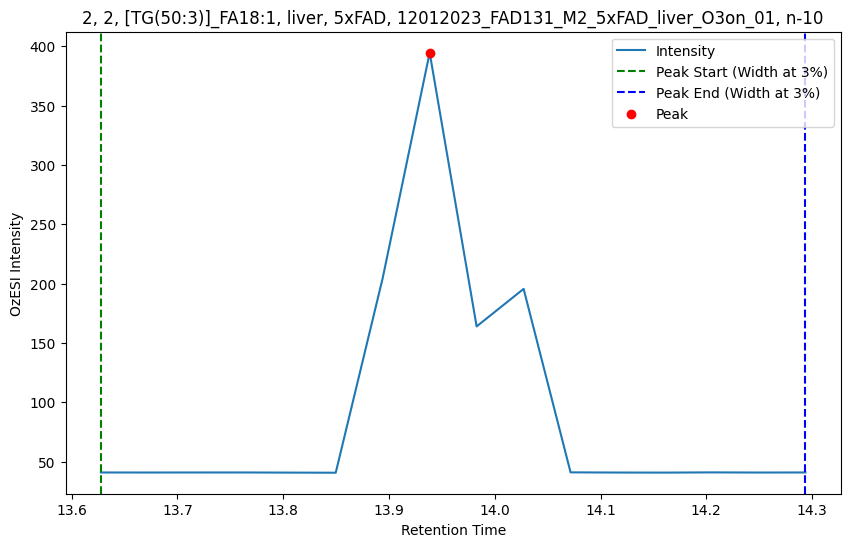

1214.400146484375


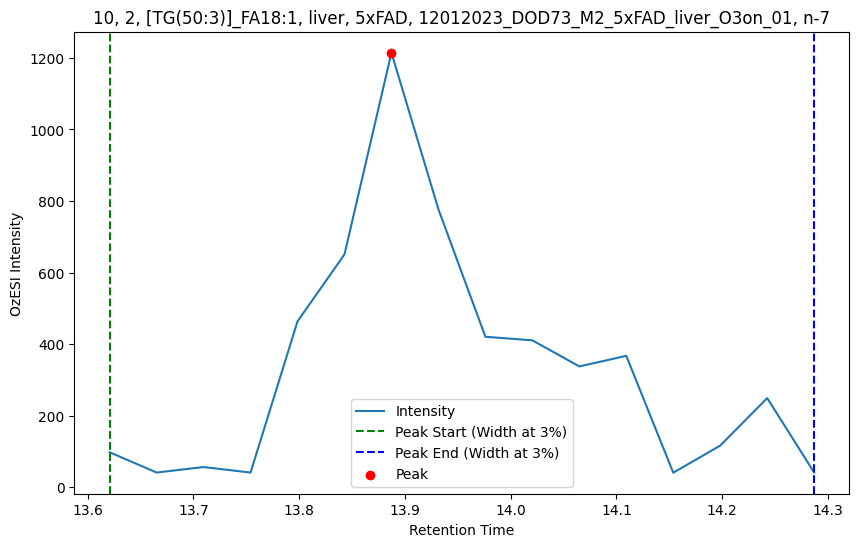

2417.16015625


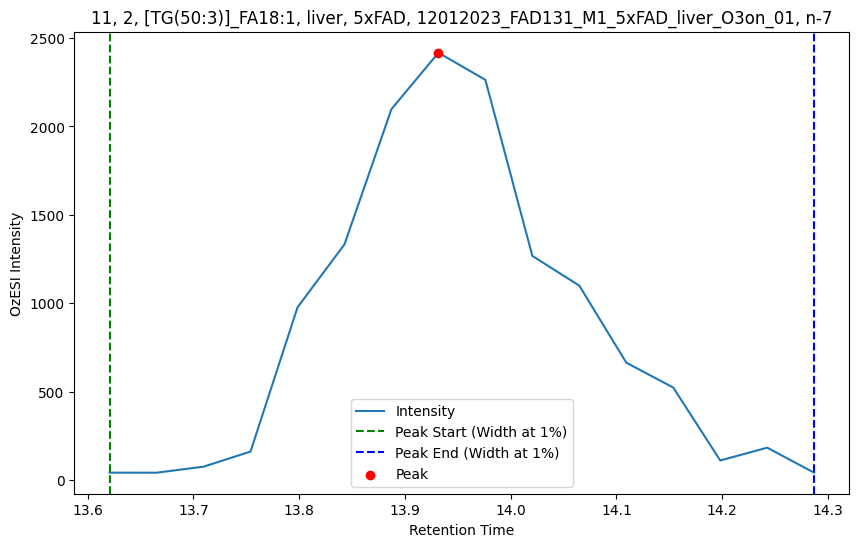

4462.560546875


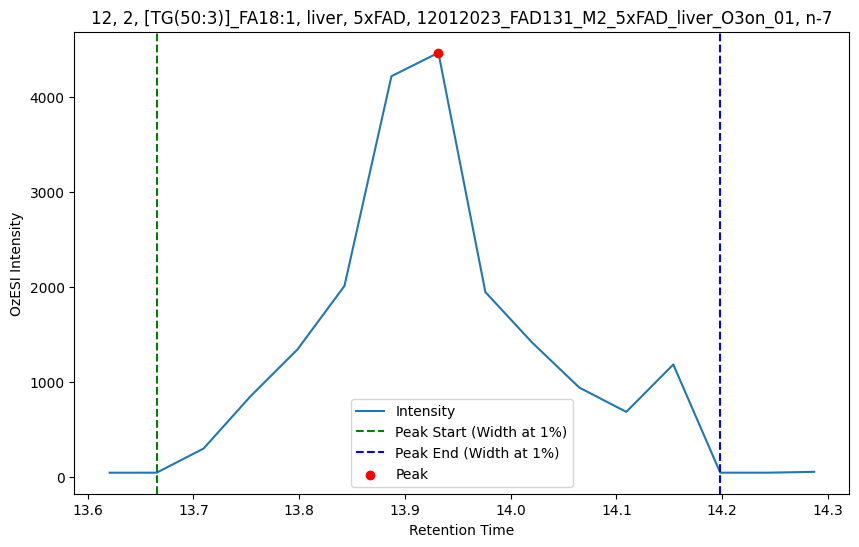

1084.300048828125


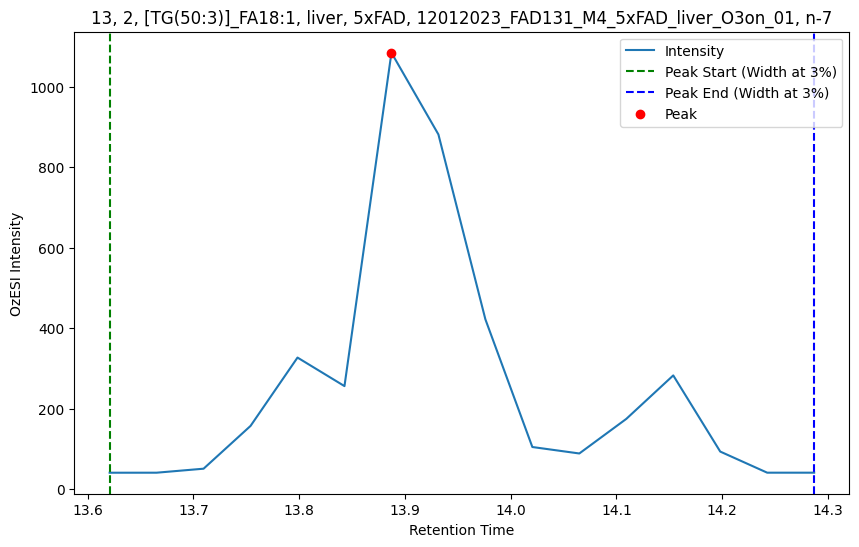

1141.5400390625


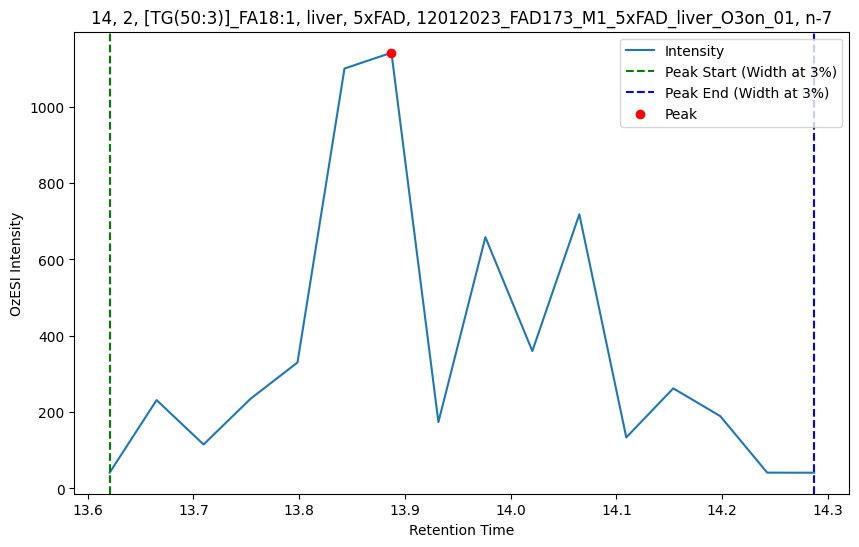

13196.640625


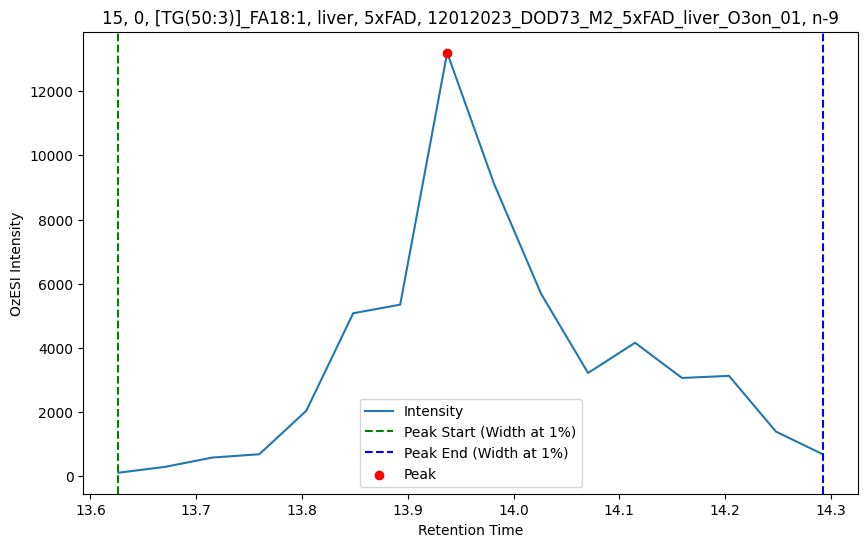

32074.861328125


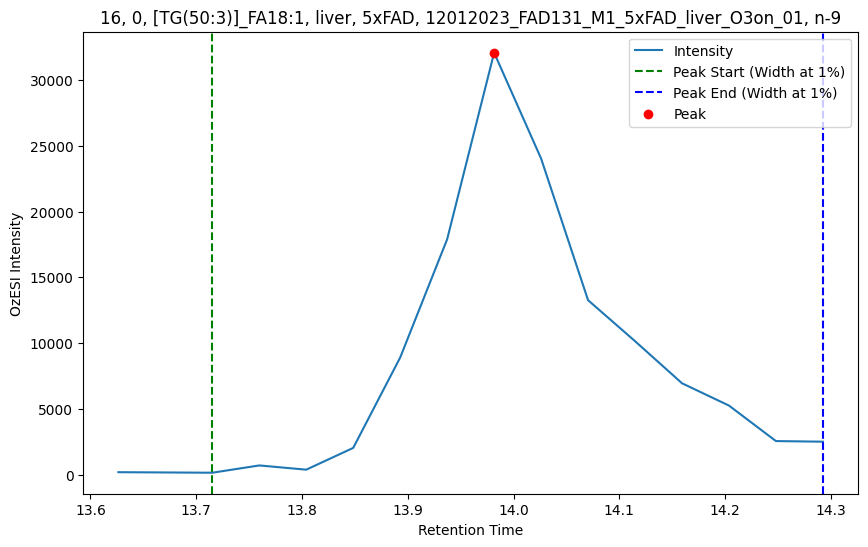

44610.18359375


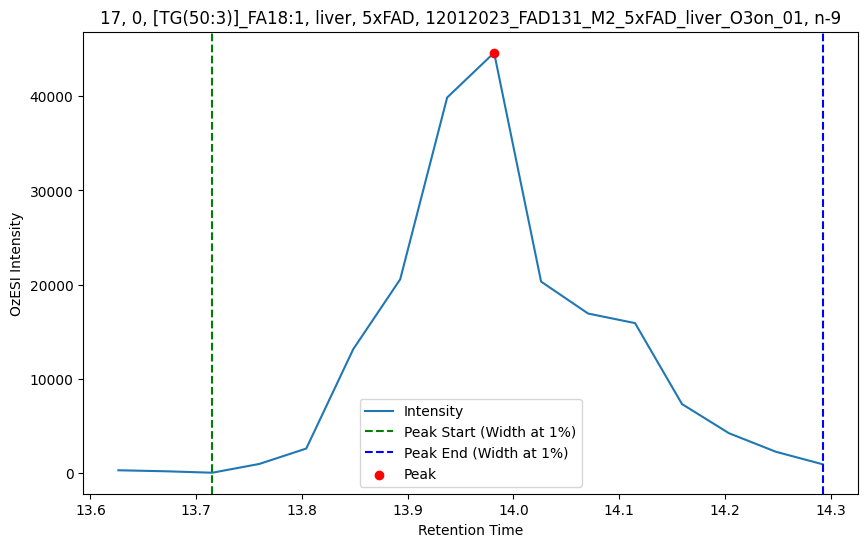

7338.58056640625


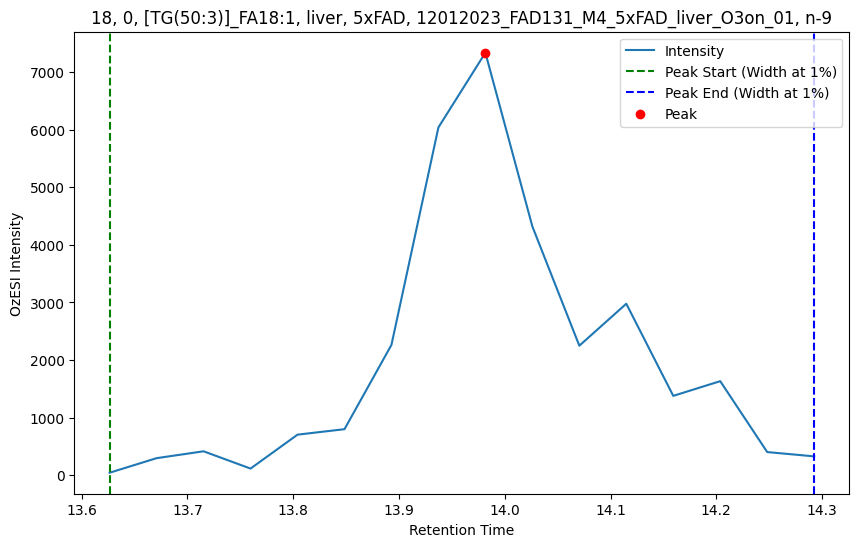

15214.7412109375


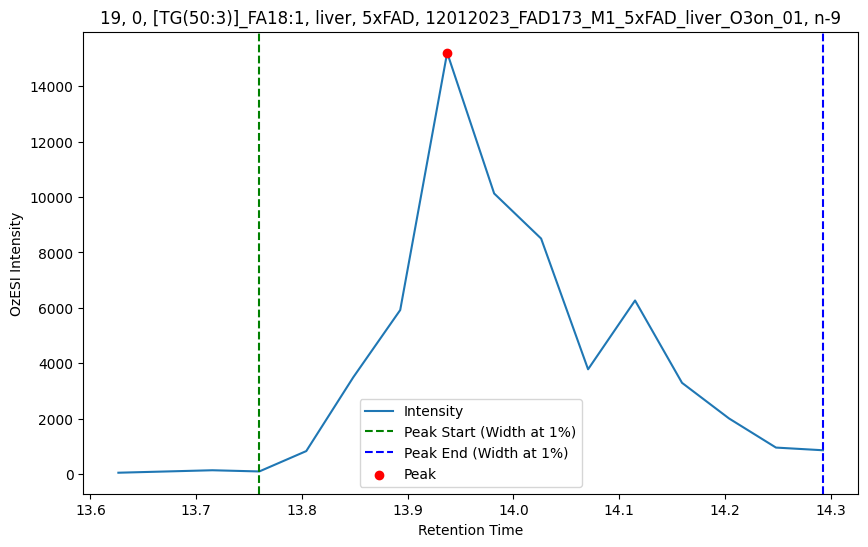

501.3800354003906


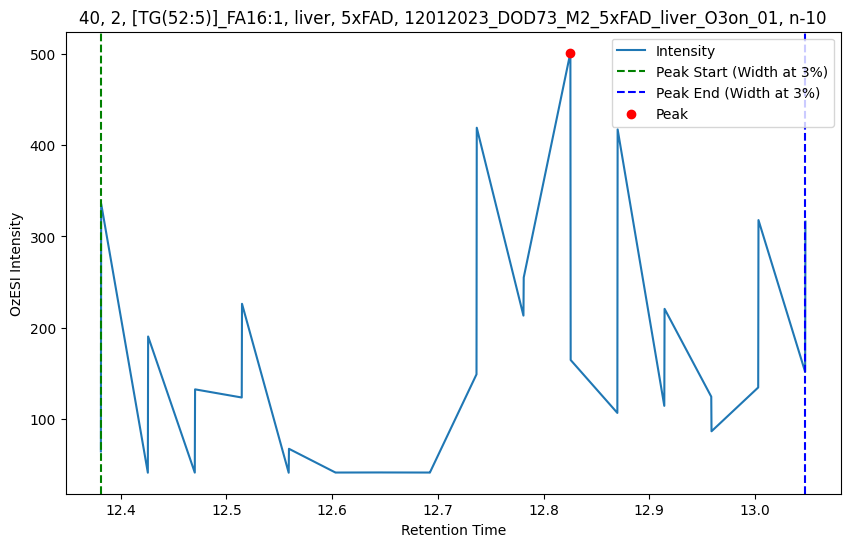

953.9800415039062


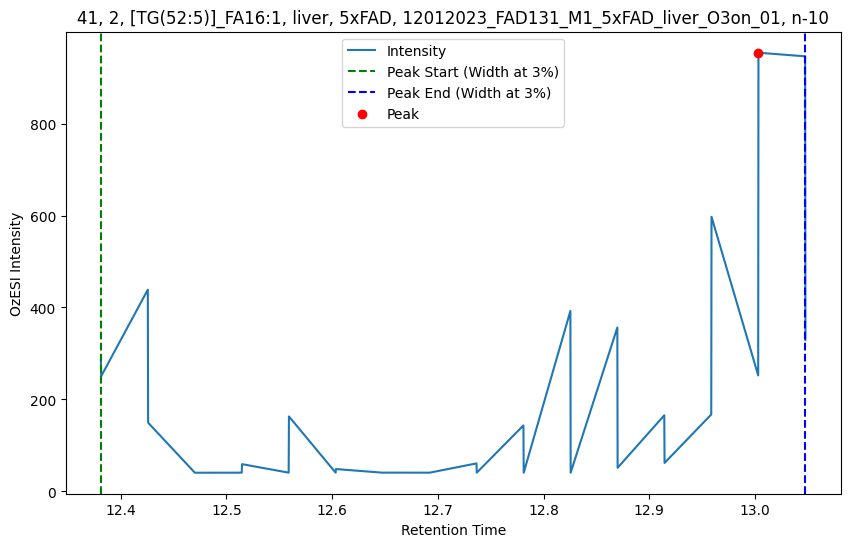

737.2000732421875


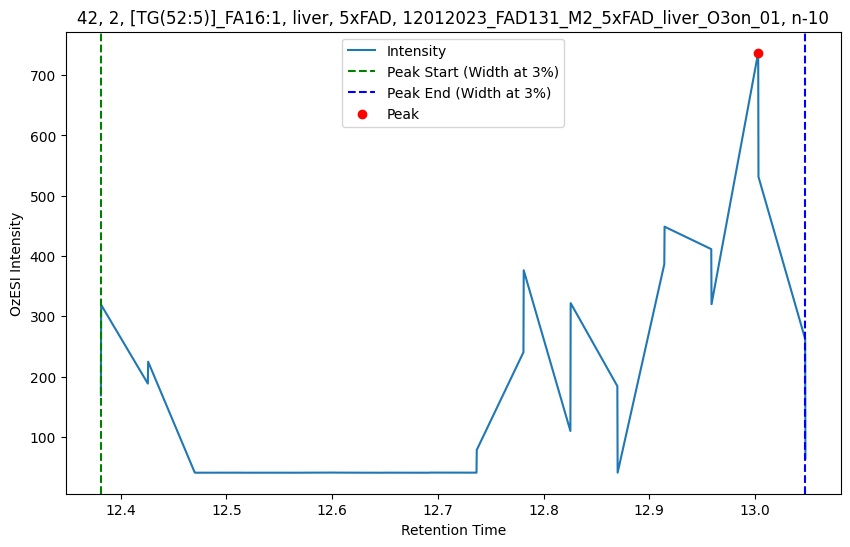

664.8400268554688


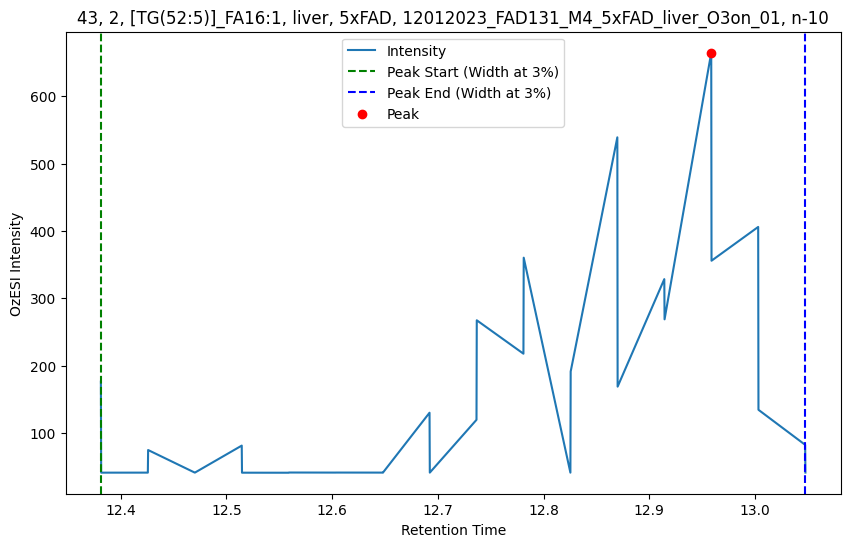

460.7000427246094


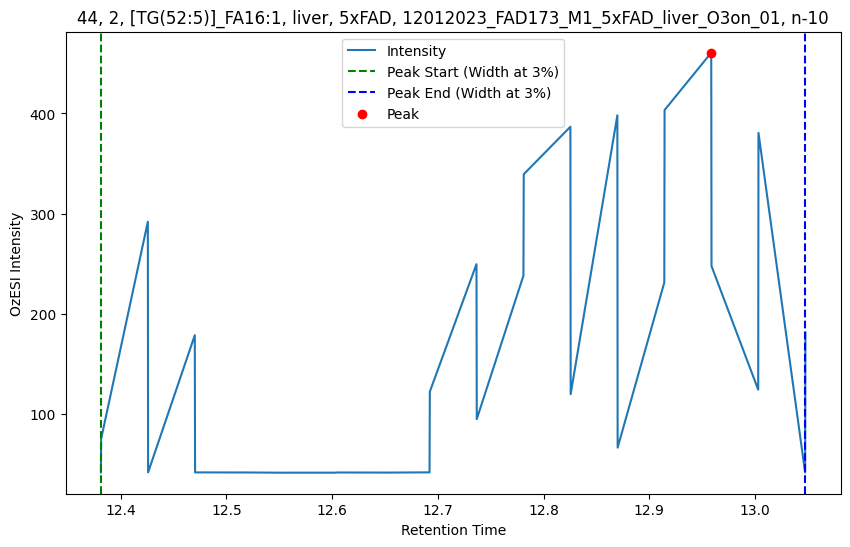

314.4000244140625


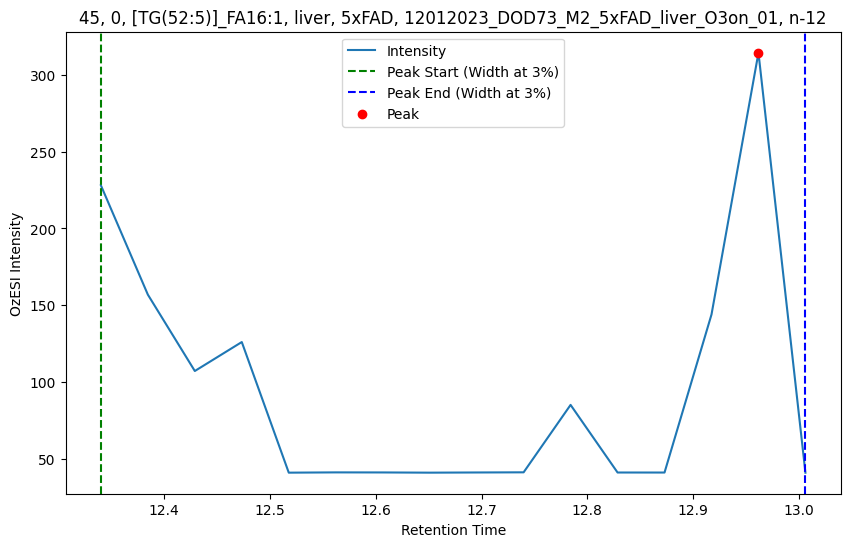

817.1400756835938


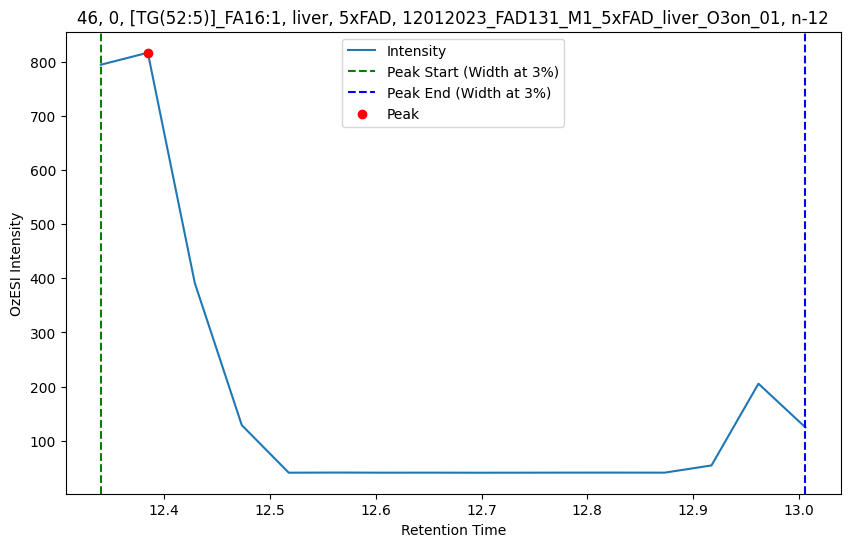

1126.9000244140625


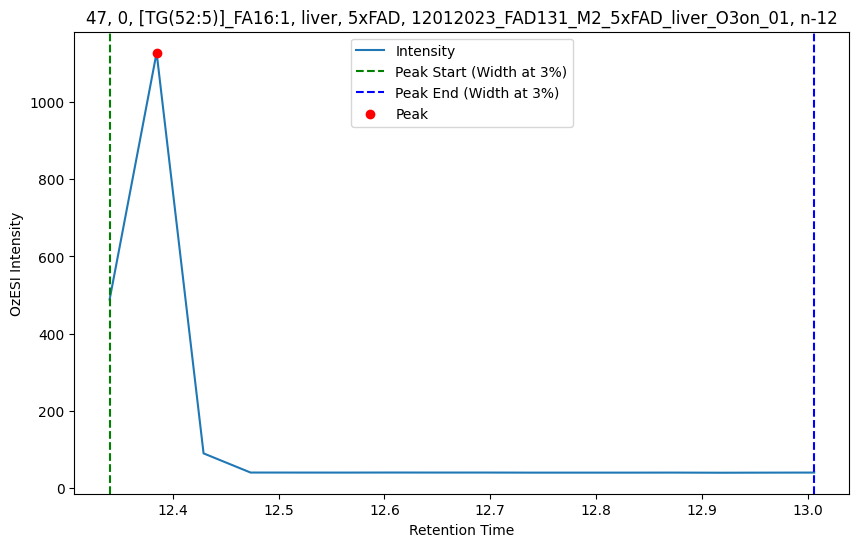

383.7600402832031


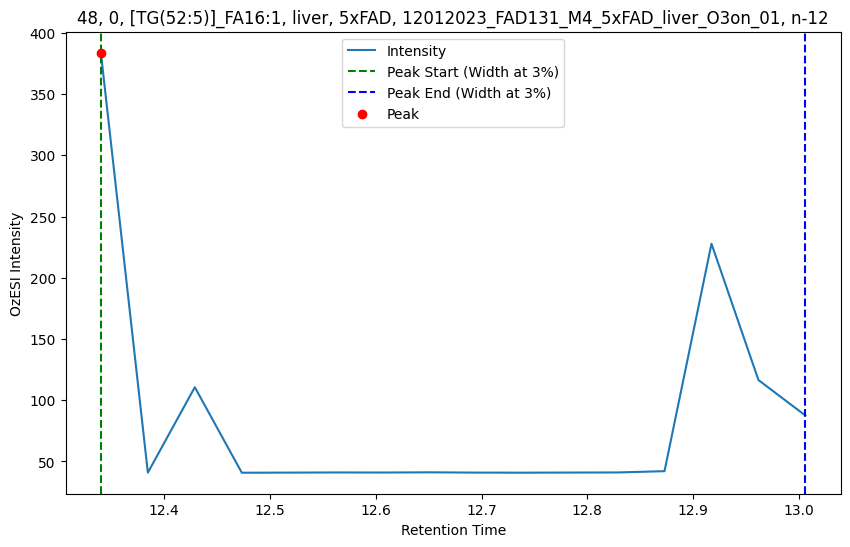

703.280029296875


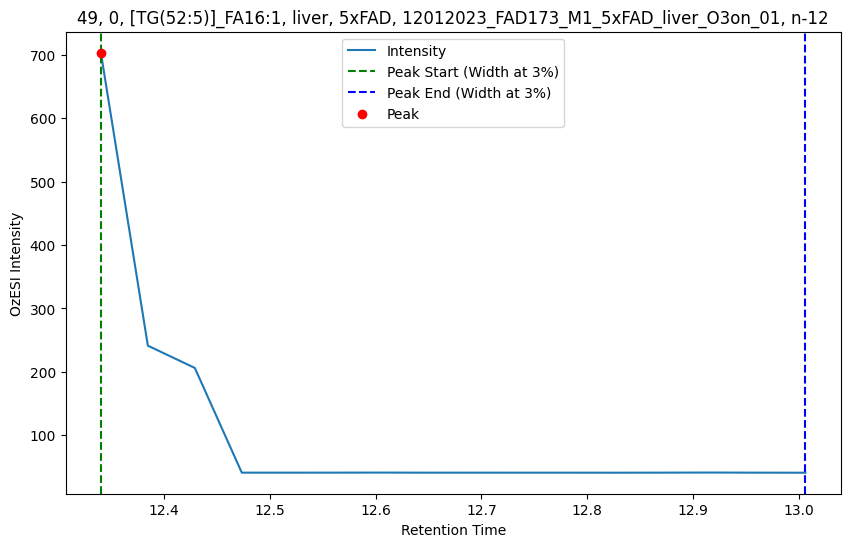

49191.82421875


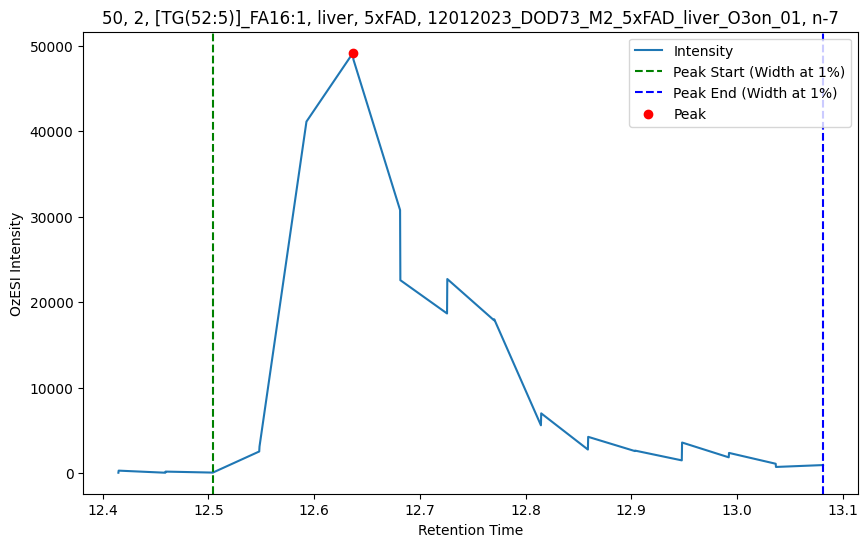

43296.94140625


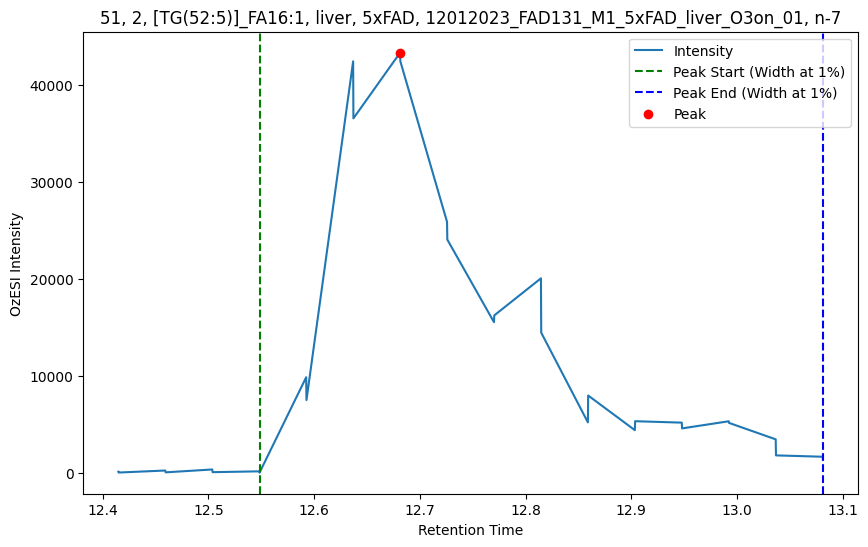

44874.1015625


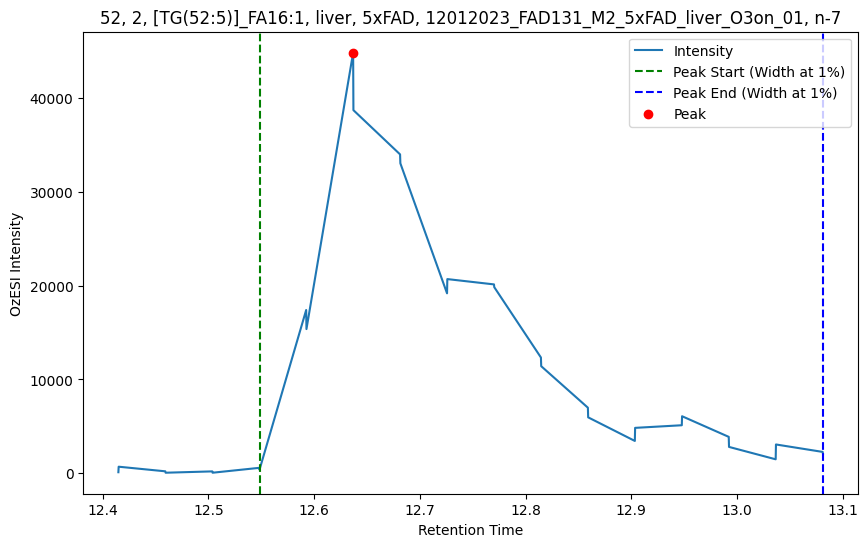

31804.341796875


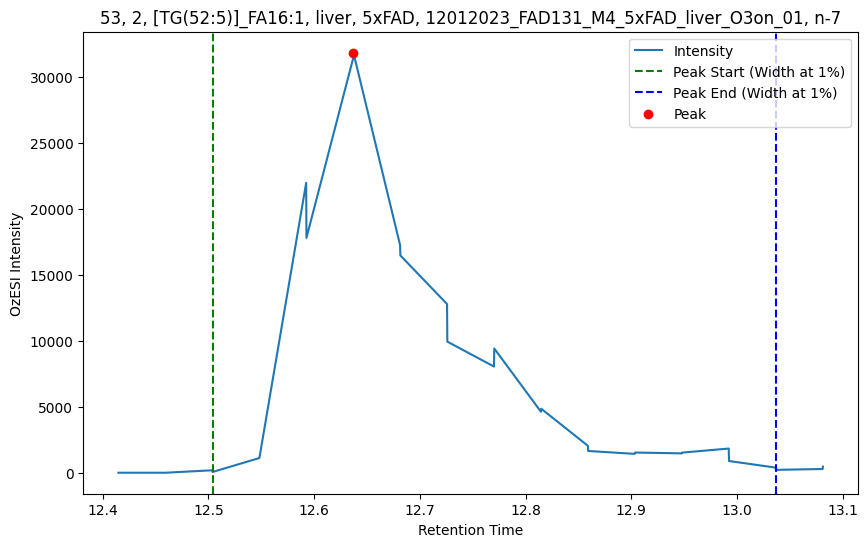

50976.40234375


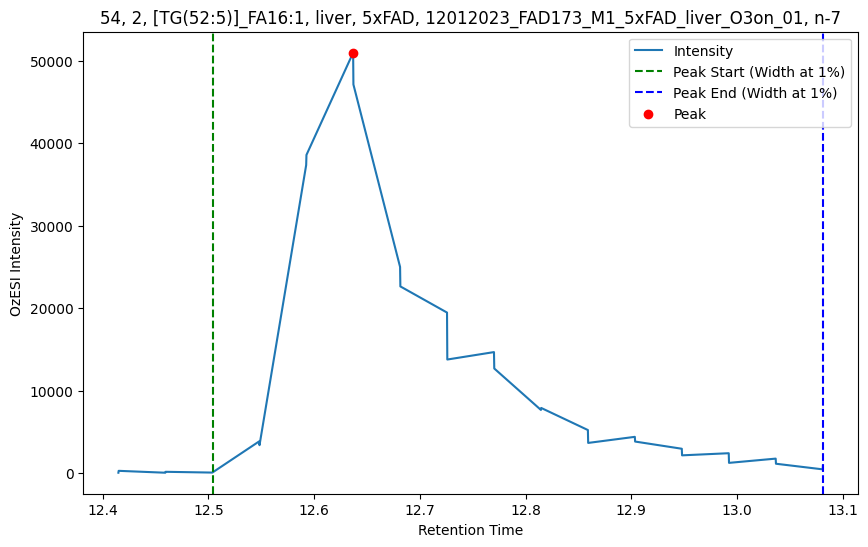

5585.46044921875


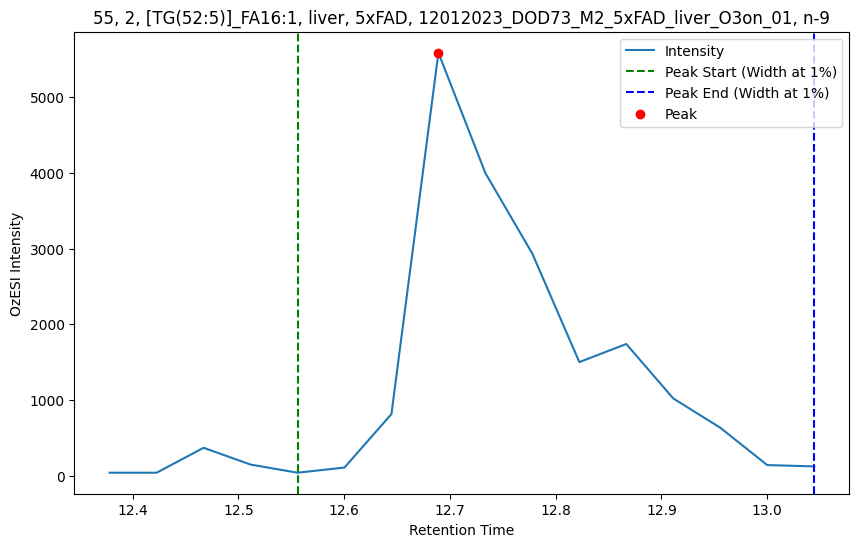

14526.640625


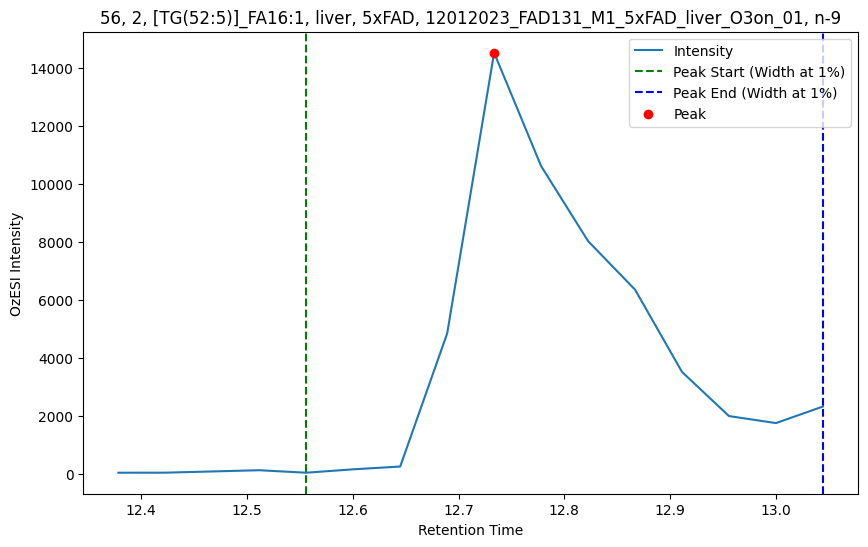

20182.44140625


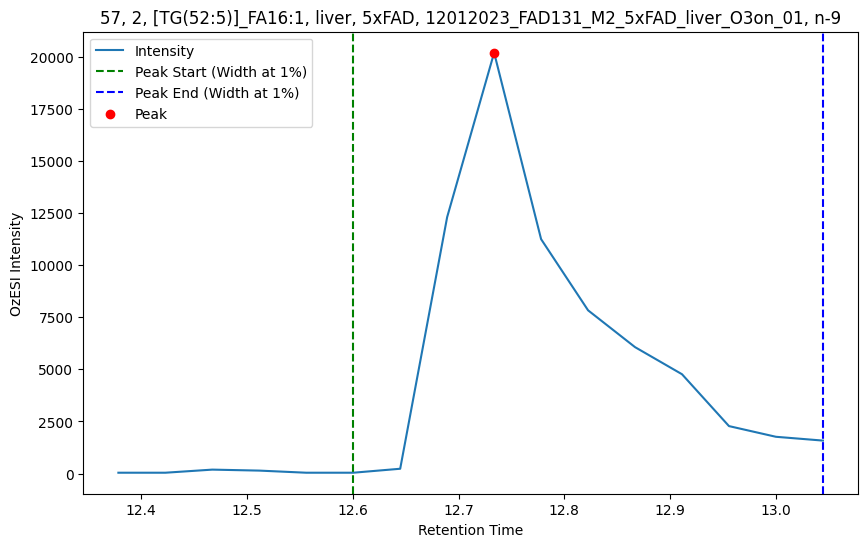

6253.4404296875


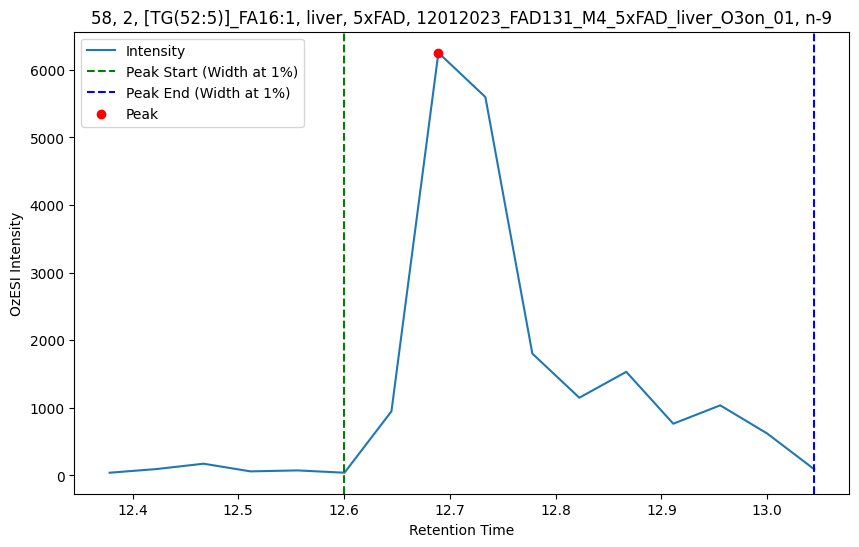

16992.76171875


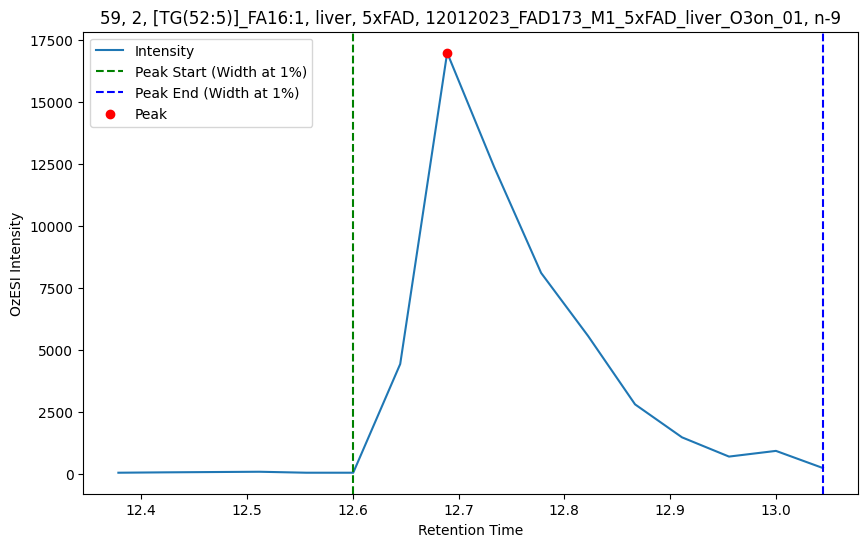

587.9800415039062


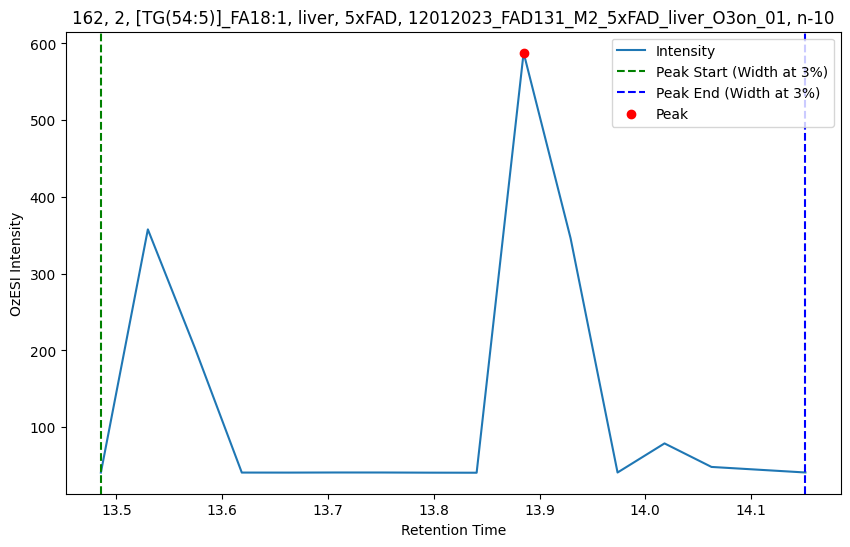

486.0600280761719


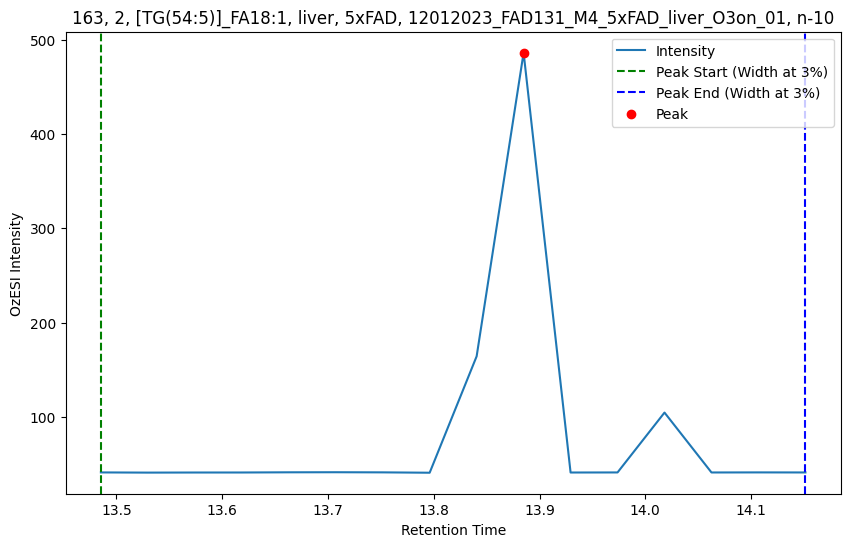

5788.4404296875


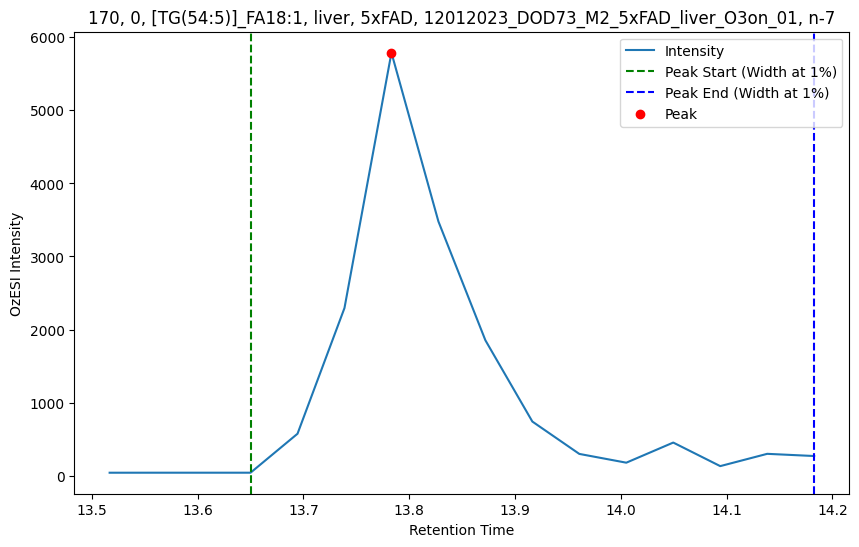

9143.48046875


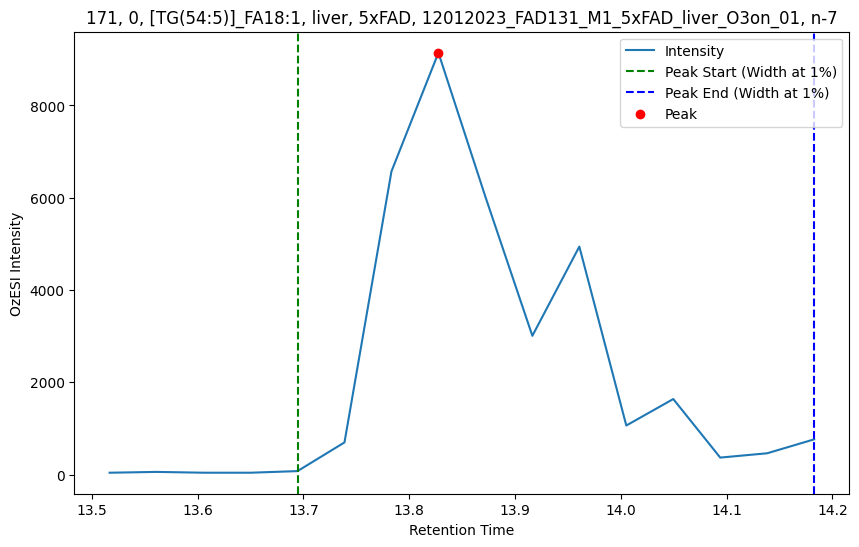

12025.6611328125


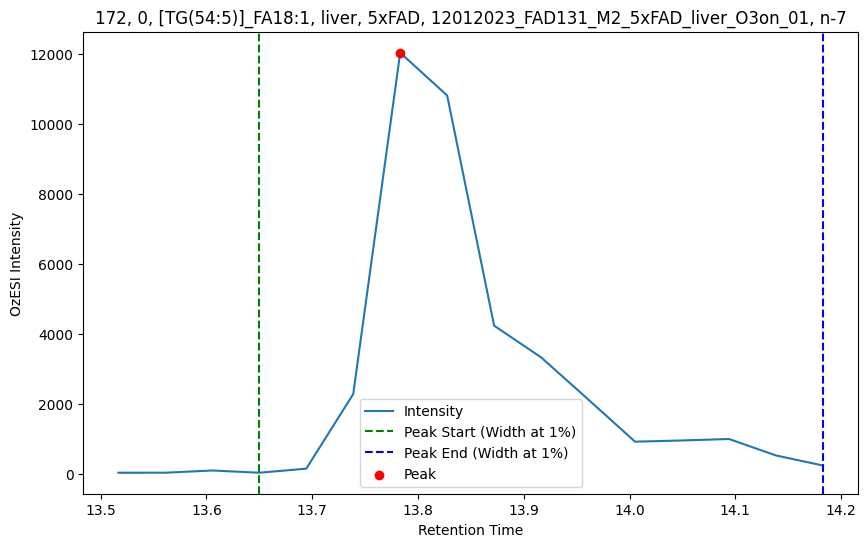

5135.42041015625


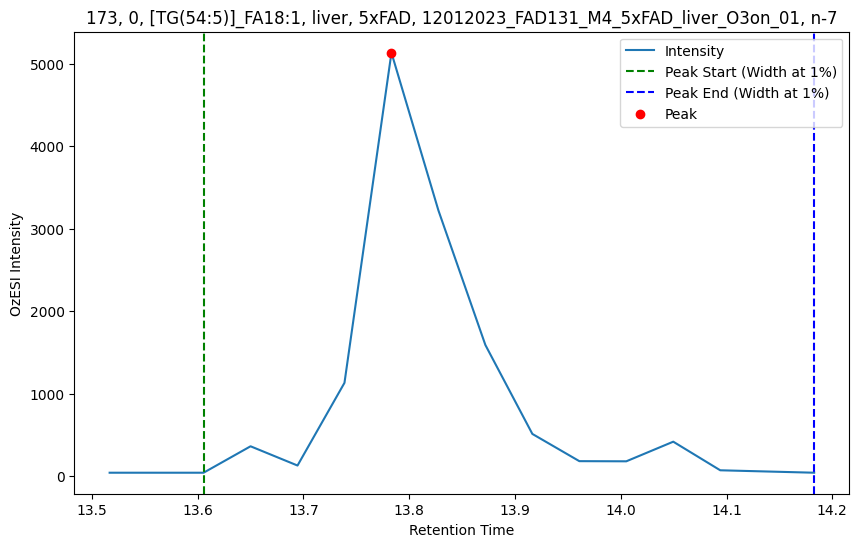

8105.58056640625


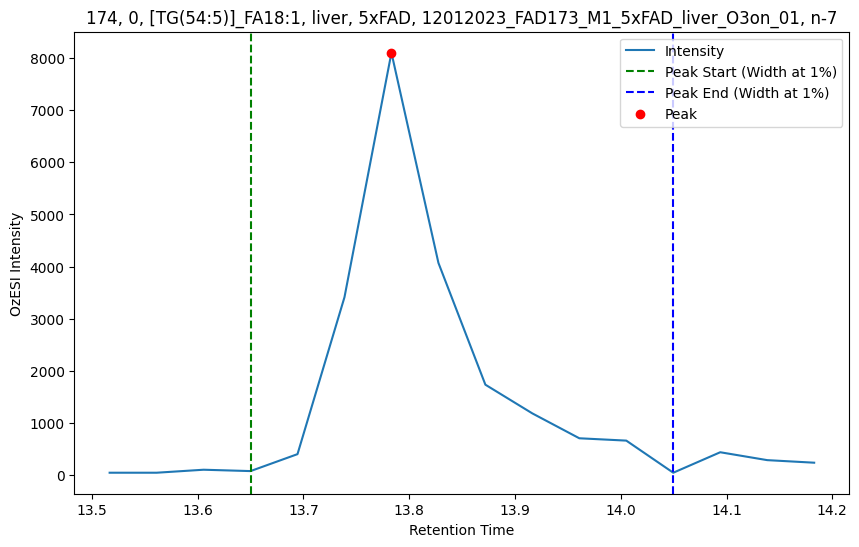

38261.58203125


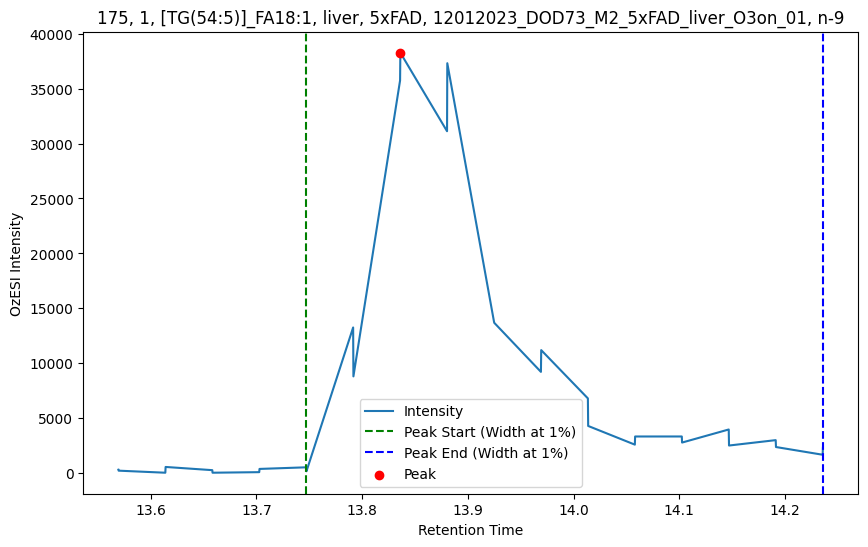

52767.60546875


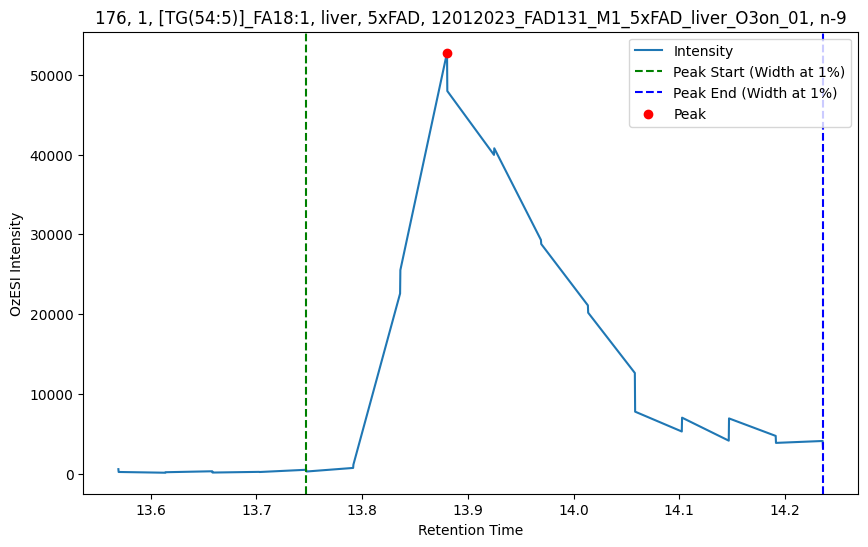

58631.42578125


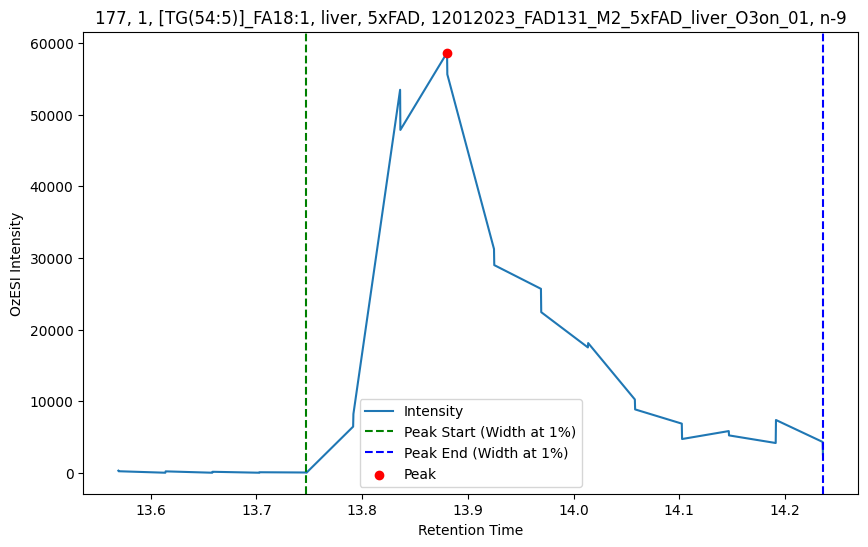

30664.642578125


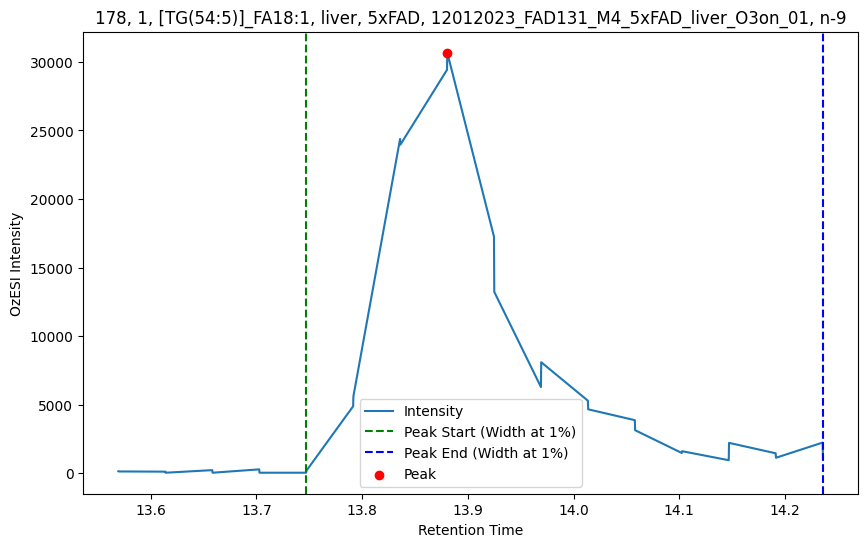

45432.1015625


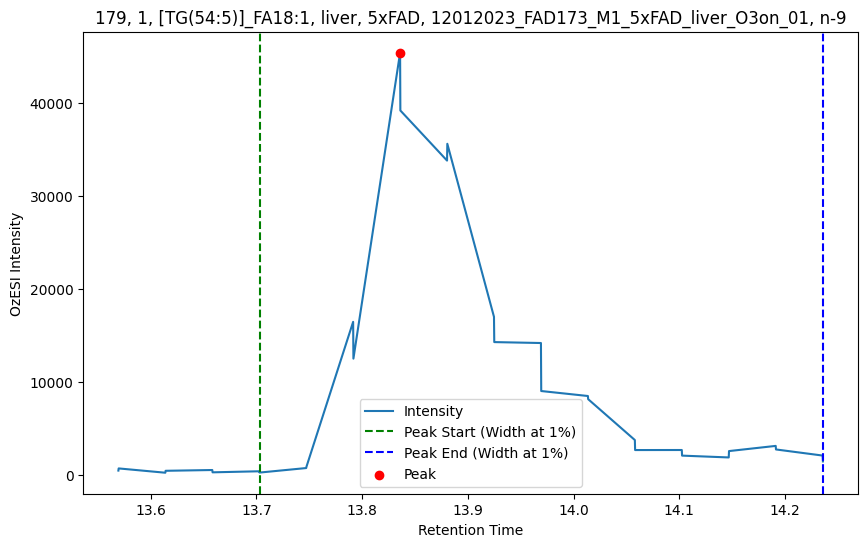

596.6000366210938


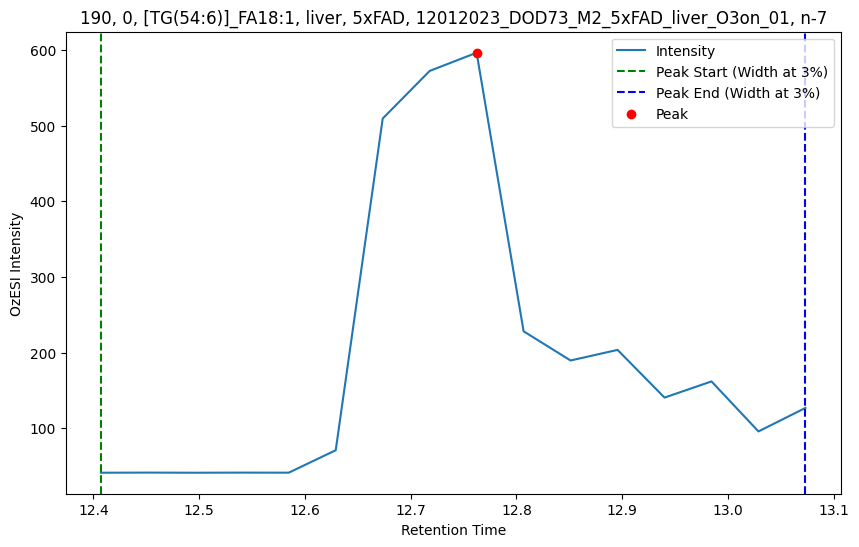

1290.7200927734375


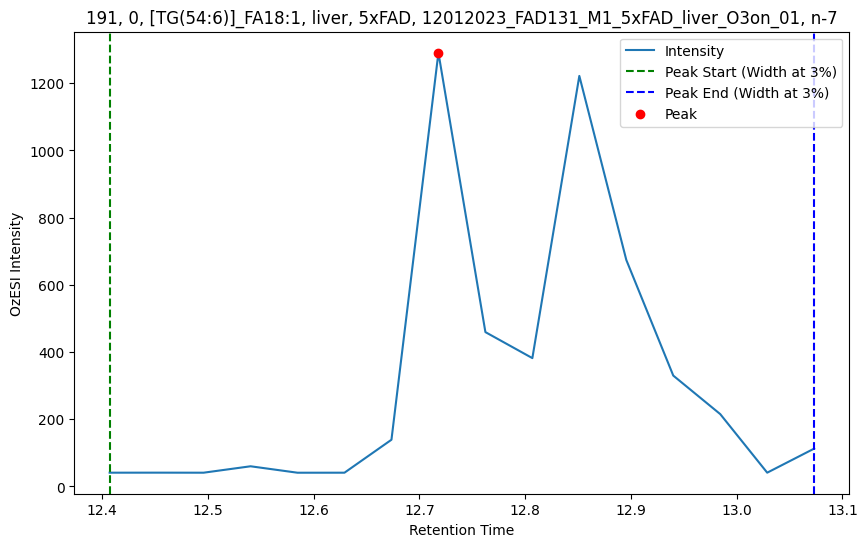

1439.380126953125


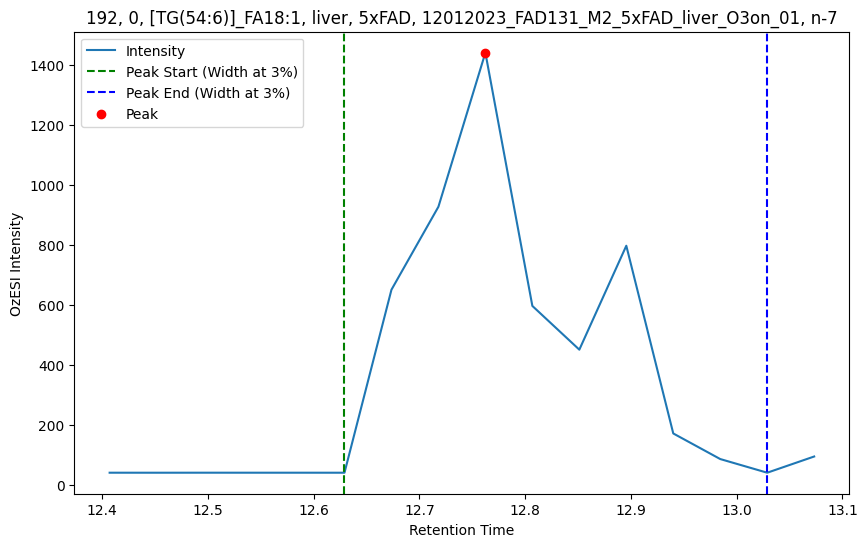

708.5000610351562


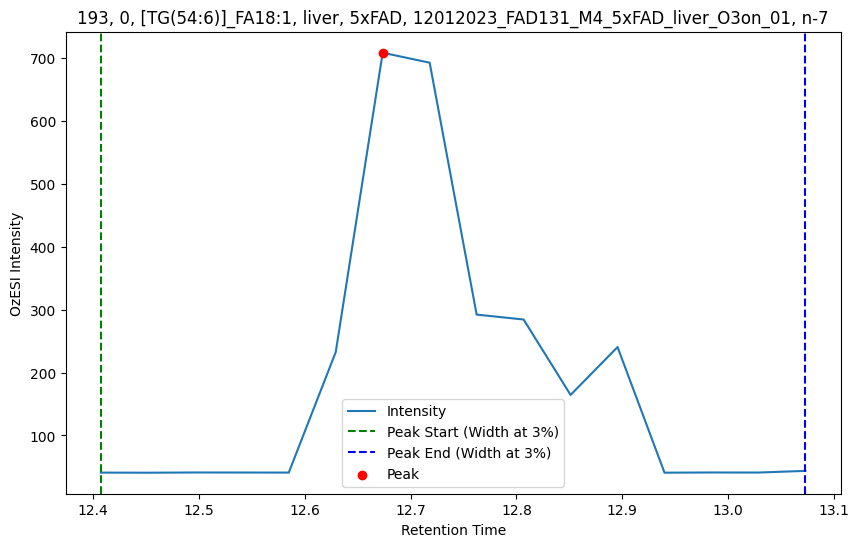

1019.6400756835938


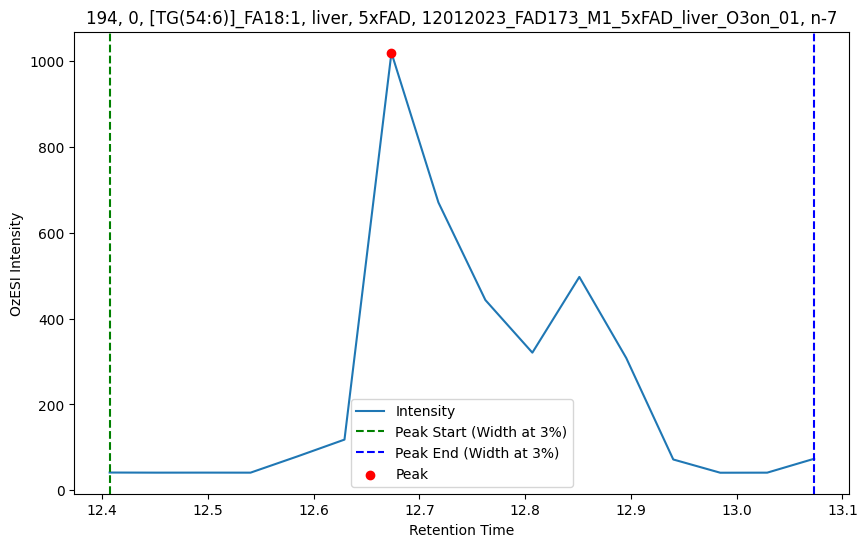

10733.8203125


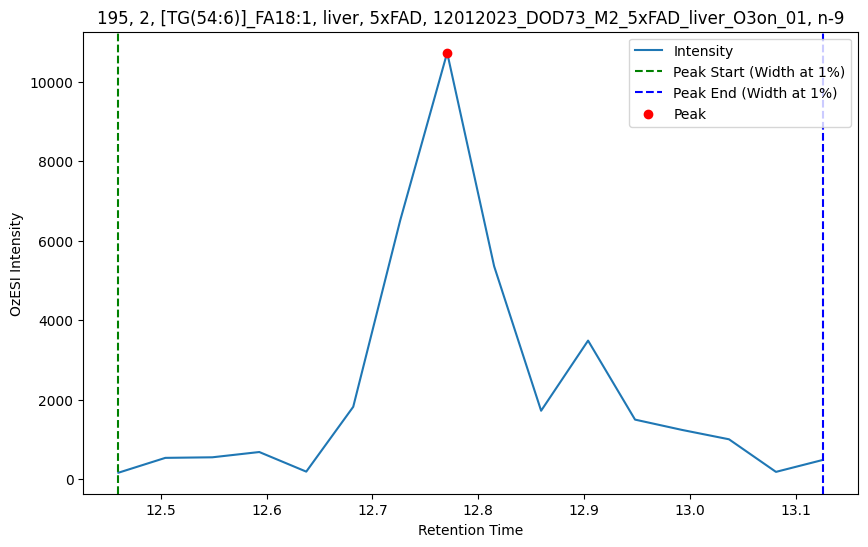

10040.9404296875


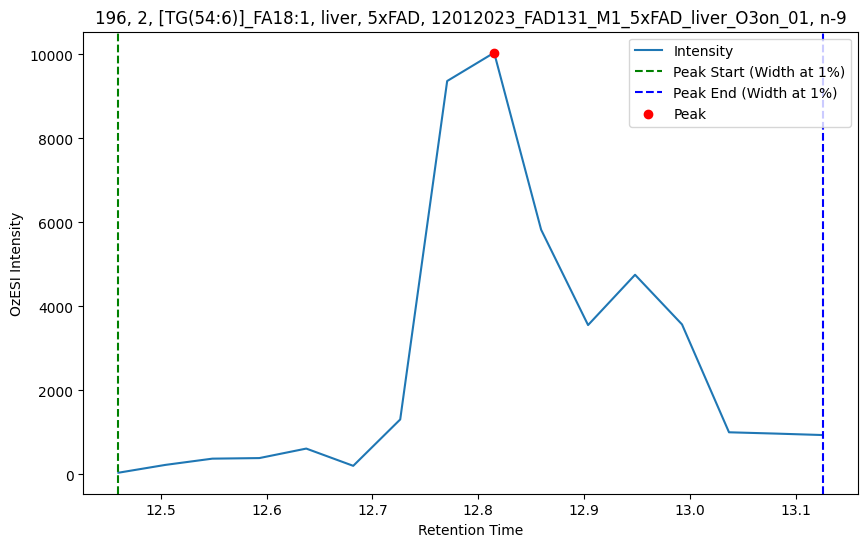

7895.04052734375


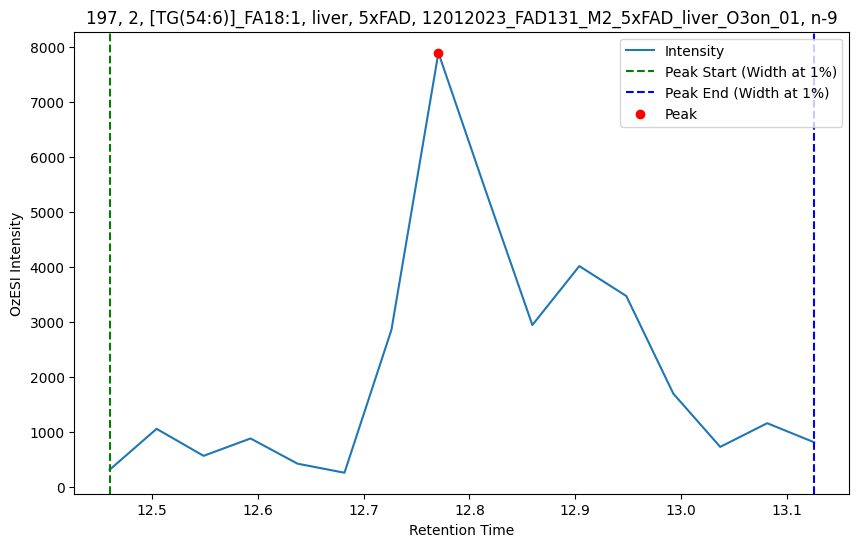

4295.14013671875


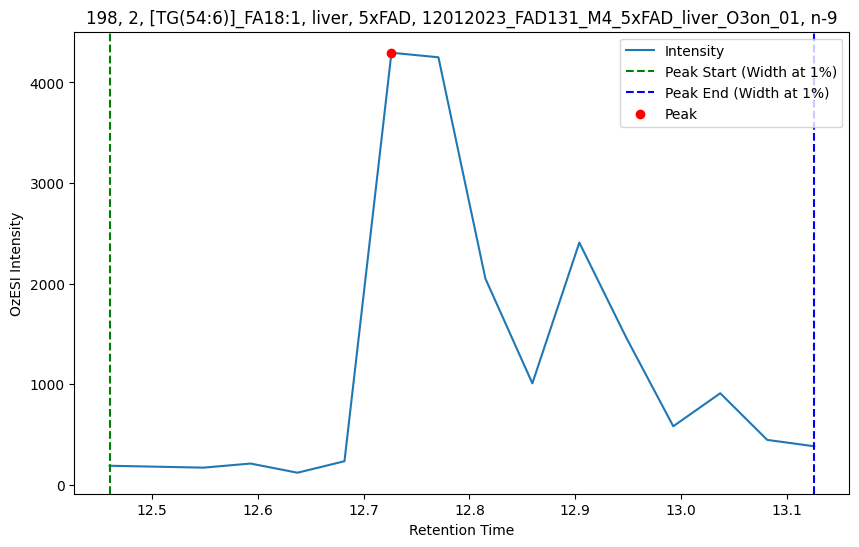

7404.88037109375


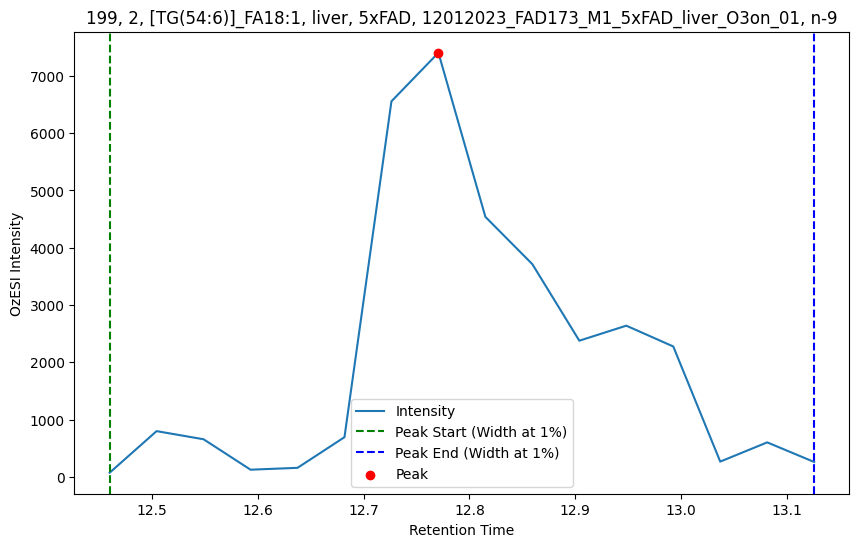

374.1400146484375


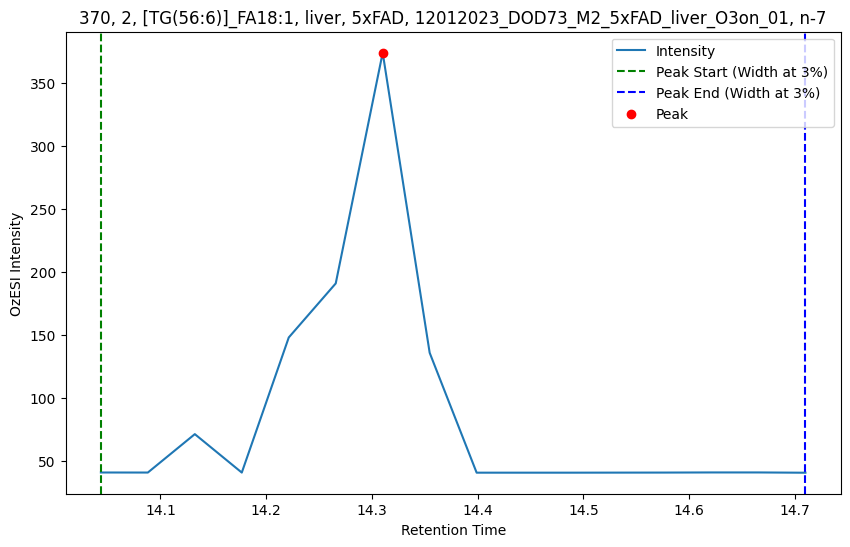

772.5400390625


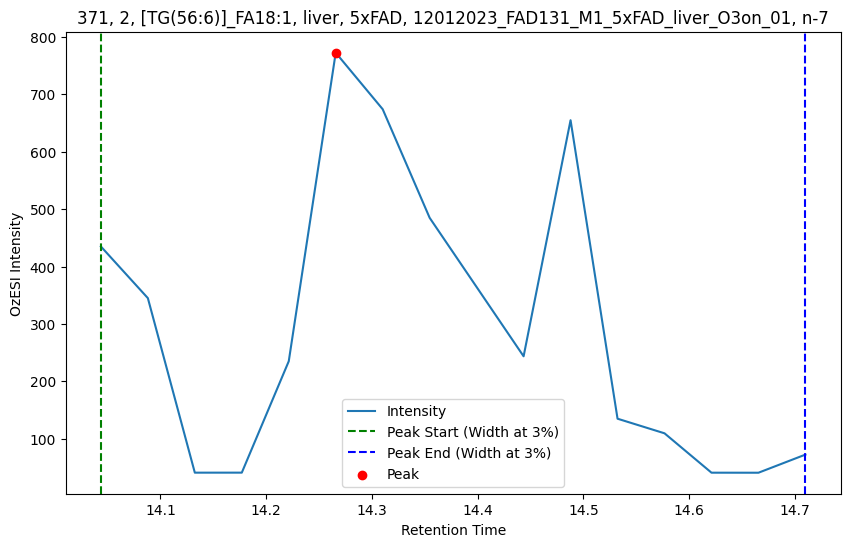

1493.64013671875


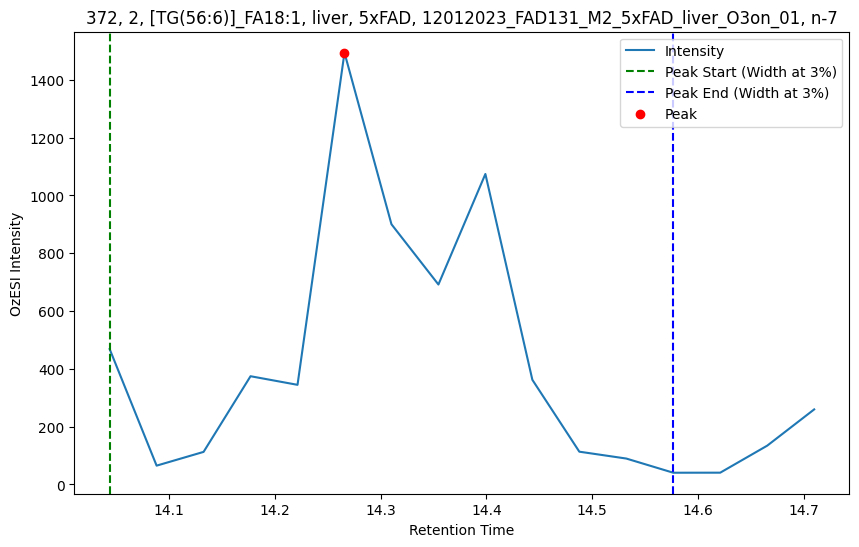

652.8600463867188


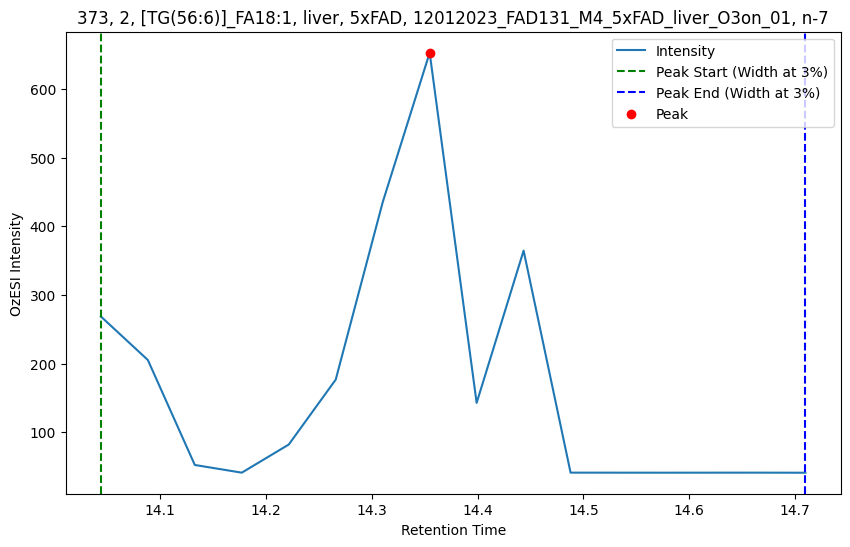

517.0400390625


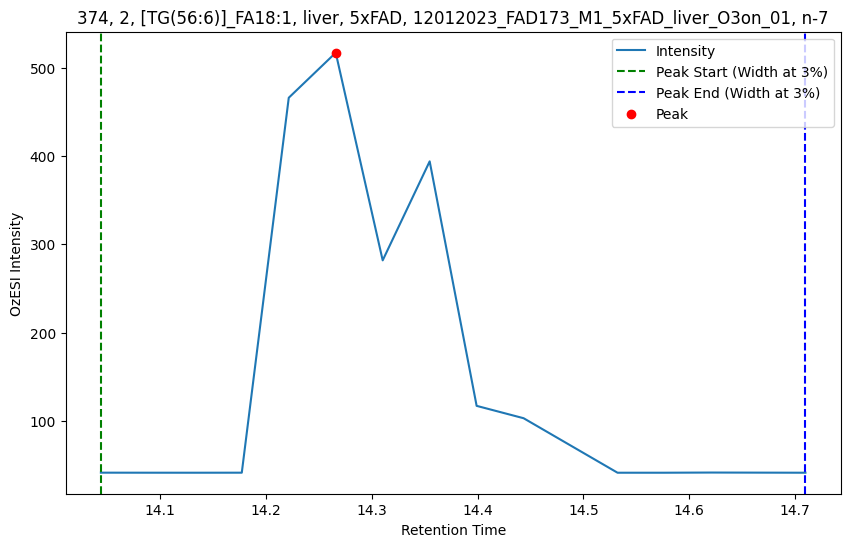

5045.900390625


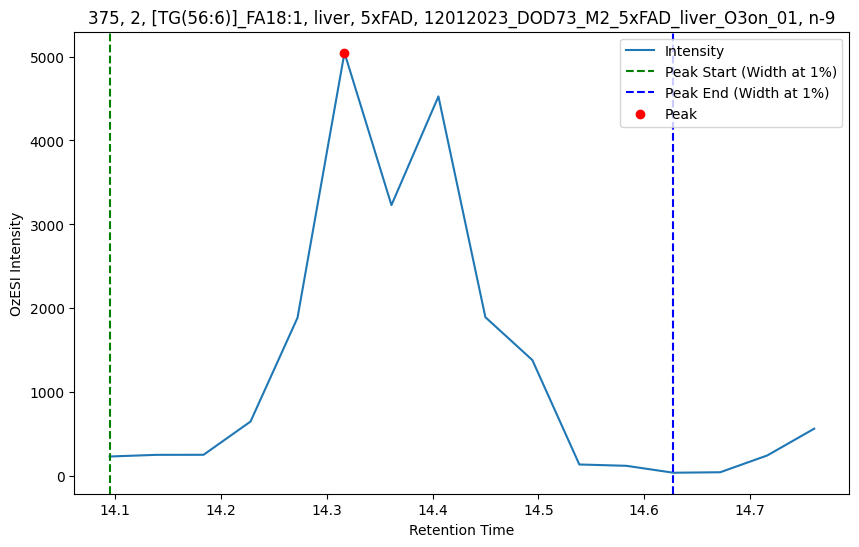

8200.8203125


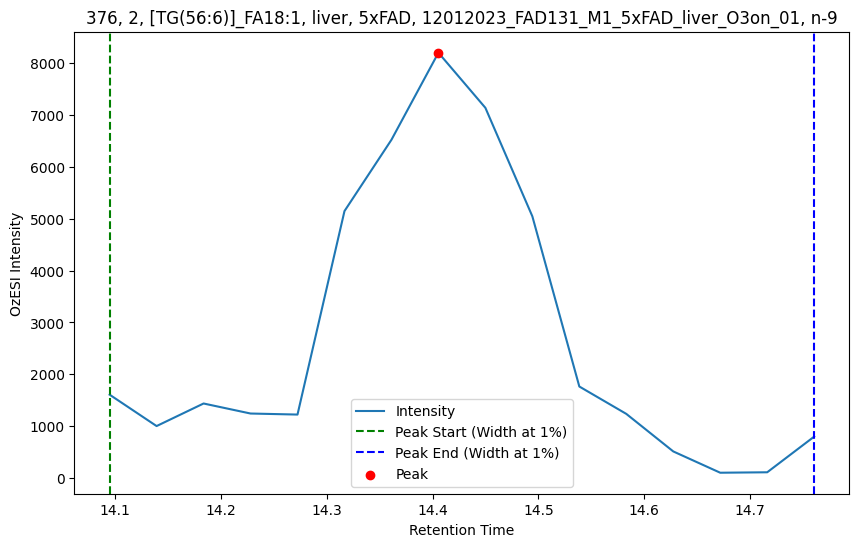

10139.4404296875


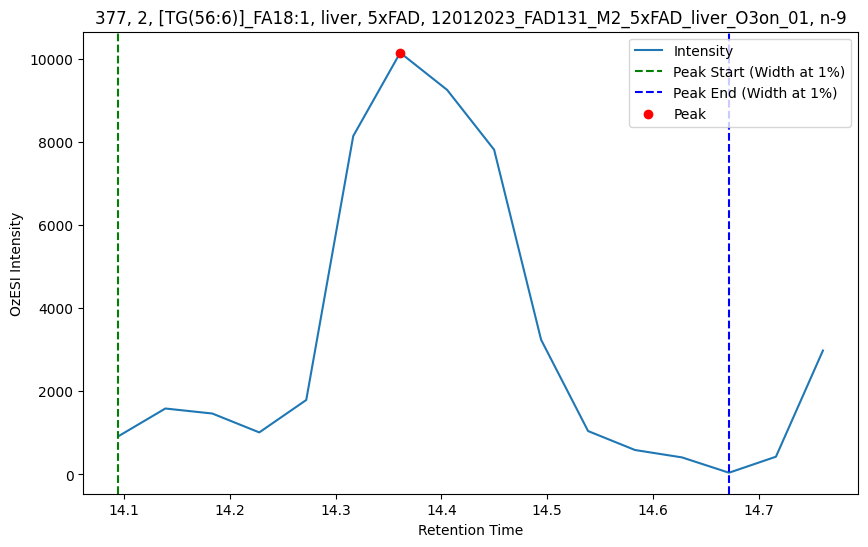

2710.1201171875


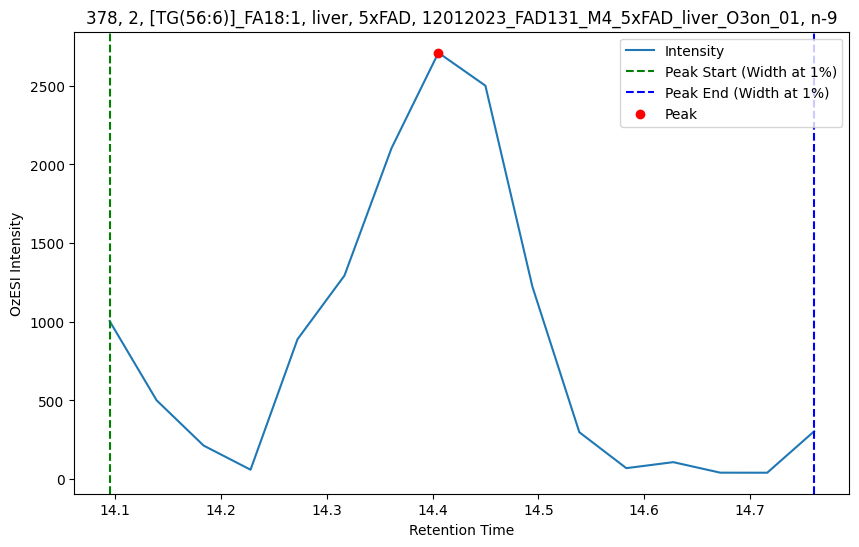

5795.30029296875


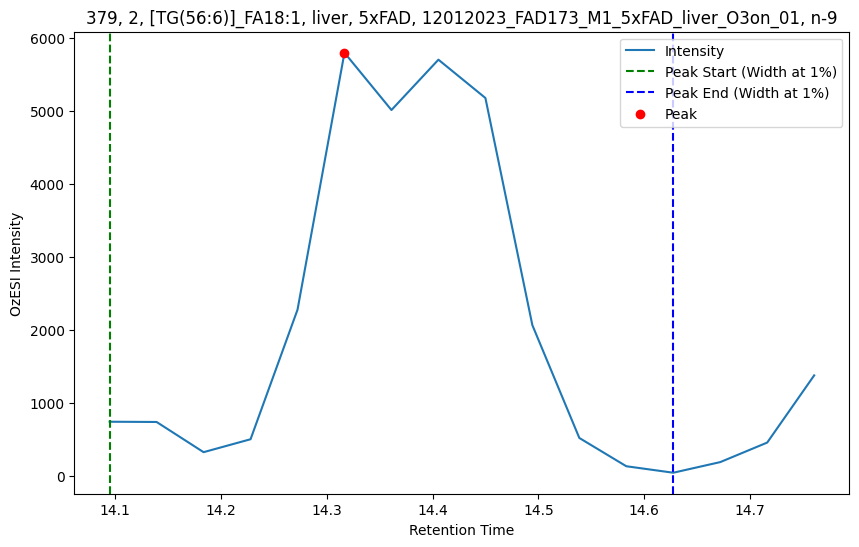

In [37]:
# Assuming d7 is already defined
d11 = d10.copy()

# # Define the directory where you want to save the plots
# save_directory = 'Projects/FaceFats/plots/peak_check/width/'
# os.makedirs(save_directory, exist_ok=True)

# # Setting parameters for peak finding
# peak_width_fraction = 0.03
# peak_width_fraction_large = 0.01
# peak_width_intensity_threshold = 2000

# # Function to calculate peak boundaries
# def calculate_peak_boundaries(intensities, times, peak_max_index):
#     peak_max_intensity = intensities[peak_max_index]
#     if peak_max_intensity > peak_width_intensity_threshold:
#         intensity_threshold = peak_max_intensity * peak_width_fraction_large
#     else:
#         intensity_threshold = peak_max_intensity * peak_width_fraction

#     left_indices = np.where(intensities[:peak_max_index] < intensity_threshold)[0]
#     right_indices = np.where(intensities[peak_max_index:] < intensity_threshold)[0] + peak_max_index

#     peak_start = times[left_indices[-1]] if len(left_indices) > 0 else times[0]
#     peak_end = times[right_indices[0]] if len(right_indices) > 0 else times[-1]

#     return peak_start, peak_end

# def plot_peak_and_boundaries(group_data, group, cluster_label, save_dir, peak_width_fraction=0.2):
    
#     times = group_data['Retention_Time'].values
#     intensities = group_data['OzESI_Intensity'].values
#     peak_max_index = np.argmax(intensities)
#     peak_max_intensity = intensities[peak_max_index]
#     print(peak_max_intensity)
#     peak_start, peak_end = calculate_peak_boundaries(intensities, times, peak_max_index)

#     # Extract additional information for the title
#     lipid = group_data.iloc[0]['Lipid']
#     biology = group_data.iloc[0]['Biology']
#     genotype = group_data.iloc[0]['Genotype']
#     db = group_data.iloc[0]['db']
#     sample_id = group_data.iloc[0]['Sample_ID']

#     # # Plotting
#     # plt.figure(figsize=(10, 6))
#     # plt.plot(times, intensities, label='Intensity')
#     # plt.scatter(times[peak_max_index], intensities[peak_max_index], color='red', label='Peak', zorder=5)
#     # if peak_max_intensity > peak_width_intensity_threshold:
#     #     plt.axvline(peak_start, color='green', linestyle='--', label=f'Peak Start (Width at {peak_width_fraction_large*100:.0f}%)')
#     #     plt.axvline(peak_end, color='blue', linestyle='--', label=f'Peak End (Width at {peak_width_fraction_large*100:.0f}%)')
#     # else:
#     #     plt.axvline(peak_start, color='green', linestyle='--', label=f'Peak Start (Width at {peak_width_fraction*100:.0f}%)')
#     #     plt.axvline(peak_end, color='blue', linestyle='--', label=f'Peak End (Width at {peak_width_fraction*100:.0f}%)')
#     # plt.xlabel('Retention Time')
#     # plt.ylabel('OzESI Intensity')
#     # plt.title(f'{group}, {cluster_label}, {lipid}, {biology}, {genotype}, {sample_id}, {db}')
#     # plt.legend()

#     # filename = f'{group}, {cluster_label}, {lipid}, {biology}, {genotype}, {sample_id}, {db}.png'
#     # # plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
#     # # plt.show()
#     # plt.close()

# # Iterating over groups and clusters and plotting peaks
# for (group, cluster_label), group_df in d11.groupby(['Group', 'Cluster_Label']):
#     group_df_sorted = group_df.sort_values(by='Retention_Time')
#     peak_max_index = np.argmax(group_df_sorted['OzESI_Intensity'].values)
#     peak_start, peak_end = calculate_peak_boundaries(group_df_sorted['OzESI_Intensity'].values, 
#                                                      group_df_sorted['Retention_Time'].values, 
#                                                      peak_max_index)

#     # Update d11 with peak boundaries
#     d11.loc[(d11['Group'] == group) & (d11['Cluster_Label'] == cluster_label), 'RT_Start'] = peak_start.round(2)
#     d11.loc[(d11['Group'] == group) & (d11['Cluster_Label'] == cluster_label), 'RT_End'] = peak_end.round(2)

#     # Plot and save peak analysis with the correct peak_width_fraction
#     plot_peak_and_boundaries(group_df_sorted, group, cluster_label, save_directory, peak_width_fraction)

# # Now the plots will use the peak_width_fraction of 0.22 as intended

# # Display the updated DataFrame
# d11.head()




# Adjust new RTs based off peak width % calc

In [53]:
d12 = d11.copy()
d12
# Initialize an empty DataFrame to store the filtered results
filtered_d9 = pd.DataFrame()

# Iterate over each group-cluster pair
for (group, cluster_label), group_df in d12.groupby(['Group', 'Cluster_Label']):
    # Get the RT_Start and RT_End values for the current group-cluster pair
    rt_start = group_df['RT_Start'].iloc[0]
    rt_end = group_df['RT_End'].iloc[0]

    # Filter the DataFrame for rows where Retention_Time is within the start and end window
    within_window = group_df[(group_df['Retention_Time'] >= rt_start) & (group_df['Retention_Time'] <= rt_end)]

    # Append the filtered data to the results DataFrame
    filtered_d9 = pd.concat([filtered_d9, within_window])

# Assign the filtered DataFrame back to d12
d12 = filtered_d9

# Display the filtered DataFrame
d12


Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
1          722.7        547.5       13.672017        40.880001   
2          722.7        547.5       13.716417        41.060001   
3          722.7        547.5       13.760833        41.200005   
4          722.7        547.5       13.805233        40.900002   
5          722.7        547.5       13.849650       142.640015   
...          ...          ...             ...              ...   
1907       814.7        625.5       14.449917      5175.280273   
1908       814.7        625.5       14.494317      2062.900146   
1909       814.7        625.5       14.538717       517.380066   
1910       814.7        625.5       14.583133       129.980011   
1911       814.7        625.5       14.627533        41.220001   

                                   Sample_ID      Transition    db  \
1      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
2      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
3      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
4      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
5      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
...                                      ...             ...   ...   
1907  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1908  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1909  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1910  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1911  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   

                  Lipid  Cluster_Label Biology Genotype     FAC        TG  \
1     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
2     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
3     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
4     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
5     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
...                 ...            ...     ...      ...     ...       ...   
1907  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1908  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1909  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1910  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1911  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   

      Group  Max_Intensity  Cluster_RT  distance_to_truth  RT_Start  RT_End  
1         0          354.0       13.63           0.327983     13.63   14.29  
2         0          354.0       13.63           0.283583     13.63   14.29  
3         0          354.0       13.63           0.239167     13.63   14.29  
4         0          354.0       13.63           0.194767     13.63   14.29  
5         0          354.0       13.63           0.150350     13.63   14.29  
...     ...            ...         ...                ...       ...     ...  
1907    379         5795.0       14.09           0.019917     14.09   14.63  
1908    379         5795.0       14.09           0.064317     14.09   14.63  
1909    379         5795.0       14.09           0.108717     14.09   14.63  
1910    379         5795.0       14.09           0.153133     14.09   14.63  
1911    379         5795.0       14.09           0.197533     14.09   14.63  

[1076 rows x 19 columns]

# Manually adjust RTs

In [54]:
d13 = d12.copy()
def Peak_Adjust(d13, adjust_specs):
    """
    Adjust the data points and RT_Start, RT_End based on specified start and end 
    Retention_Times for each group in a DataFrame, affecting all cluster labels within the group.
    """
    # Create a copy to work on
    adjusted_df = d13.copy()

    # Iterate through each specification and adjust the data accordingly
    for spec in adjust_specs:
        group = spec['group']
        start_left = spec.get('start_left', None)
        start_right = spec.get('start_right', None)

        # Selecting the specific Group
        group_mask = adjusted_df['Group'] == group

        # Handle 'same' argument
        if start_left == 999:
            start_left = adjusted_df[group_mask]['RT_Start'].iloc[0]
        if start_right == 999:
            start_right = adjusted_df[group_mask]['RT_End'].iloc[0]

        # Iterate over all cluster labels within the group
        for cluster_label in adjusted_df[group_mask]['Cluster_Label'].unique():
            # Selecting the specific Group and Cluster_Label
            mask = group_mask & (adjusted_df['Cluster_Label'] == cluster_label)

            # Update RT_Start and RT_End
            adjusted_df.loc[mask, 'RT_Start'] = start_left
            adjusted_df.loc[mask, 'RT_End'] = start_right

            # Apply the adjustments to Retention_Time
            if start_left is not None:
                adjusted_df.loc[mask, 'Retention_Time'] = adjusted_df.loc[mask, 'Retention_Time'].clip(lower=start_left)
            if start_right is not None:
                adjusted_df.loc[mask, 'Retention_Time'] = adjusted_df.loc[mask, 'Retention_Time'].clip(upper=start_right)

    return adjusted_df

# Define the Peak Retention Time Adjustments for each Group
adjust_specs = [
    #50:3
    {'group': 1, 'start_left': 13.88, 'start_right': 999},
    {'group': 0, 'start_left': 13.7, 'start_right': 14.05},
    #52:5 16:1 double check the 12.9 for theses later
    {'group': 41, 'start_left': 12.6, 'start_right': 999},
    {'group': 42, 'start_left': 12.6, 'start_right': 999},
    {'group': 40, 'start_left': 12.6, 'start_right': 13},
    {'group': 43, 'start_left': 12.6, 'start_right': 12.9},
    {'group': 44, 'start_left': 12.6, 'start_right': 12.9},
    #n12s 45-49
    {'group': 46, 'start_left': 12.6, 'start_right': 999},
    {'group': 47, 'start_left': 12.6, 'start_right': 999},
    {'group': 48, 'start_left': 12.6, 'start_right': 999},
    {'group': 49, 'start_left': 12.6, 'start_right': 999},
    #54:5
    {'group': 162, 'start_left': 13.68, 'start_right': 999},
    # 54:6 191 n7 has two peaks? do all 54:6 have two peaks?



]

d13 = Peak_Adjust(d13, adjust_specs)

# Display a portion of the adjusted DataFrame
d13



Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
1          722.7        547.5       13.700000        40.880001   
2          722.7        547.5       13.716417        41.060001   
3          722.7        547.5       13.760833        41.200005   
4          722.7        547.5       13.805233        40.900002   
5          722.7        547.5       13.849650       142.640015   
...          ...          ...             ...              ...   
1907       814.7        625.5       14.449917      5175.280273   
1908       814.7        625.5       14.494317      2062.900146   
1909       814.7        625.5       14.538717       517.380066   
1910       814.7        625.5       14.583133       129.980011   
1911       814.7        625.5       14.627533        41.220001   

                                   Sample_ID      Transition    db  \
1      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
2      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
3      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
4      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
5      12012023_DOD73_M2_5xFAD_liver_O3on_01  722.7 -> 547.5  n-10   
...                                      ...             ...   ...   
1907  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1908  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1909  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1910  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1911  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   

                  Lipid  Cluster_Label Biology Genotype     FAC        TG  \
1     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
2     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
3     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
4     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
5     [TG(50:3)]_FA18:1              2   liver    5xFAD  FA18:1  TG(50:3)   
...                 ...            ...     ...      ...     ...       ...   
1907  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1908  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1909  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1910  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1911  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   

      Group  Max_Intensity  Cluster_RT  distance_to_truth  RT_Start  RT_End  
1         0          354.0       13.63           0.327983     13.70   14.05  
2         0          354.0       13.63           0.283583     13.70   14.05  
3         0          354.0       13.63           0.239167     13.70   14.05  
4         0          354.0       13.63           0.194767     13.70   14.05  
5         0          354.0       13.63           0.150350     13.70   14.05  
...     ...            ...         ...                ...       ...     ...  
1907    379         5795.0       14.09           0.019917     14.09   14.63  
1908    379         5795.0       14.09           0.064317     14.09   14.63  
1909    379         5795.0       14.09           0.108717     14.09   14.63  
1910    379         5795.0       14.09           0.153133     14.09   14.63  
1911    379         5795.0       14.09           0.197533     14.09   14.63  

[1076 rows x 19 columns]

# Filter d9 df based on manually selected RT_Start and RT_End

In [55]:
d14 = d13.copy()  # Creating d14 DataFrame from the newly filtered d9

# Initialize an empty DataFrame to store the filtered results
filtered_d10 = pd.DataFrame()

# Iterate over each group-cluster pair
for (group, cluster_label), group_df in d14.groupby(['Group', 'Cluster_Label']):
    # Get the RT_Start and RT_End values for the current group-cluster pair
    rt_start = group_df['RT_Start'].iloc[0]
    rt_end = group_df['RT_End'].iloc[0]

    # Filter the DataFrame for rows where Retention_Time is within the start and end window
    within_window = group_df[(group_df['Retention_Time'] >= rt_start) & (group_df['Retention_Time'] <= rt_end)]

    # Append the filtered data to the results DataFrame
    filtered_d10 = pd.concat([filtered_d10, within_window])

# Assign the filtered DataFrame back to d14
d14 = filtered_d10
# Sort d14 DataFrame by 'Retention_Time'
d14= d14.sort_values(by='Retention_Time')

# Display the filtered DataFrame
d14


Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
480        718.6        599.5       12.340100       228.080017   
528        718.6        599.5       12.340117       383.760040   
512        718.6        599.5       12.340133       488.600037   
544        718.6        599.5       12.340150       703.280029   
481        718.6        599.5       12.384517       156.900009   
...          ...          ...             ...              ...   
1818       842.7        625.5       14.709867        41.060001   
1786       842.7        625.5       14.709867        72.360008   
1834       842.7        625.5       14.709883        41.200005   
1865       814.7        625.5       14.716333       109.300011   
1897       814.7        625.5       14.716333        40.820004   

                                   Sample_ID      Transition    db  \
480    12012023_DOD73_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
528   12012023_FAD131_M4_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
512   12012023_FAD131_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
544   12012023_FAD173_M1_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
481    12012023_DOD73_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
...                                      ...             ...   ...   
1818  12012023_FAD131_M4_5xFAD_liver_O3on_01  842.7 -> 625.5   n-7   
1786  12012023_FAD131_M1_5xFAD_liver_O3on_01  842.7 -> 625.5   n-7   
1834  12012023_FAD173_M1_5xFAD_liver_O3on_01  842.7 -> 625.5   n-7   
1865  12012023_FAD131_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1897  12012023_FAD131_M4_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   

                  Lipid  Cluster_Label Biology Genotype     FAC        TG  \
480   [TG(52:5)]_FA16:1              0   liver    5xFAD  FA16:1  TG(52:5)   
528   [TG(52:5)]_FA16:1              0   liver    5xFAD  FA16:1  TG(52:5)   
512   [TG(52:5)]_FA16:1              0   liver    5xFAD  FA16:1  TG(52:5)   
544   [TG(52:5)]_FA16:1              0   liver    5xFAD  FA16:1  TG(52:5)   
481   [TG(52:5)]_FA16:1              0   liver    5xFAD  FA16:1  TG(52:5)   
...                 ...            ...     ...      ...     ...       ...   
1818  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1786  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1834  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1865  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1897  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   

      Group  Max_Intensity  Cluster_RT  distance_to_truth  RT_Start  RT_End  
480      45          314.0       11.67           0.409900     12.34   13.01  
528      48          384.0       12.34           0.409883     12.34   13.01  
512      47         1127.0       11.67           0.409867     12.34   13.01  
544      49          703.0       11.67           0.409850     12.34   13.01  
481      45          314.0       11.67           0.365483     12.34   13.01  
...     ...            ...         ...                ...       ...     ...  
1818    373          653.0       14.04           0.279867     14.04   14.71  
1786    371          773.0       14.04           0.279867     14.04   14.71  
1834    374          517.0       14.04           0.279883     14.04   14.71  
1865    376         8201.0       14.09           0.286333     14.09   14.76  
1897    378         2710.0       14.09           0.286333     14.09   14.76  

[1076 rows x 19 columns]

# Plot the manually adjusted RTs to confirm peaks are correct

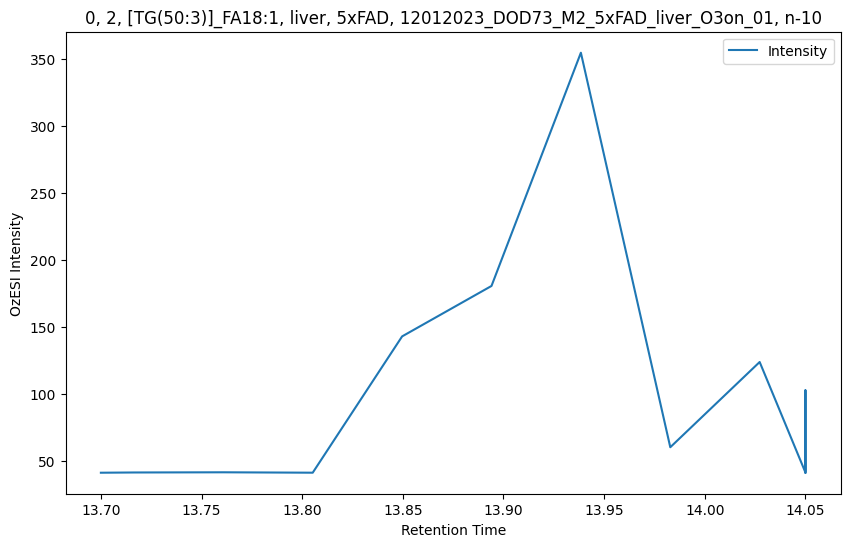

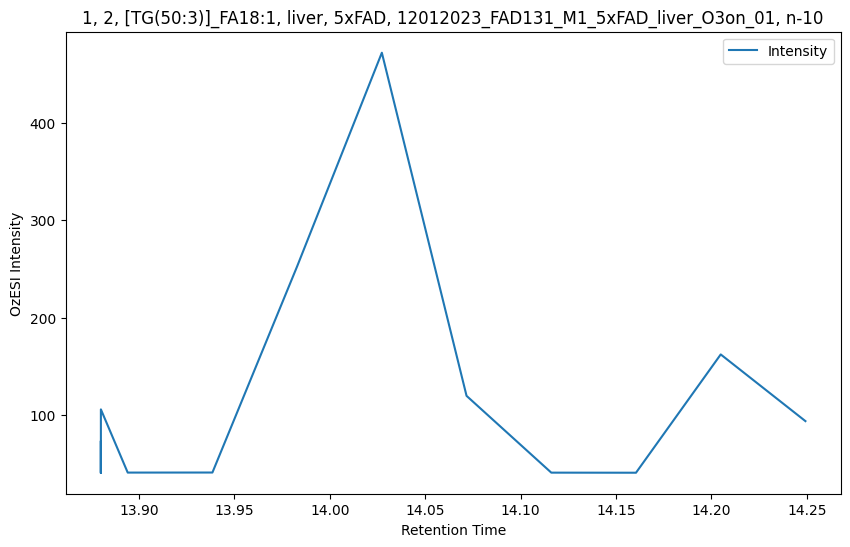

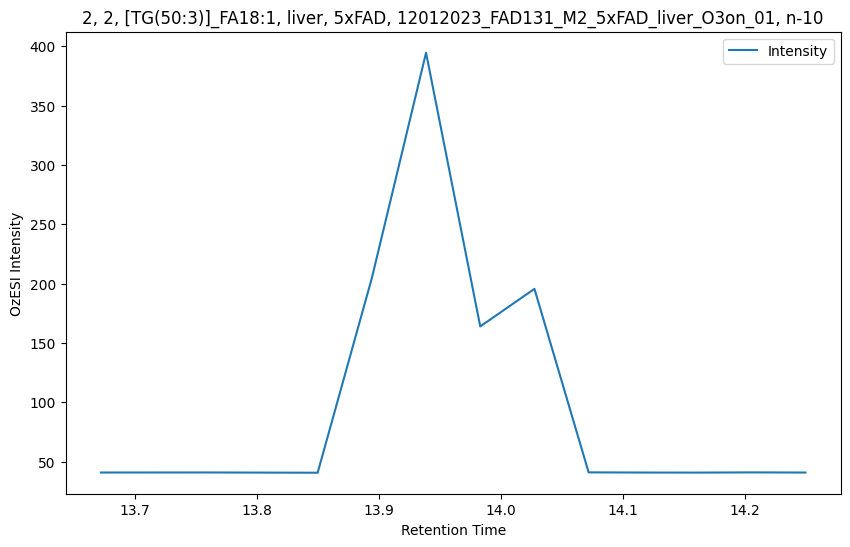

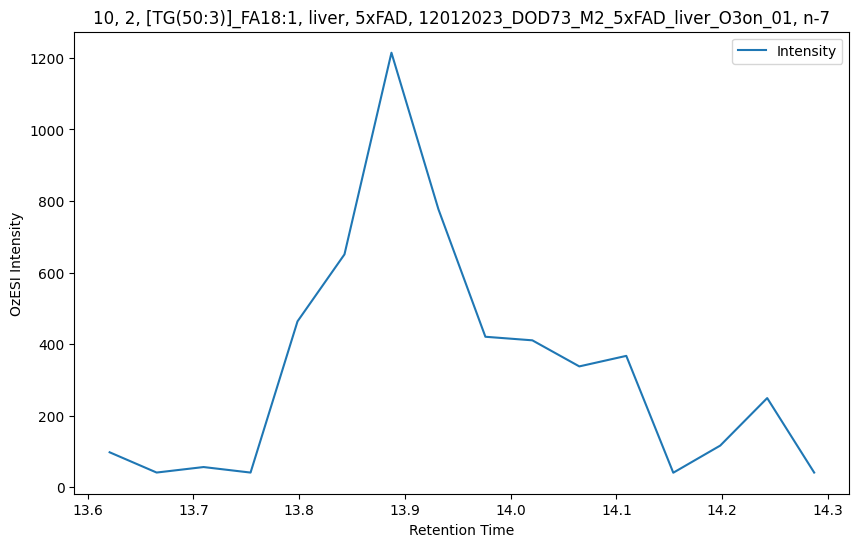

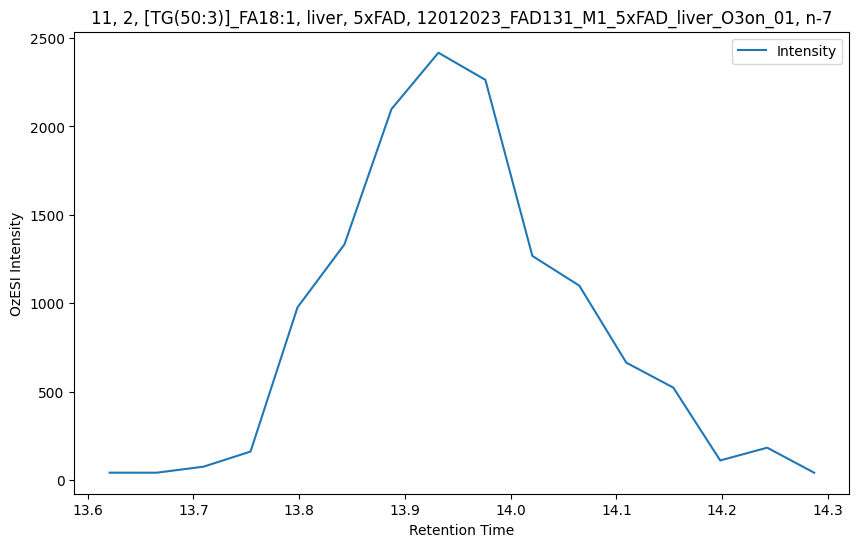

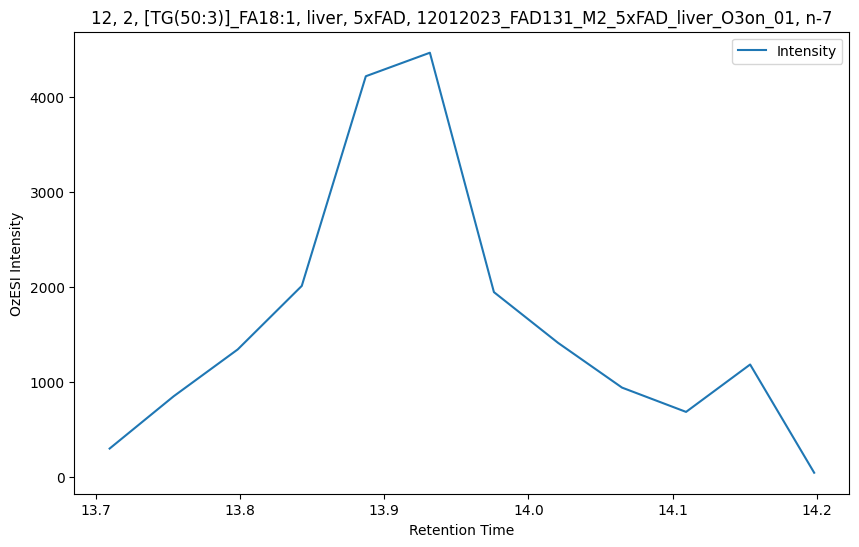

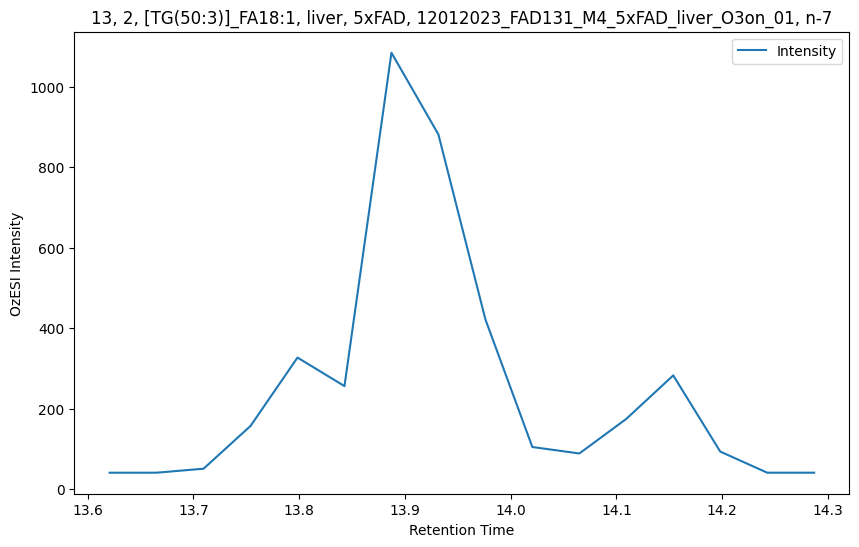

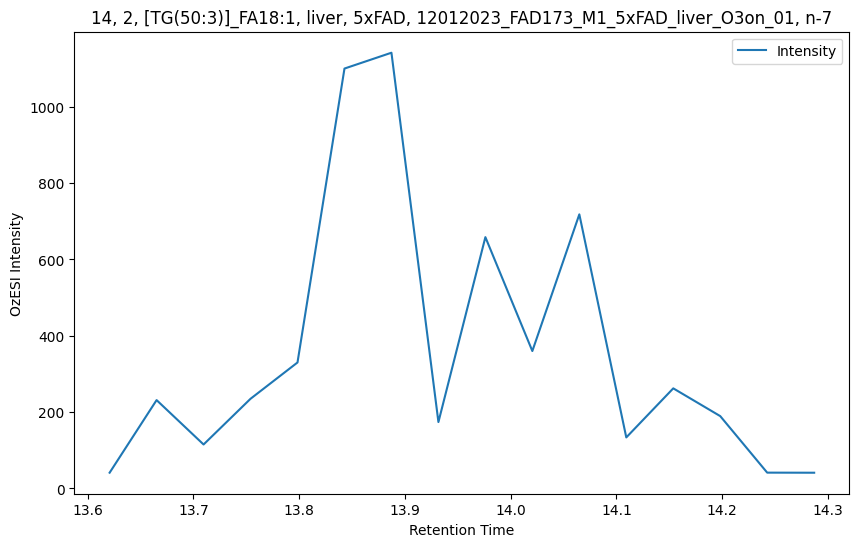

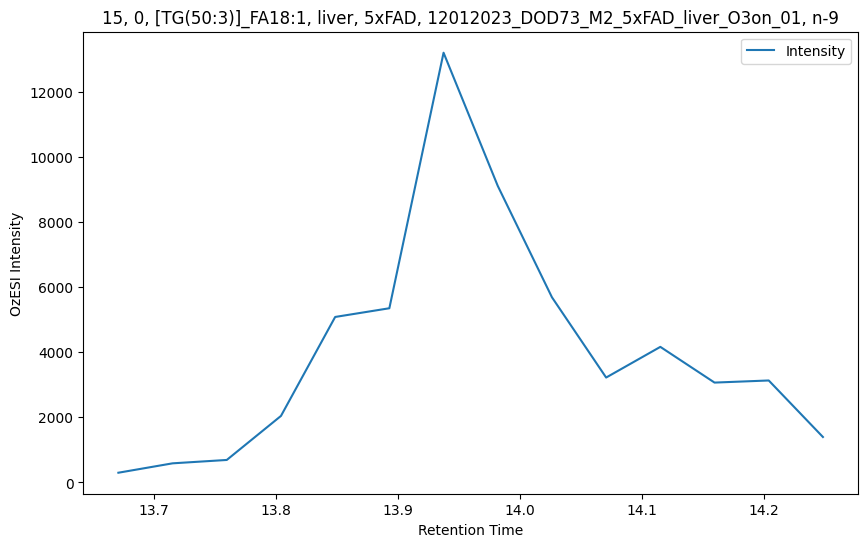

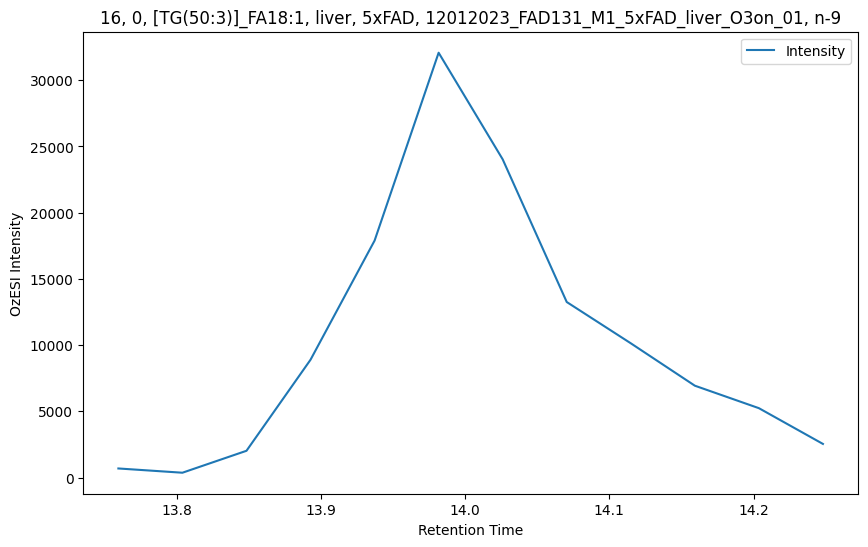

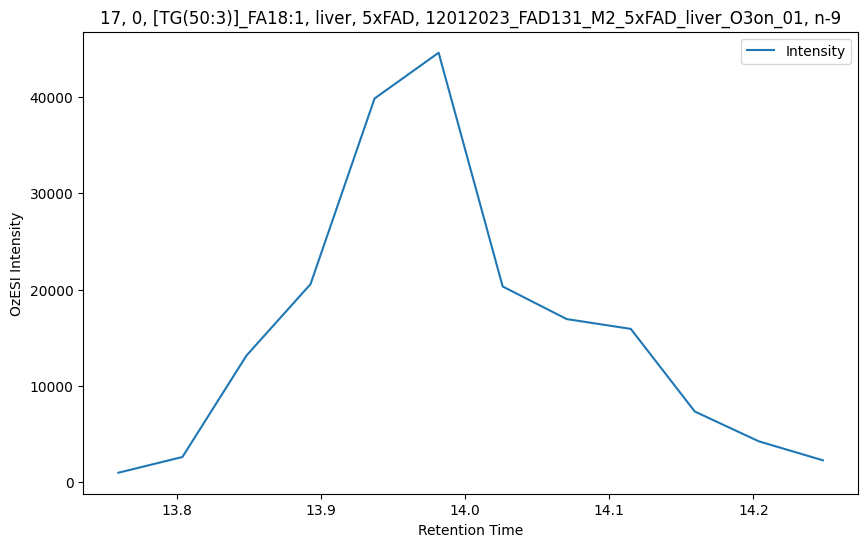

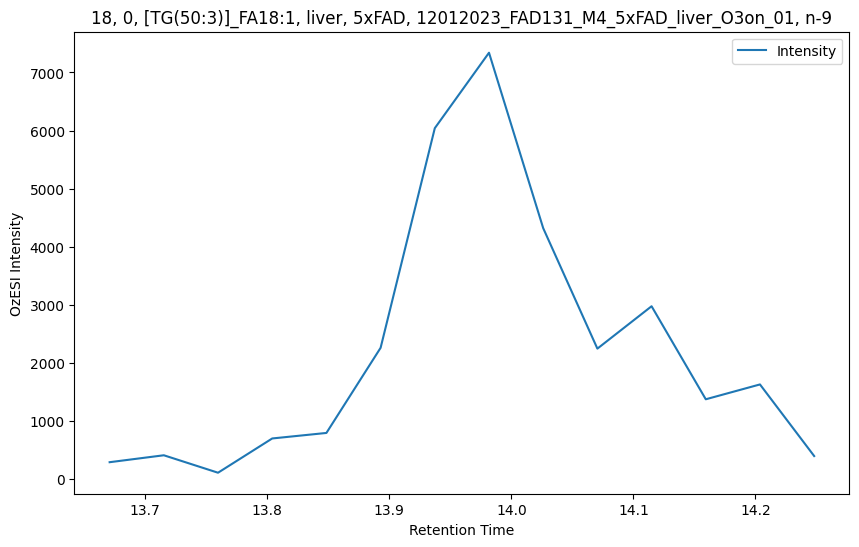

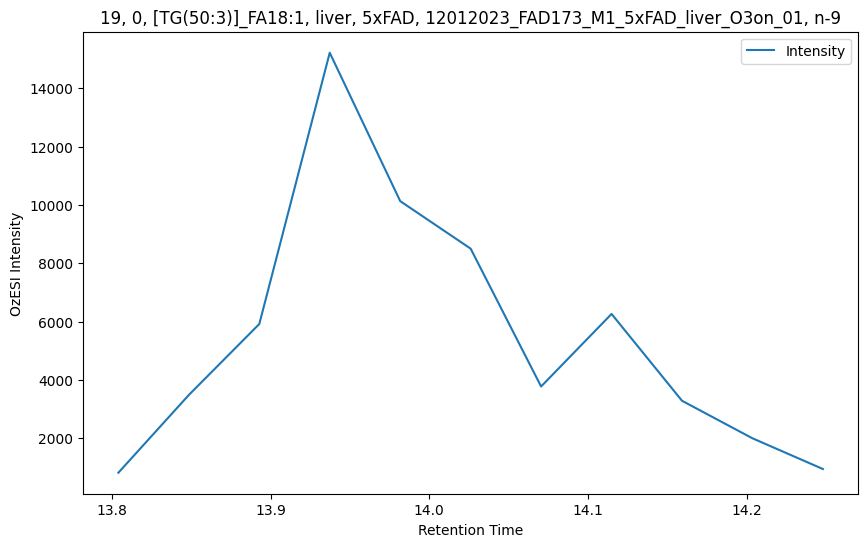

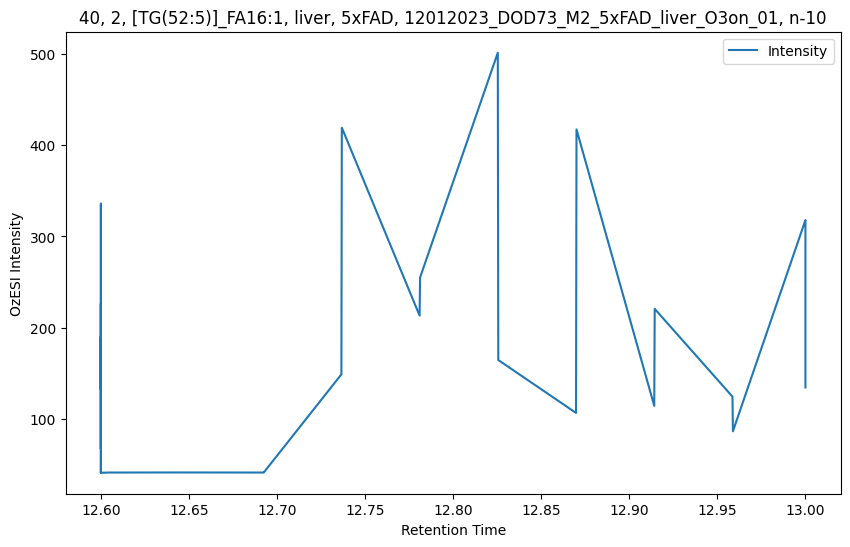

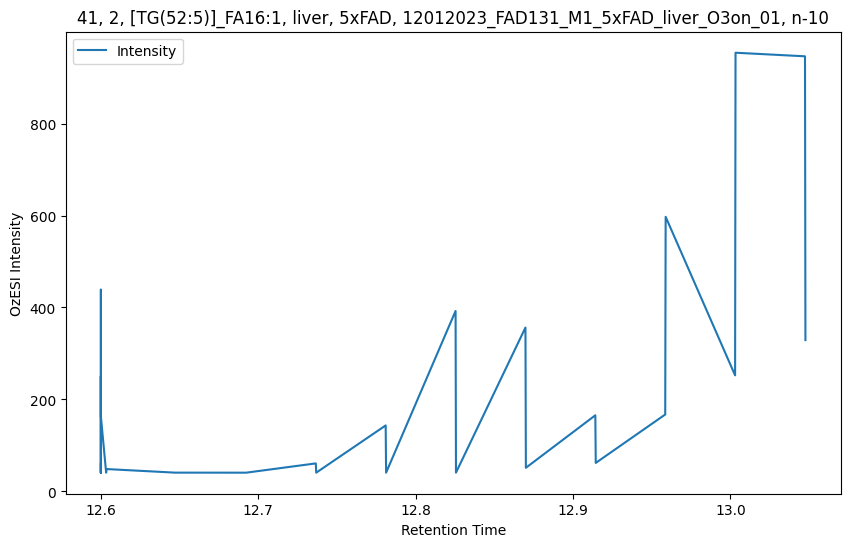

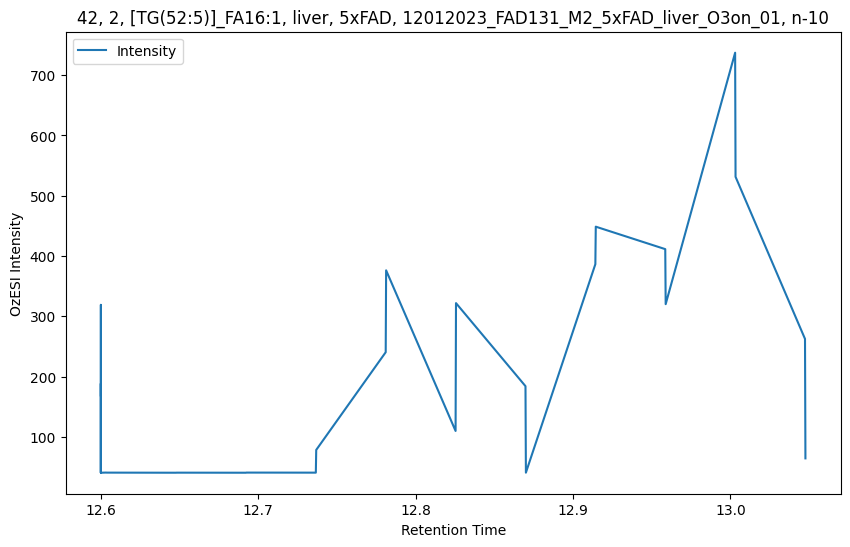

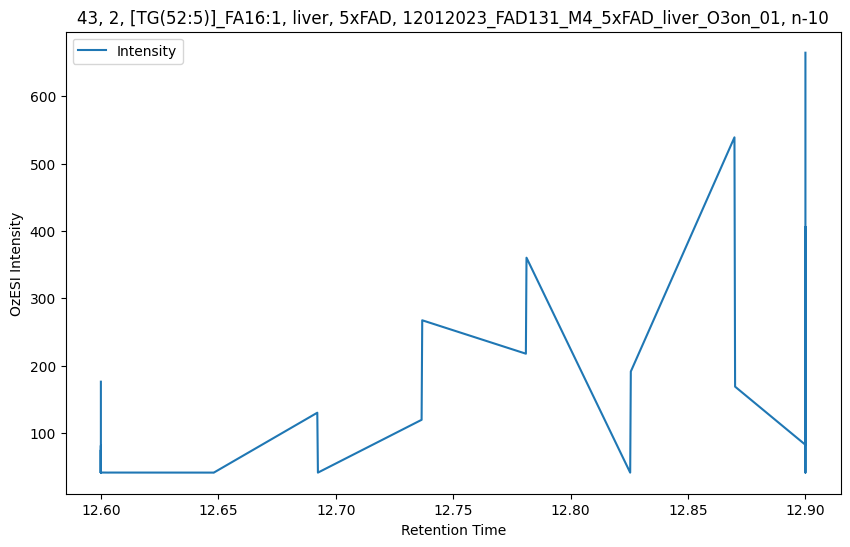

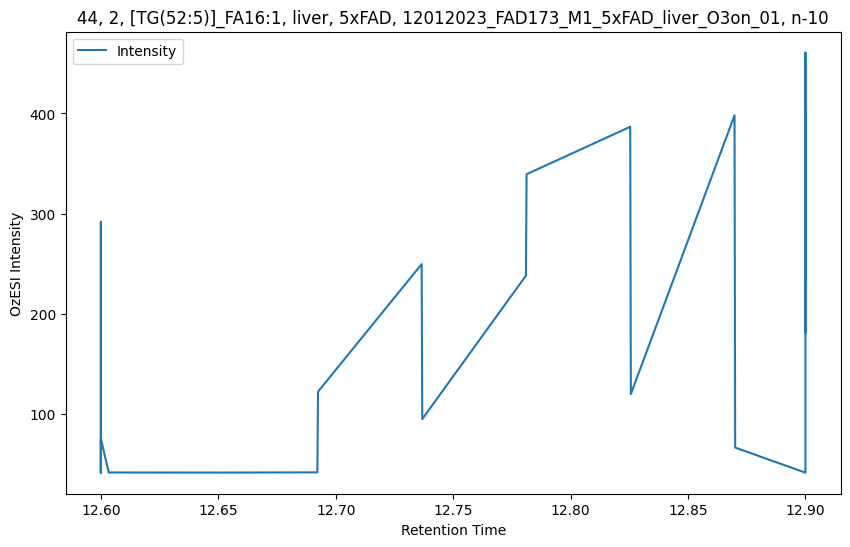

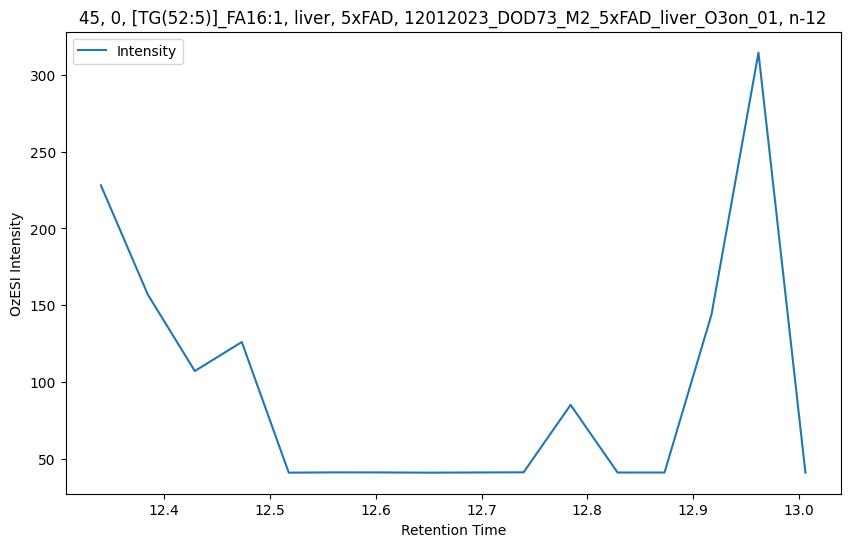

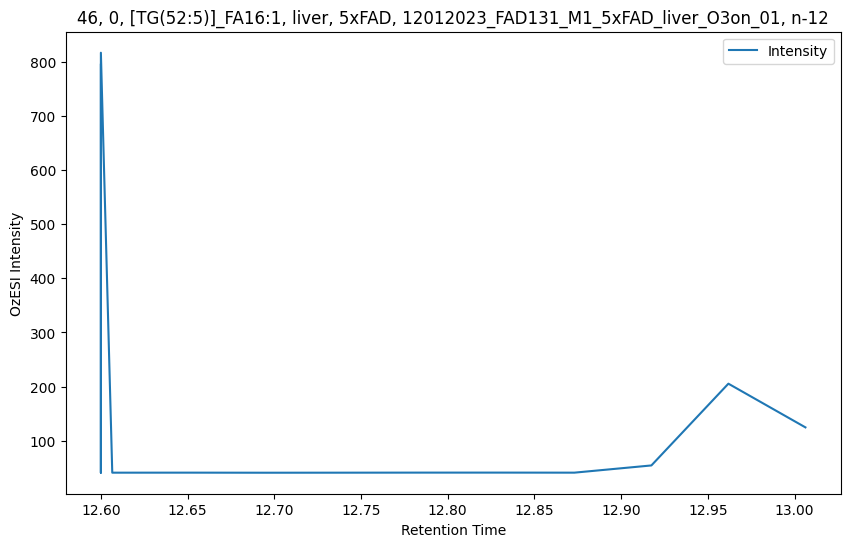

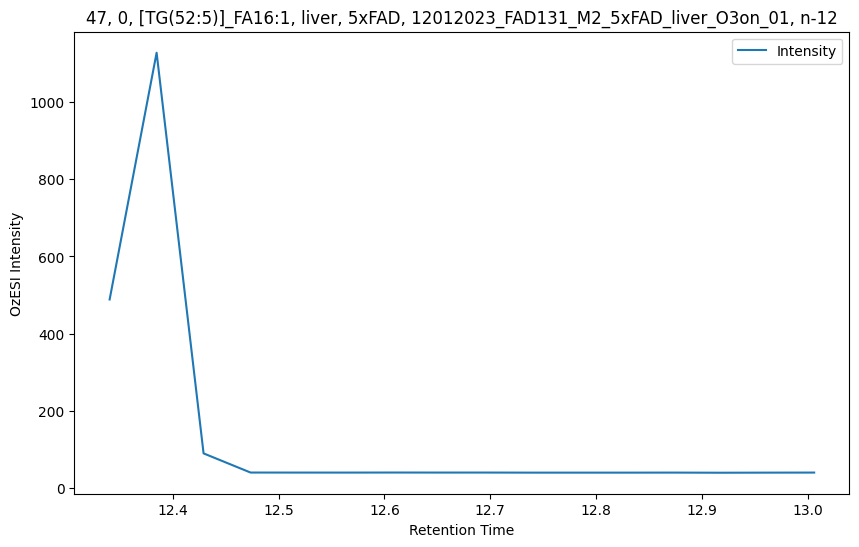

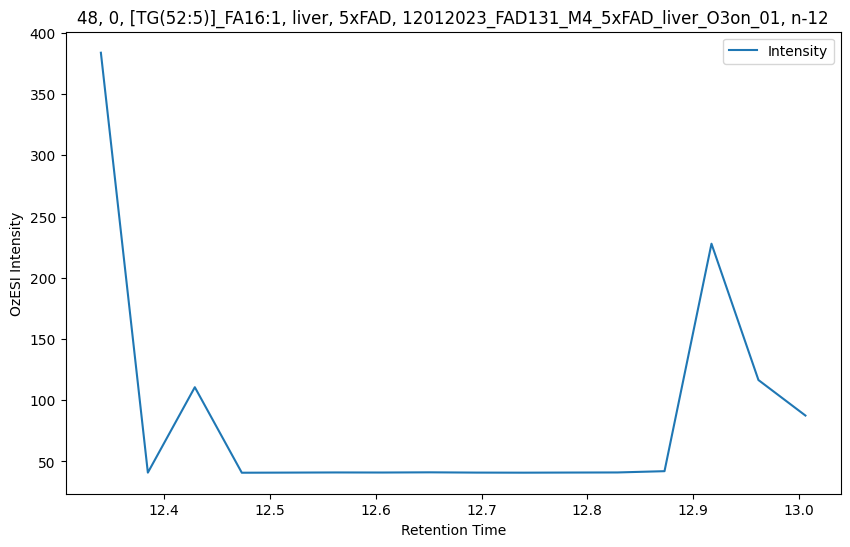

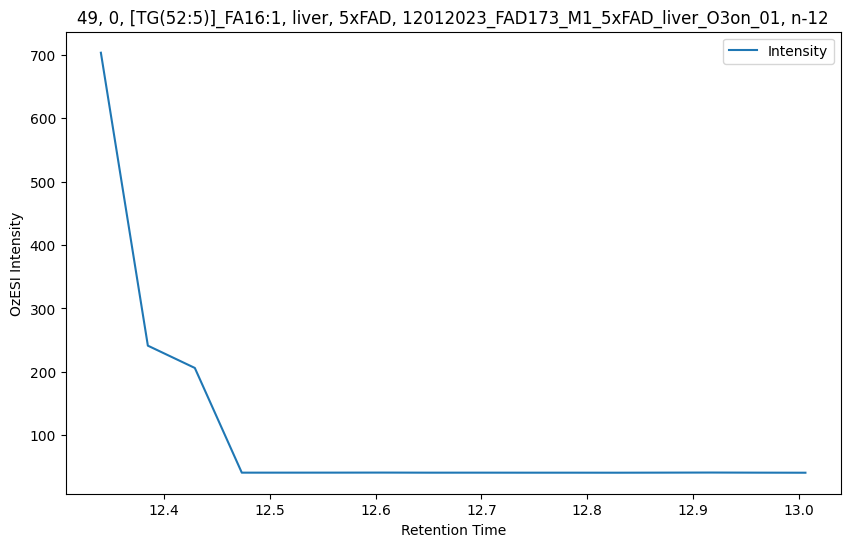

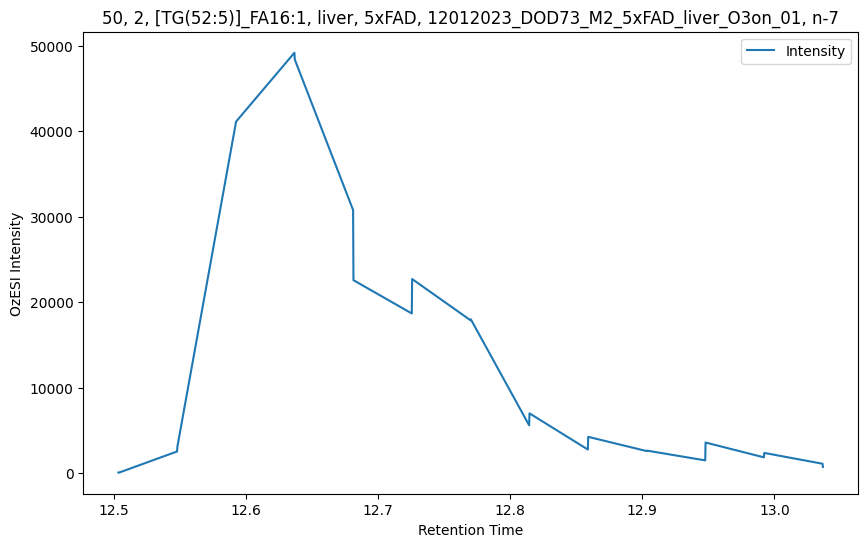

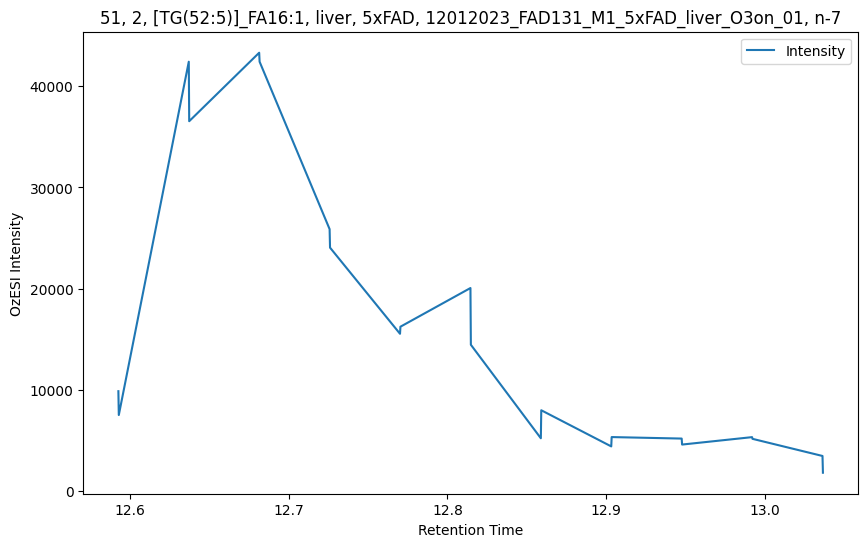

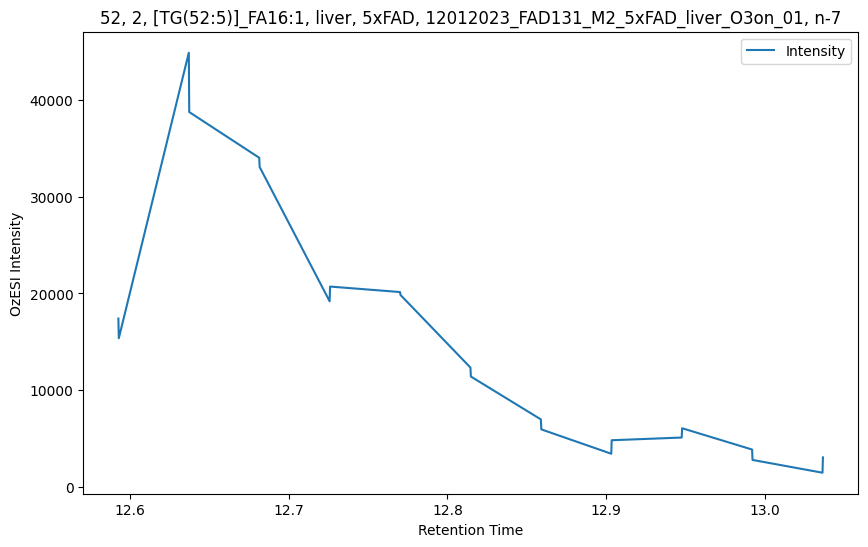

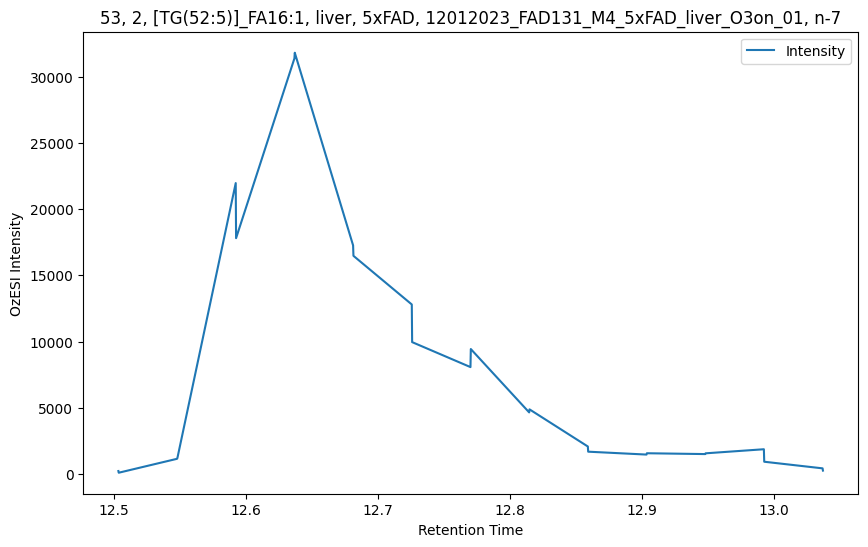

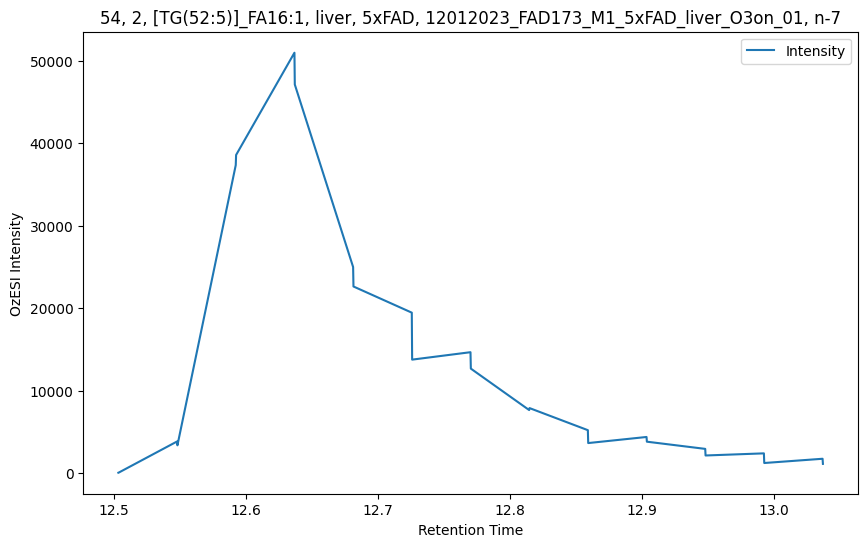

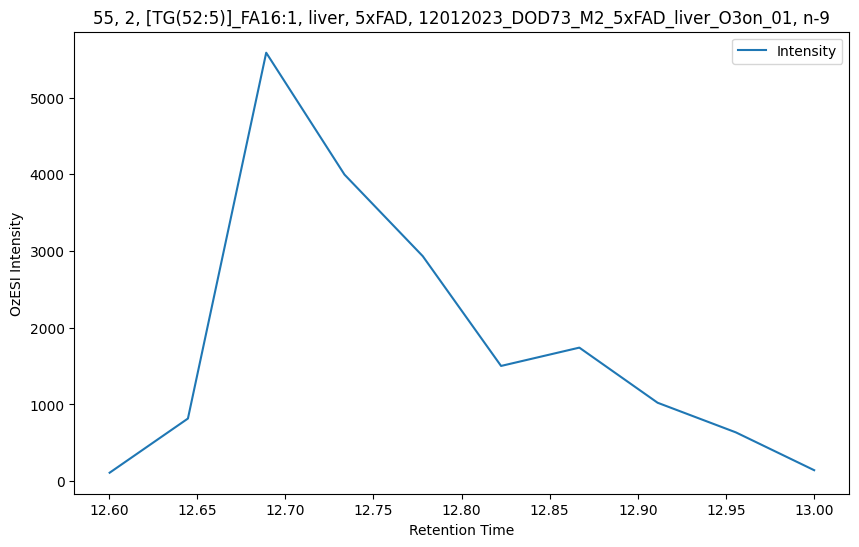

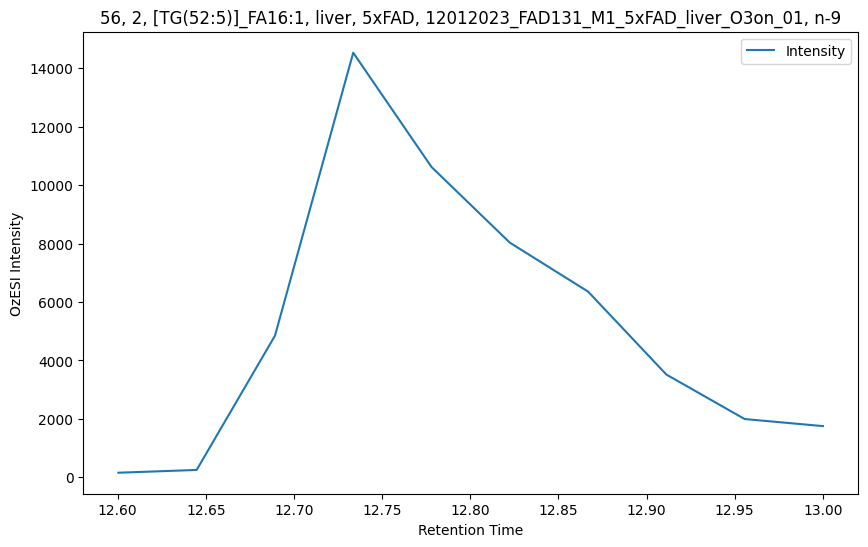

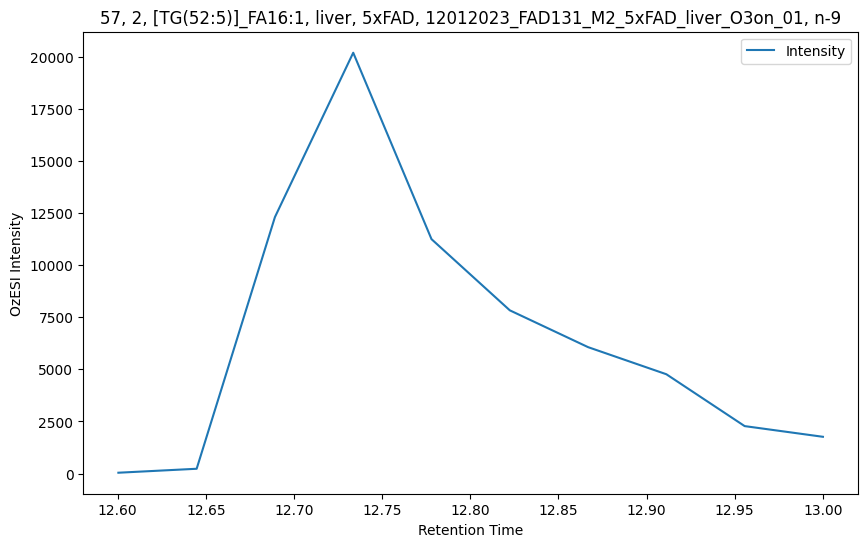

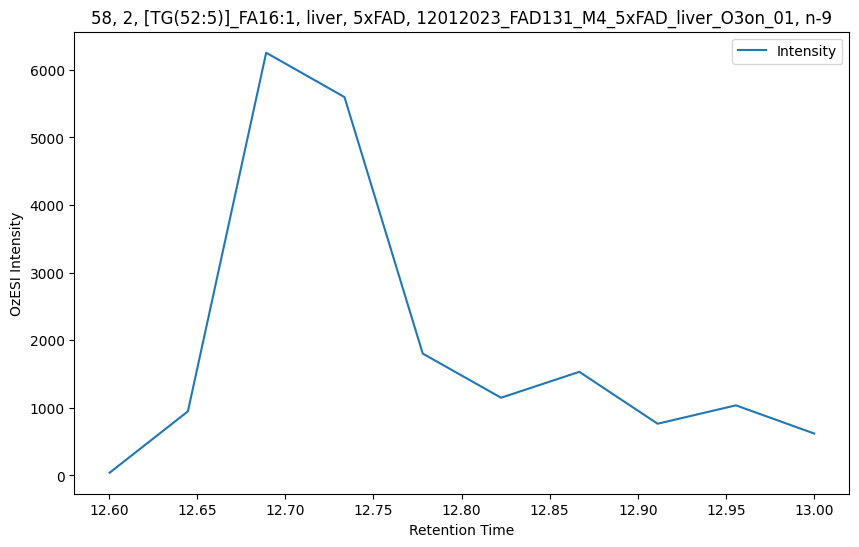

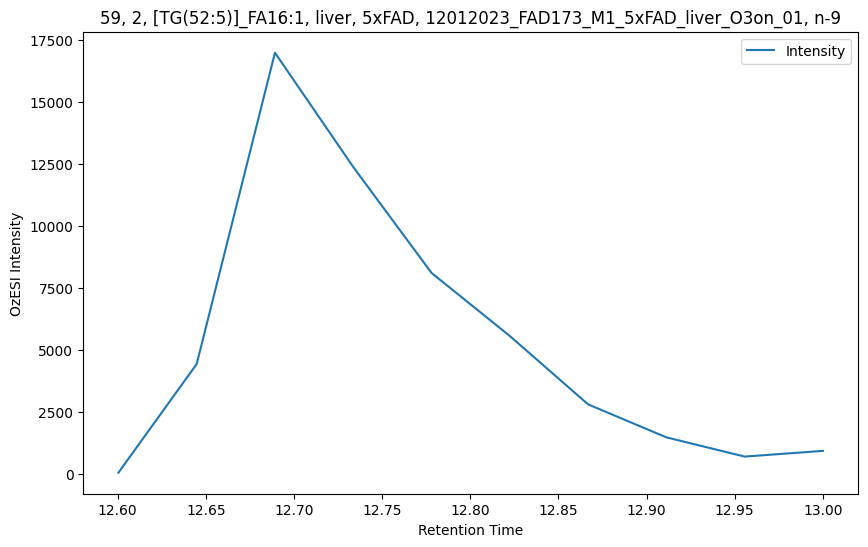

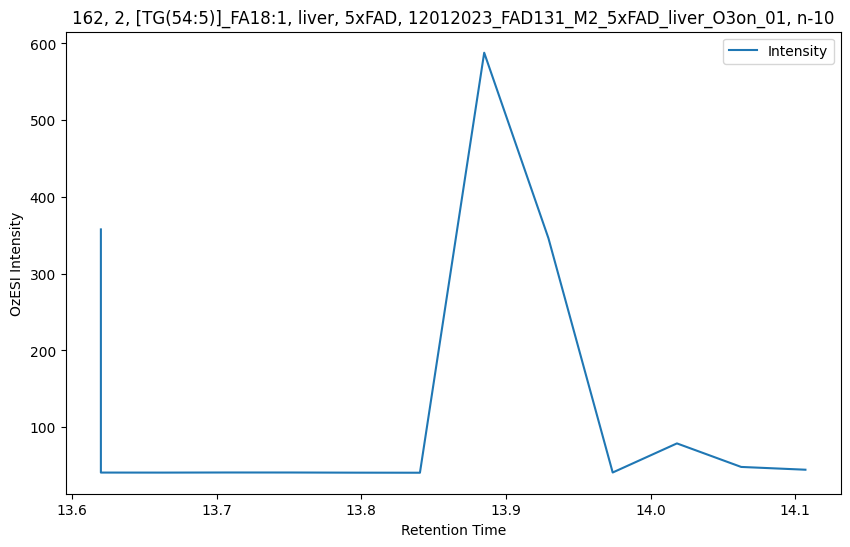

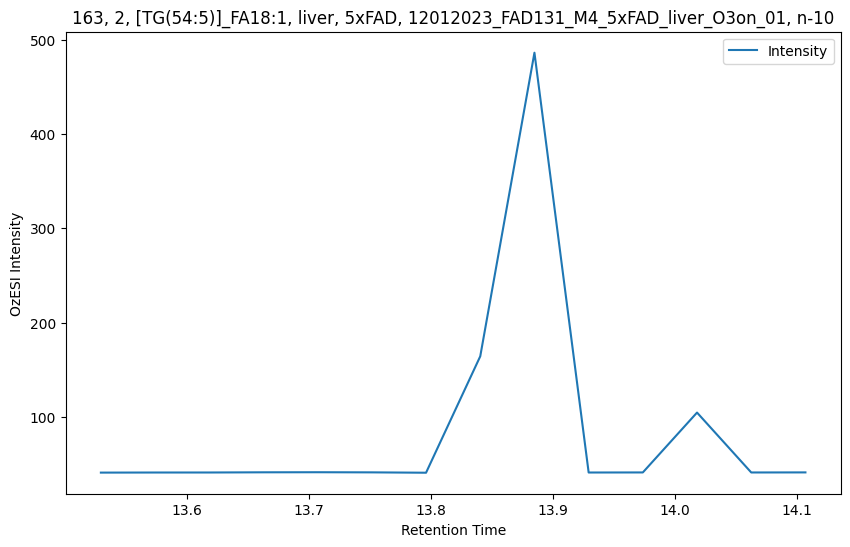

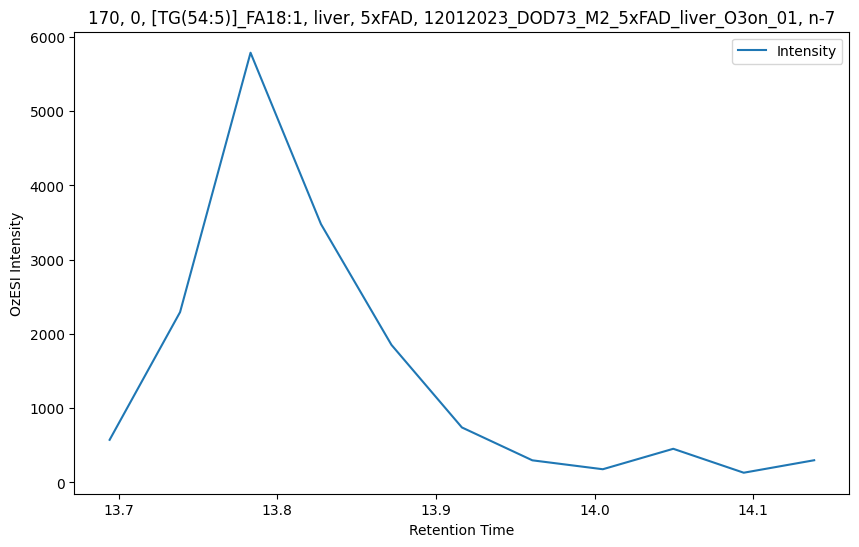

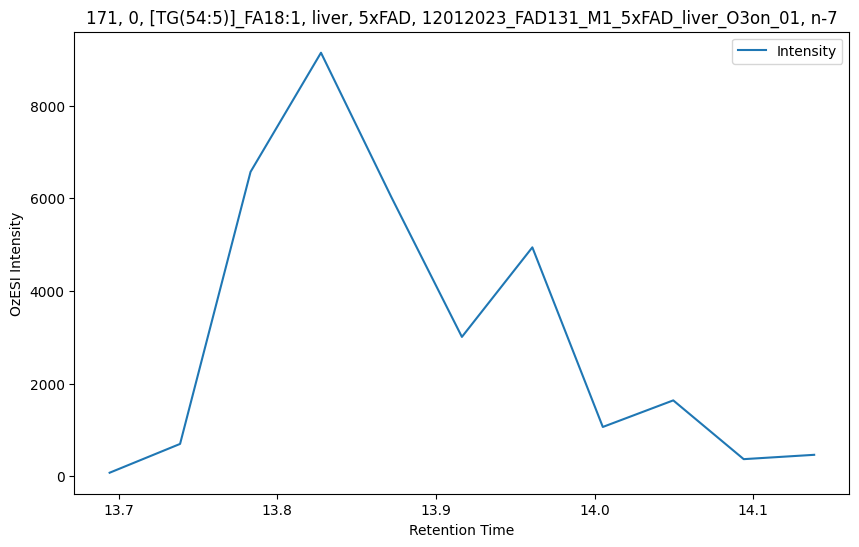

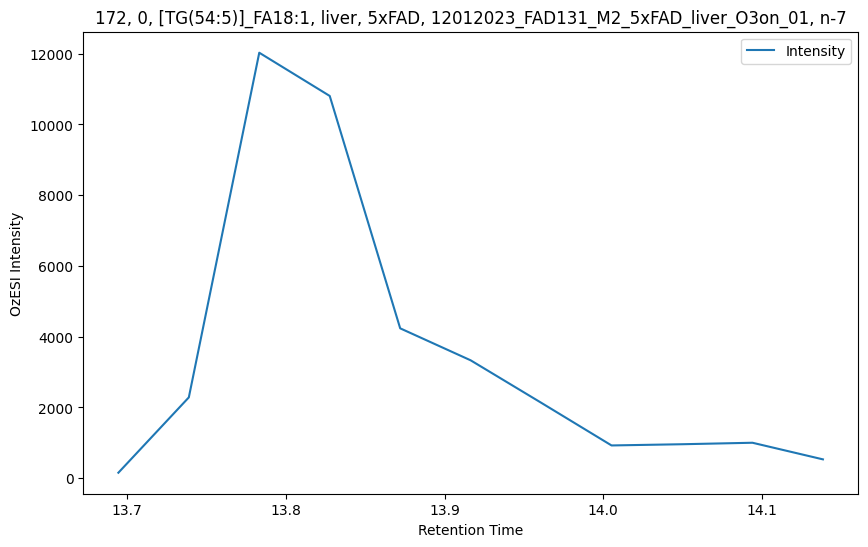

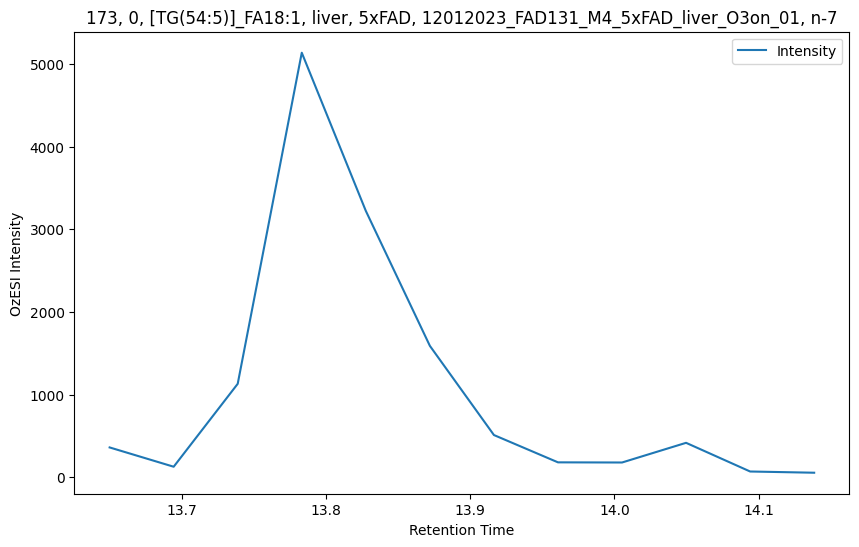

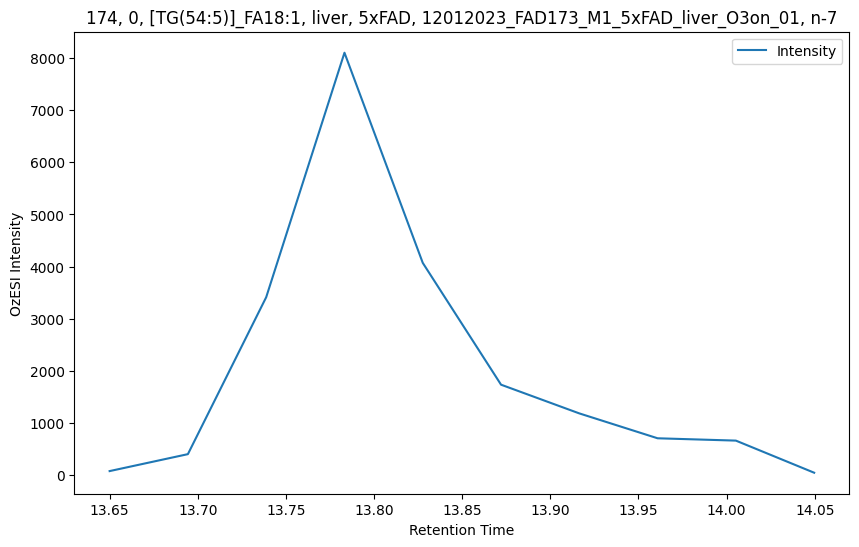

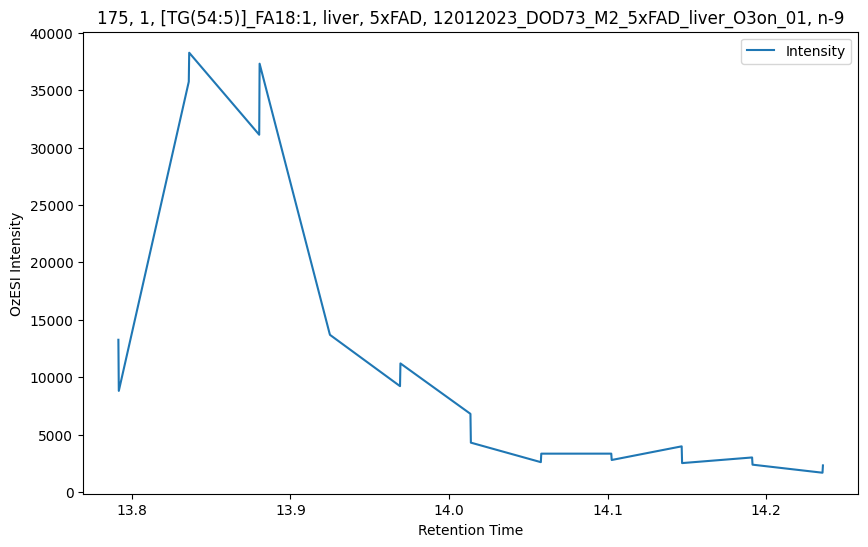

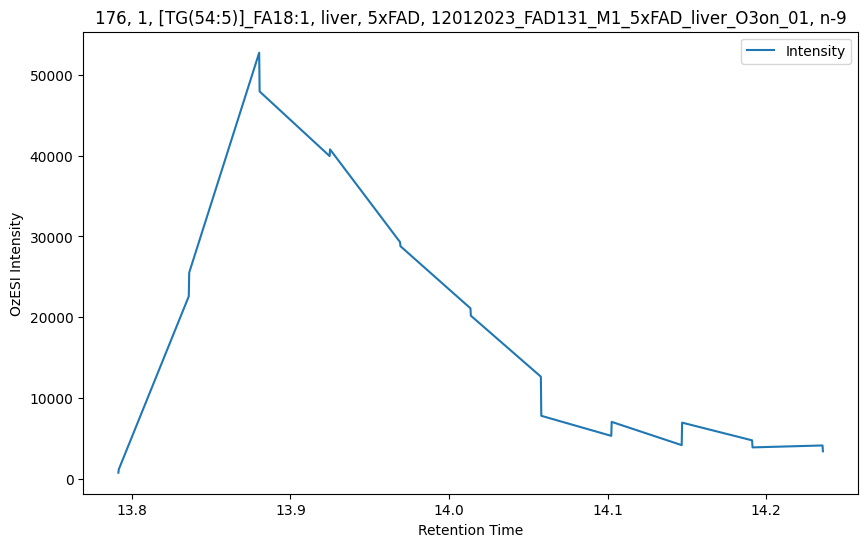

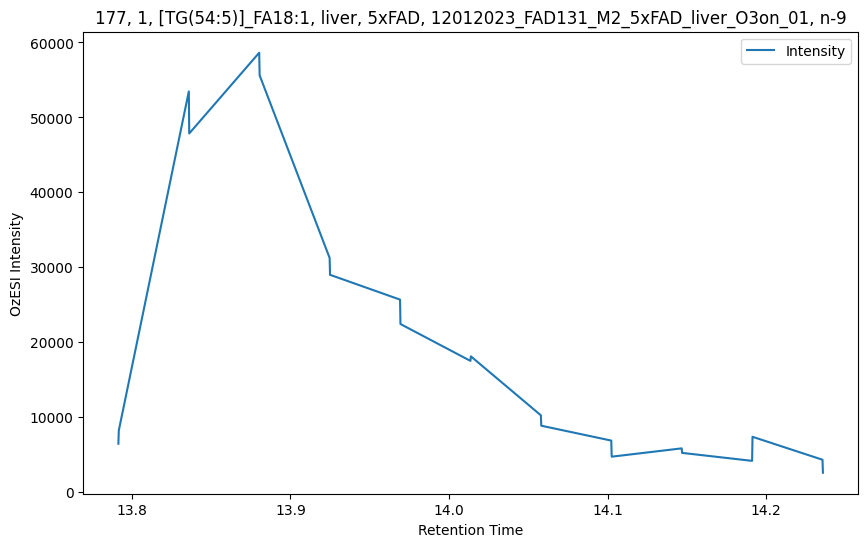

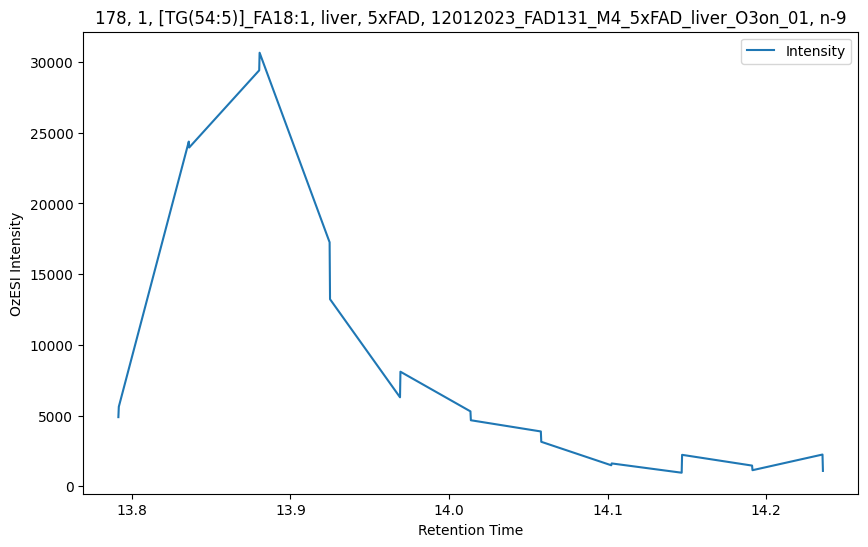

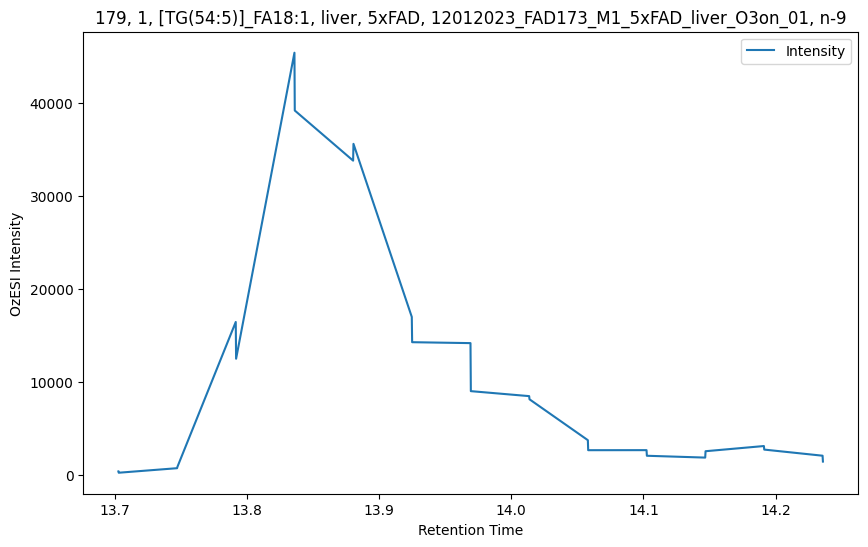

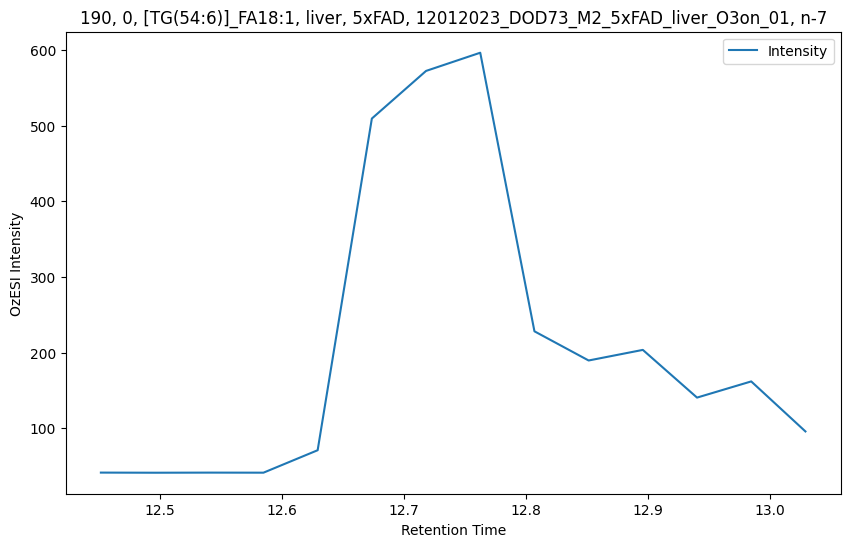

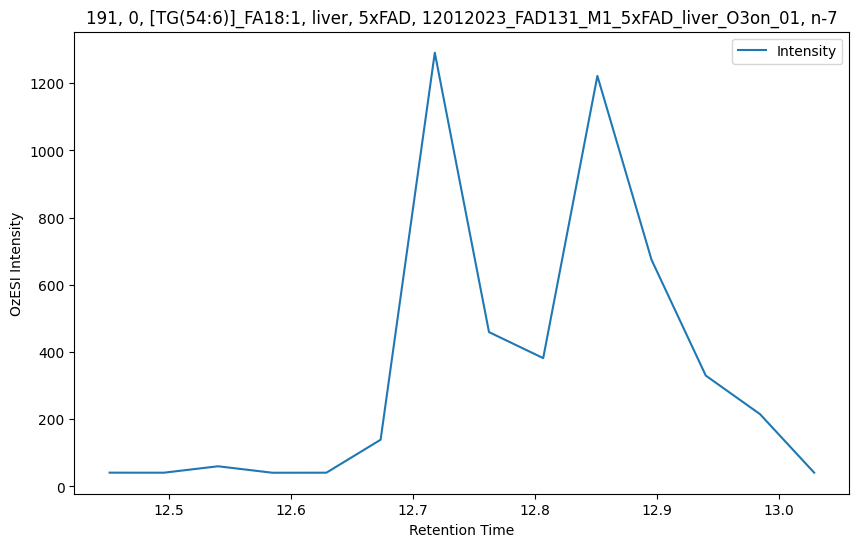

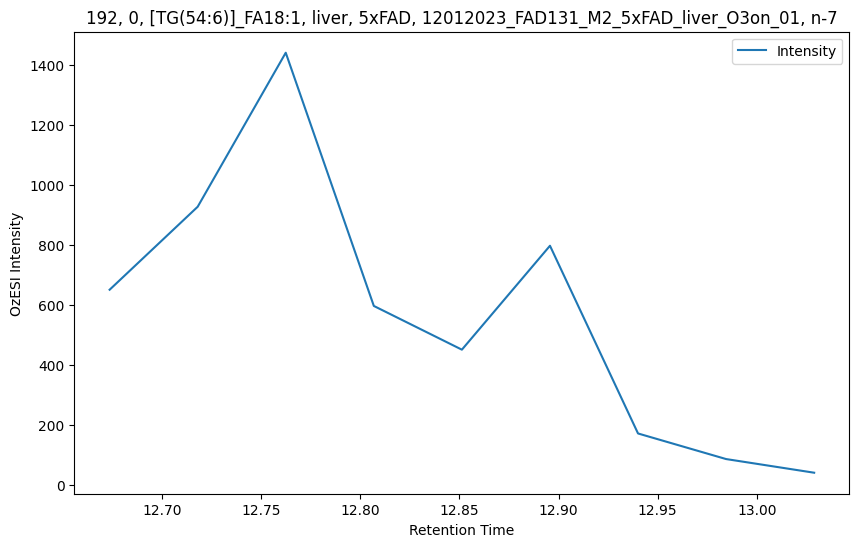

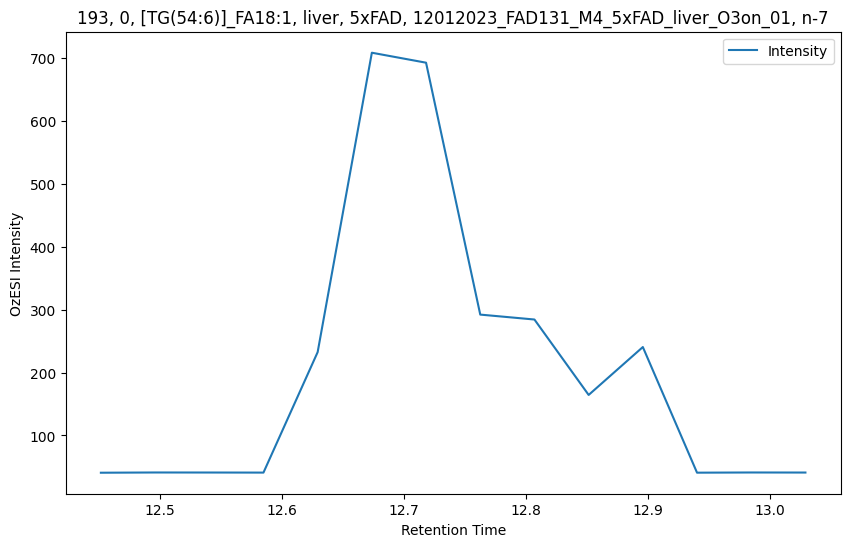

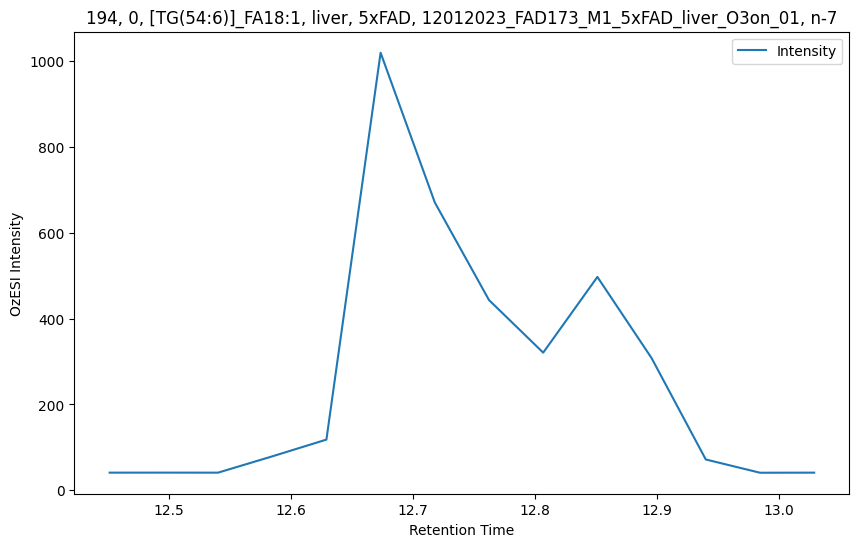

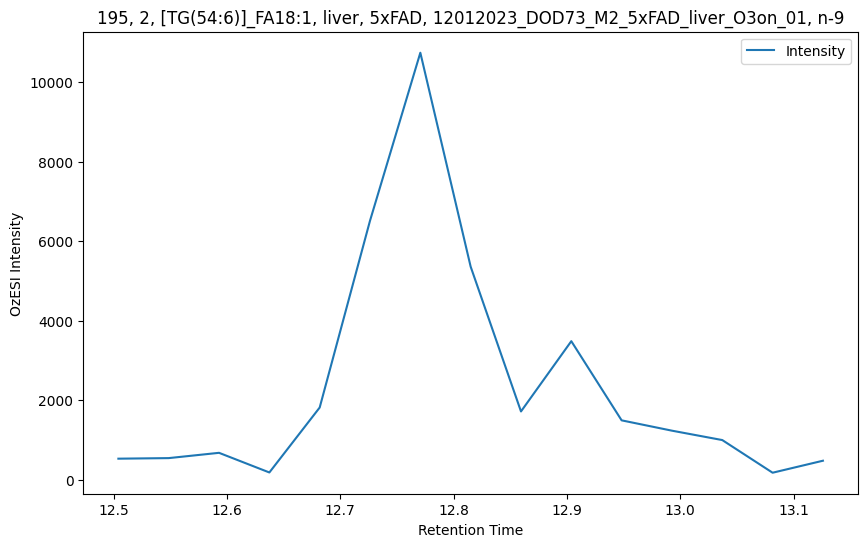

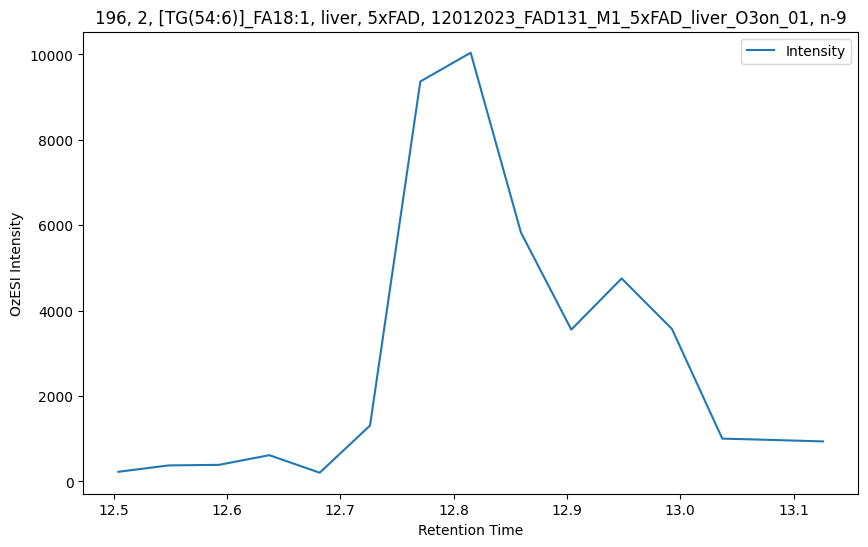

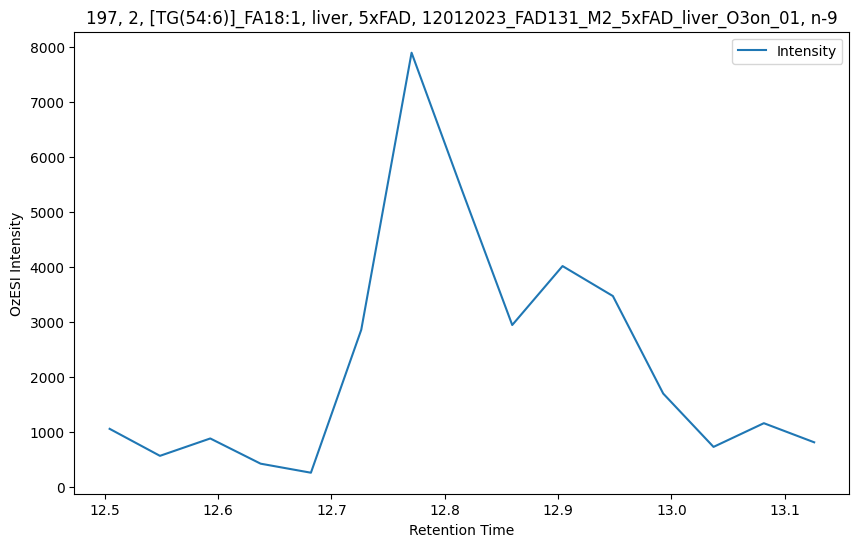

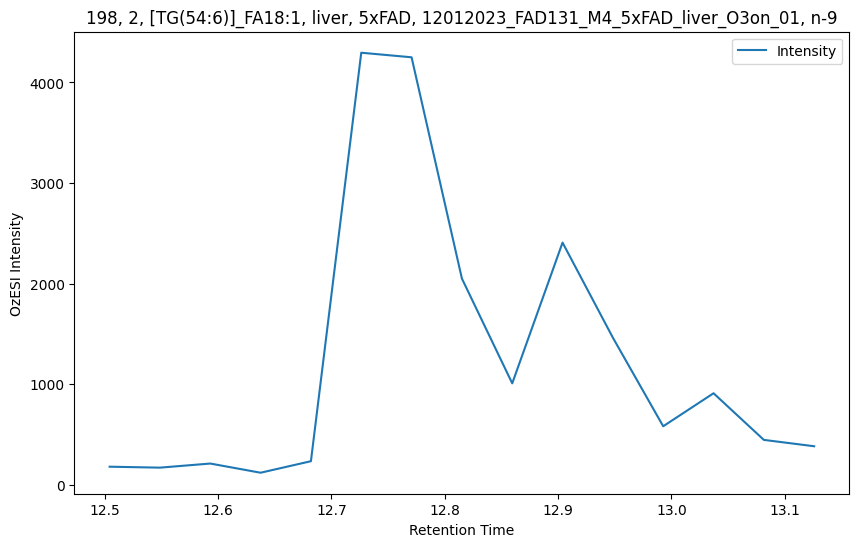

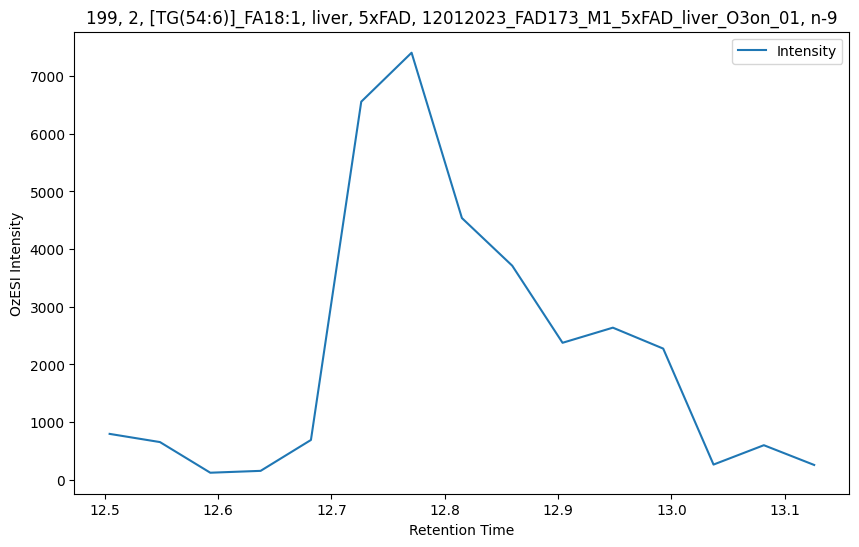

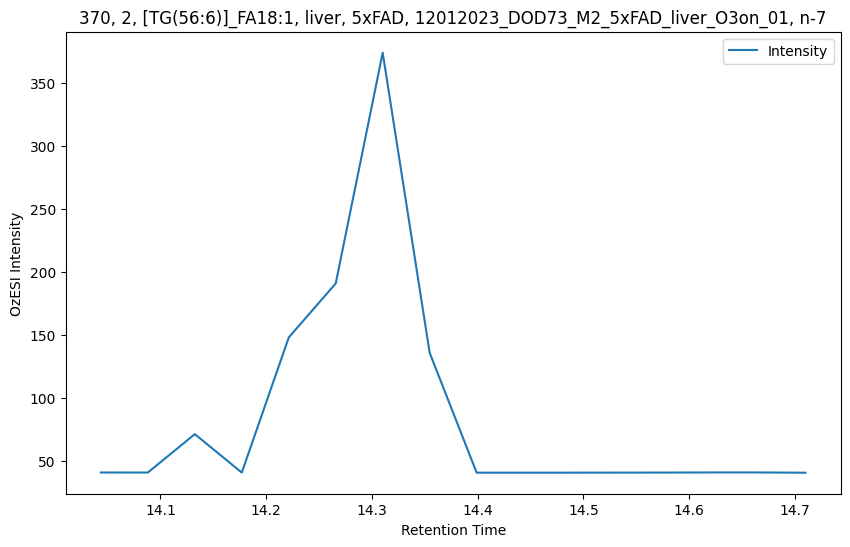

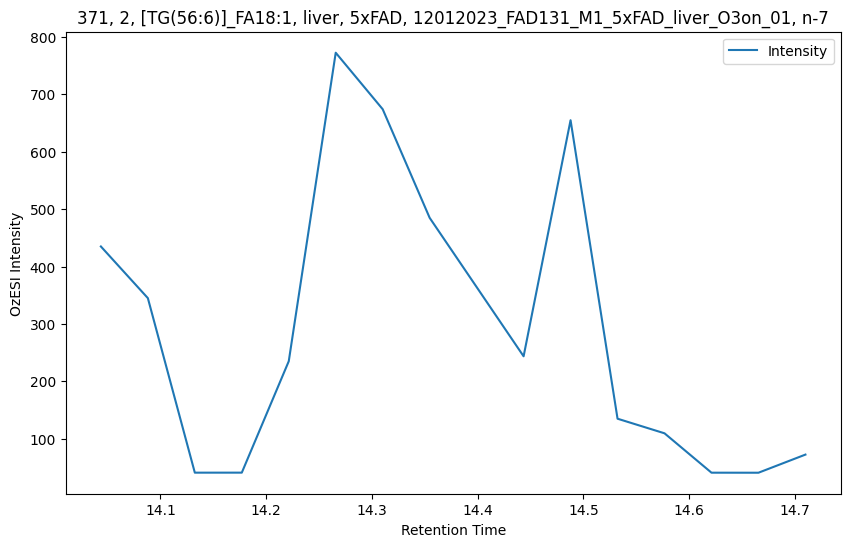

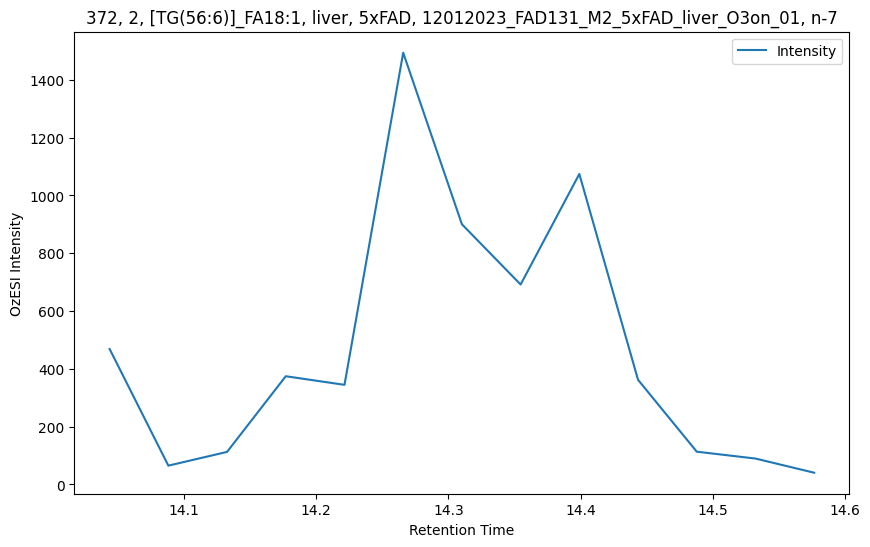

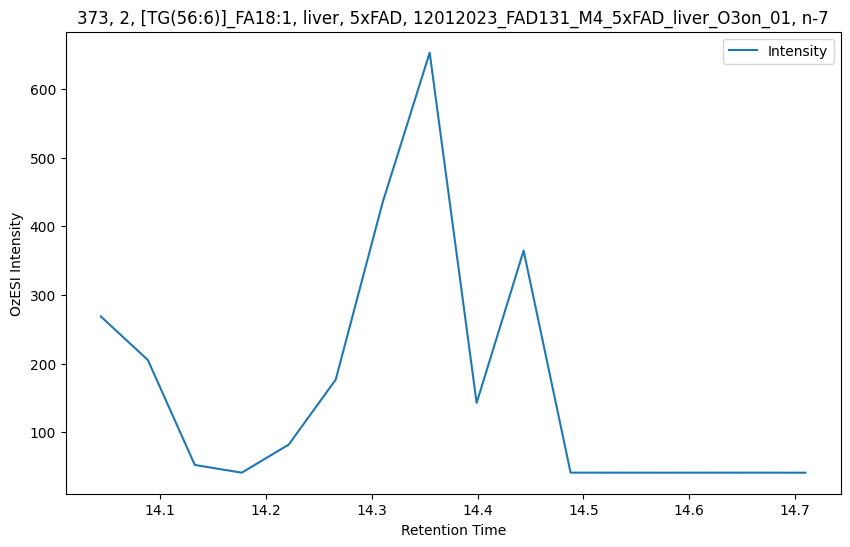

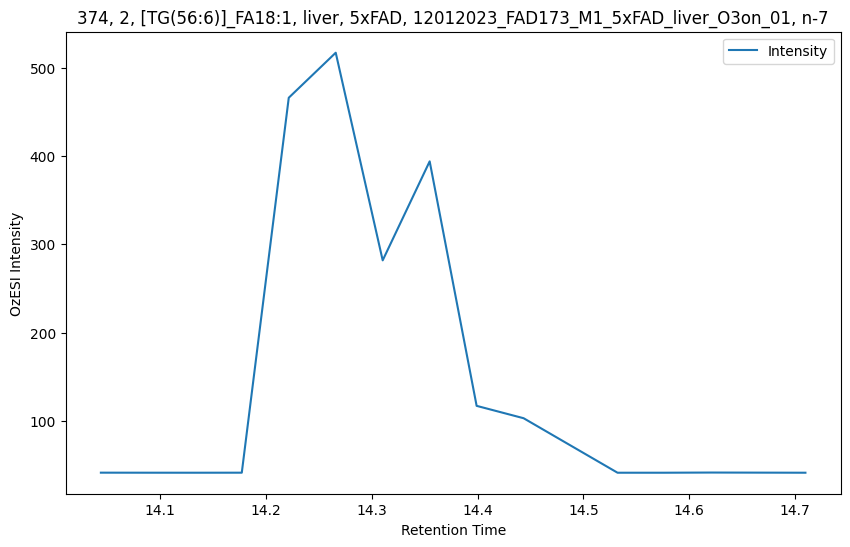

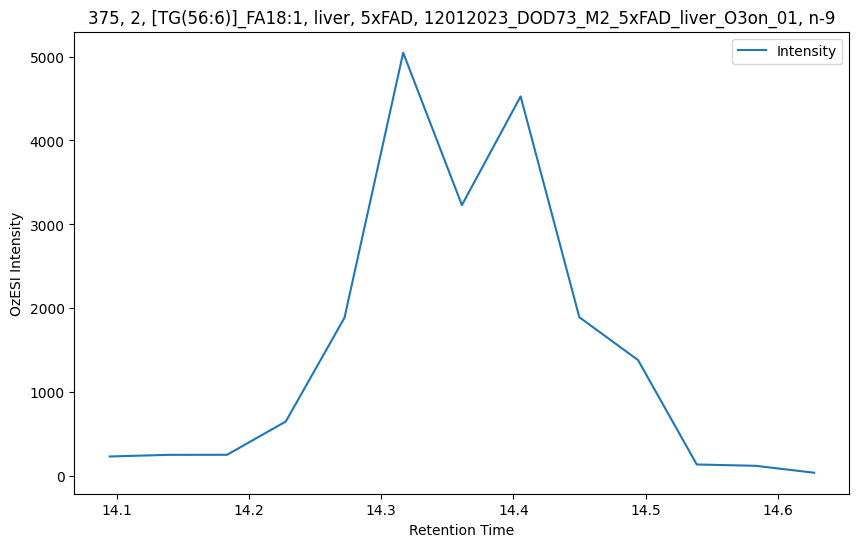

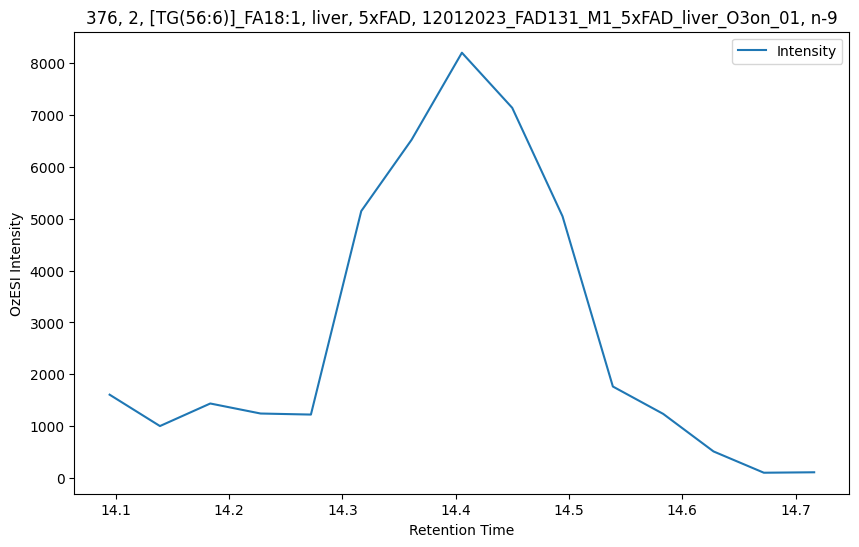

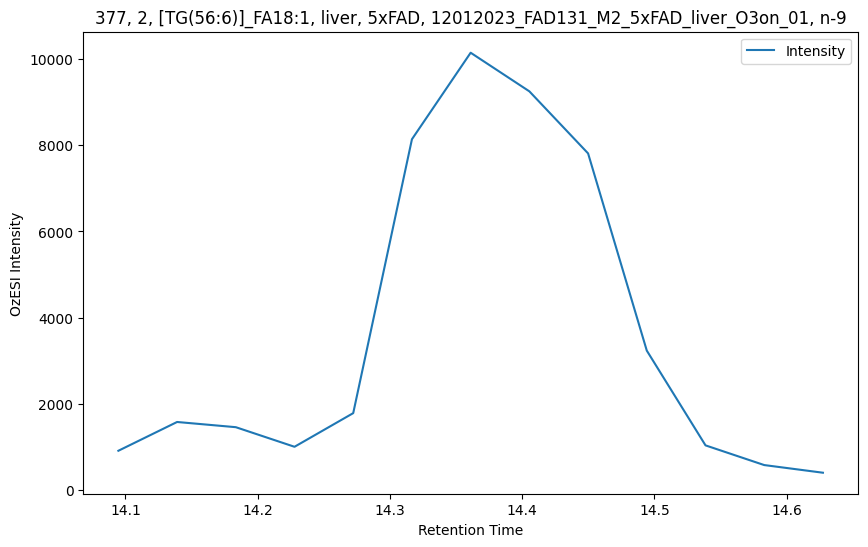

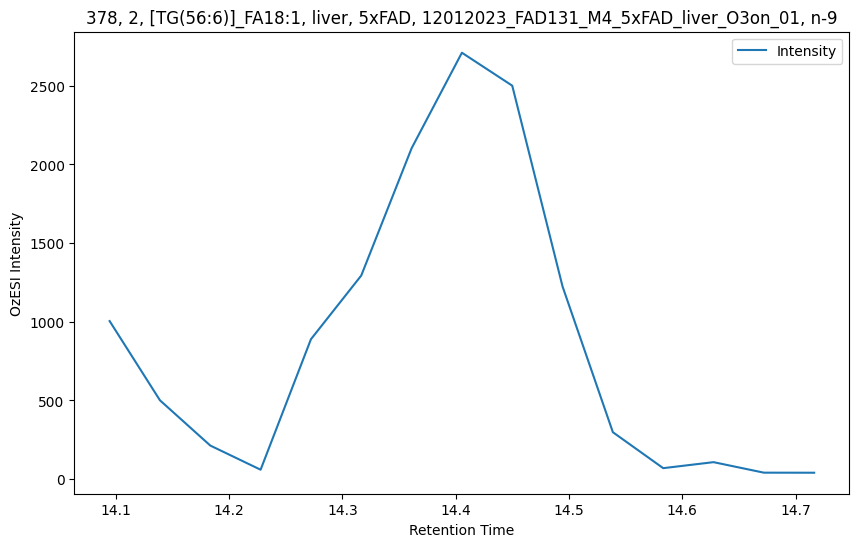

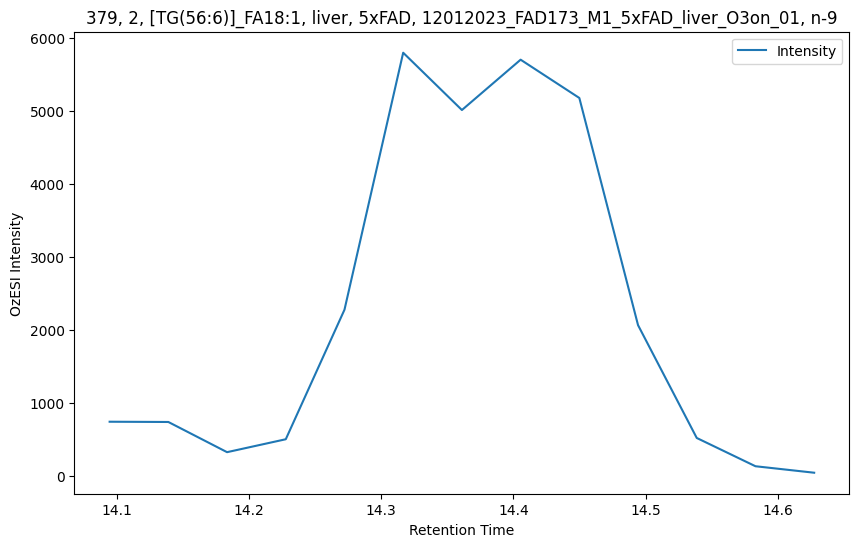

In [68]:
# def plot_data(group_data, group, cluster_label, save_dir):
#     if group_data.empty:
#         print(f"No data available for Group {group}, Cluster {cluster_label}. Skipping plot.")
#         return

#     # Extracting data for plotting
#     times = group_data['Retention_Time'].values
#     intensities = group_data['OzESI_Intensity'].values

#     # Extract additional information for the title
#     lipid = group_data.iloc[0]['Lipid']
#     biology = group_data.iloc[0]['Biology']
#     genotype = group_data.iloc[0]['Genotype']
#     db = group_data.iloc[0]['db']
#     sample_id = group_data.iloc[0]['Sample_ID']

#     # Plotting
#     plt.figure(figsize=(10, 6))
#     plt.plot(times, intensities, label='Intensity')
#     plt.xlabel('Retention Time')
#     plt.ylabel('OzESI Intensity')
#     plt.title(f'{group}, {cluster_label}, {lipid}, {biology}, {genotype}, {sample_id}, {db}')
#     plt.legend()

#     # Save the plot
#     filename = f'{group}, {cluster_label}, {lipid}, {biology}, {genotype}, {sample_id}, {db}.png'
#     # plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
#     plt.show()
#     plt.close()

# # Define the directory to save the plots
# save_directory = 'Projects/FaceFats/plots/peak_check/manual/'  # Replace with your directory path

# # Plotting for each group-cluster pair in d14
# for (group, cluster_label), group_df in d14.groupby(['Group', 'Cluster_Label']):
#     plot_data(group_df, group, cluster_label, save_directory)


# Calculate Area of peak

In [80]:
d15 = d14.copy()  # Creating d15 DataFrame from the newly filtered d10



# Create an empty DataFrame for storing the calculated areas
area_results = pd.DataFrame(columns=['Group', 'Cluster_Label', 'Area'])

# Group by 'Group' and 'Cluster_Label'
grouped_data = d15.groupby(['Group', 'Cluster_Label'])

# Iterate over each group and calculate the area
for (group, cluster_label), group_data in grouped_data:
    # Sort the group data by 'Retention_Time'
    sorted_group_data = group_data.sort_values(by='Retention_Time')

    # Extract 'Retention_Time' and 'OzESI_Intensity'
    retention_time = sorted_group_data['Retention_Time']
    intensity = sorted_group_data['OzESI_Intensity']

    # Calculate the area using the trapezoidal rule
    area = trapz(intensity, retention_time)

    # Append the results to the area_results DataFrame
    area_results = area_results.append({
        'Group': group, 
        'Cluster_Label': cluster_label, 
        'Area': area
    }, ignore_index=True)

# Merge the calculated areas back into the original DataFrame
d15 = pd.merge(d15, area_results, on=['Group', 'Cluster_Label'])

# Round the 'Area' to 0 decimal places
d15['Area'] = d15['Area'].round(0)
d15


Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0          718.6        599.5       12.340100       228.080017   
1          718.6        599.5       12.384517       156.900009   
2          718.6        599.5       12.428917       107.180008   
3          718.6        599.5       12.473317       126.040009   
4          718.6        599.5       12.517733        41.000004   
...          ...          ...             ...              ...   
1071       814.7        625.5       14.449917      5175.280273   
1072       814.7        625.5       14.494317      2062.900146   
1073       814.7        625.5       14.538717       517.380066   
1074       814.7        625.5       14.583133       129.980011   
1075       814.7        625.5       14.627533        41.220001   

                                   Sample_ID      Transition    db  \
0      12012023_DOD73_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
1      12012023_DOD73_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
2      12012023_DOD73_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
3      12012023_DOD73_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
4      12012023_DOD73_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
...                                      ...             ...   ...   
1071  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1072  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1073  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1074  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1075  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   

                  Lipid  Cluster_Label Biology Genotype     FAC        TG  \
0     [TG(52:5)]_FA16:1              0   liver    5xFAD  FA16:1  TG(52:5)   
1     [TG(52:5)]_FA16:1              0   liver    5xFAD  FA16:1  TG(52:5)   
2     [TG(52:5)]_FA16:1              0   liver    5xFAD  FA16:1  TG(52:5)   
3     [TG(52:5)]_FA16:1              0   liver    5xFAD  FA16:1  TG(52:5)   
4     [TG(52:5)]_FA16:1              0   liver    5xFAD  FA16:1  TG(52:5)   
...                 ...            ...     ...      ...     ...       ...   
1071  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1072  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1073  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1074  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   
1075  [TG(56:6)]_FA18:1              2   liver    5xFAD  FA18:1  TG(56:6)   

      Group  Max_Intensity  Cluster_RT  distance_to_truth  RT_Start  RT_End  \
0        45          314.0       11.67           0.409900     12.34   13.01   
1        45          314.0       11.67           0.365483     12.34   13.01   
2        45          314.0       11.67           0.321083     12.34   13.01   
3        45          314.0       11.67           0.276683     12.34   13.01   
4        45          314.0       11.67           0.232267     12.34   13.01   
...     ...            ...         ...                ...       ...     ...   
1071    379         5795.0       14.09           0.019917     14.09   14.63   
1072    379         5795.0       14.09           0.064317     14.09   14.63   
1073    379         5795.0       14.09           0.108717     14.09   14.63   
1074    379         5795.0       14.09           0.153133     14.09   14.63   
1075    379         5795.0       14.09           0.197533     14.09   14.63   

        Area  
0       62.0  
1       62.0  
2       62.0  
3       62.0  
4       62.0  
...      ...  
1071  1271.0  
1072  1271.0  
1073  1271.0  
1074  1271.0  
1075  1271.0  

[1076 rows x 20 columns]

# Data Dependent Threshold (List of intensities)

In [81]:
d17 = d15.copy()

# Group the data by 'Group' and collect the 'OzESI_Intensity' values in lists
grouped_data = d17.groupby('Group')['OzESI_Intensity'].apply(list).reset_index(name='Group_Intensity')
# Merge the original data with the grouped data
d17 = d17.merge(grouped_data, on='Group')


# Sorting the lists in the 'Group_Intensity' column
d17['Group_Intensity'] = d17['Group_Intensity'].apply(lambda x: sorted(x))

d17  # Display the first few rows of the merged DataFrame



def set_threshold(group_intensity_list, threshold1=0.3, threshold2=0):
    """
    Function to set a threshold at a specified level of the list and add an additional value to it.

    :param group_intensity_list: List of intensity values for a group.
    :param threshold1: The percentage level at which to set the threshold (default is 0.3 for 30%).
    :param threshold2: An additional value to add to the threshold (default is 0).
    :return: The threshold value.
    """
    if not group_intensity_list:
        return None
    sorted_list = sorted(group_intensity_list)
    index = int(len(sorted_list) * threshold1)
    return sorted_list[index] + threshold2

# Example usage
# Assuming df_merged is your DataFrame with the 'Group_Intensity' column
d17['Group_Threshold'] = d17['Group_Intensity'].apply(lambda x: set_threshold(x, threshold1=0.15, threshold2=100))
#round the threshold to 0 decimal places
d17['Group_Threshold'] = d17['Group_Threshold'].round(0)


# To display the first few rows of the DataFrame with the new column
d17

# Filter the DataFrame to keep only the rows where 'OzESI_Intensity' is greater than or equal to 'Group_Threshold'
d18 = d17[d17['OzESI_Intensity'] >= d17['Group_Threshold']]

# Display the first few rows of the filtered DataFrame
d18




Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0          718.6        599.5       12.340100       228.080017   
1          718.6        599.5       12.384517       156.900009   
13         718.6        599.5       12.917400       143.960007   
14         718.6        599.5       12.961800       314.400024   
16         718.6        599.5       12.340117       383.760040   
...          ...          ...             ...              ...   
1069       814.7        625.5       14.361100      5010.260254   
1070       814.7        625.5       14.405500      5699.980469   
1071       814.7        625.5       14.449917      5175.280273   
1072       814.7        625.5       14.494317      2062.900146   
1073       814.7        625.5       14.538717       517.380066   

                                   Sample_ID      Transition    db  \
0      12012023_DOD73_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
1      12012023_DOD73_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
13     12012023_DOD73_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
14     12012023_DOD73_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
16    12012023_FAD131_M4_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
...                                      ...             ...   ...   
1069  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1070  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1071  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1072  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
1073  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   

                  Lipid  Cluster_Label Biology  ...        TG Group  \
0     [TG(52:5)]_FA16:1              0   liver  ...  TG(52:5)    45   
1     [TG(52:5)]_FA16:1              0   liver  ...  TG(52:5)    45   
13    [TG(52:5)]_FA16:1              0   liver  ...  TG(52:5)    45   
14    [TG(52:5)]_FA16:1              0   liver  ...  TG(52:5)    45   
16    [TG(52:5)]_FA16:1              0   liver  ...  TG(52:5)    48   
...                 ...            ...     ...  ...       ...   ...   
1069  [TG(56:6)]_FA18:1              2   liver  ...  TG(56:6)   379   
1070  [TG(56:6)]_FA18:1              2   liver  ...  TG(56:6)   379   
1071  [TG(56:6)]_FA18:1              2   liver  ...  TG(56:6)   379   
1072  [TG(56:6)]_FA18:1              2   liver  ...  TG(56:6)   379   
1073  [TG(56:6)]_FA18:1              2   liver  ...  TG(56:6)   379   

     Max_Intensity  Cluster_RT  distance_to_truth  RT_Start  RT_End    Area  \
0            314.0       11.67           0.409900     12.34   13.01    62.0   
1            314.0       11.67           0.365483     12.34   13.01    62.0   
13           314.0       11.67           0.167400     12.34   13.01    62.0   
14           314.0       11.67           0.211800     12.34   13.01    62.0   
16           384.0       12.34           0.409883     12.34   13.01    51.0   
...            ...         ...                ...       ...     ...     ...   
1069        5795.0       14.09           0.068900     14.09   14.63  1271.0   
1070        5795.0       14.09           0.024500     14.09   14.63  1271.0   
1071        5795.0       14.09           0.019917     14.09   14.63  1271.0   
1072        5795.0       14.09           0.064317     14.09   14.63  1271.0   
1073        5795.0       14.09           0.108717     14.09   14.63  1271.0   

                                        Group_Intensity  Group_Threshold  
0     [40.96000289916992, 41.000003814697266, 41.000...            141.0  
1     [40.96000289916992, 41.000003814697266, 41.000...            141.0  
13    [40.96000289916992, 41.000003814697266, 41.000...            141.0  
14    [40.96000289916992, 41.000003814697266, 41.000...            141.0  
16    [40.76000213623047, 40.80000305175781, 40.8400...            141.0  
...                                                 ...              ...  
1069  [41.220001220703125, 129.98001098632812

# DDT Area Calculations 

In [82]:


# Assuming d5e is your original DataFrame
d19 = d18.copy()

# Create an empty DataFrame for storing the calculated areas
area_results_ddt = pd.DataFrame(columns=['Group', 'Cluster_Label', 'Area_DDT'])

# Group by 'Group' and 'Cluster_Label'
grouped_data_ddt = d19.groupby(['Group', 'Cluster_Label'])

# Iterate over each group and calculate the area
for (group, cluster_label), group_data in grouped_data_ddt:
    # Sort the group data by 'Retention_Time'
    sorted_group_data = group_data.sort_values(by='Retention_Time')

    # Extract 'Retention_Time' and 'OzESI_Intensity'
    retention_time = sorted_group_data['Retention_Time']
    intensity = sorted_group_data['OzESI_Intensity']

    # Calculate the area using the trapezoidal rule
    area = trapz(intensity, retention_time)

    # Append the results to the area_results_ddt DataFrame
    area_results_ddt = area_results_ddt.append({
        'Group': group, 
        'Cluster_Label': cluster_label, 
        'Area_DDT': area
    }, ignore_index=True)

# ... [previous code for calculating areas and appending to area_results_ddt] ...

# Merge the calculated areas back into the original DataFrame
d19 = pd.merge(d19, area_results_ddt, on=['Group', 'Cluster_Label'], how='left')

# Check if 'Area_DDT' is in d19 after merging
if 'Area_DDT' in d19.columns:
    # Round the 'Area_DDT' to 0 decimal places
    d19['Area_DDT'] = d19['Area_DDT'].round(0)
else:
    print("Area_DDT column not found in d19 after merging.")

# Display the DataFrame
d19






Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0         718.6        599.5       12.340100       228.080017   
1         718.6        599.5       12.384517       156.900009   
2         718.6        599.5       12.917400       143.960007   
3         718.6        599.5       12.961800       314.400024   
4         718.6        599.5       12.340117       383.760040   
..          ...          ...             ...              ...   
643       814.7        625.5       14.361100      5010.260254   
644       814.7        625.5       14.405500      5699.980469   
645       814.7        625.5       14.449917      5175.280273   
646       814.7        625.5       14.494317      2062.900146   
647       814.7        625.5       14.538717       517.380066   

                                  Sample_ID      Transition    db  \
0     12012023_DOD73_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
1     12012023_DOD73_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
2     12012023_DOD73_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
3     12012023_DOD73_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
4    12012023_FAD131_M4_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
..                                      ...             ...   ...   
643  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
644  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
645  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
646  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
647  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   

                 Lipid  Cluster_Label Biology  ... Group Max_Intensity  \
0    [TG(52:5)]_FA16:1              0   liver  ...    45         314.0   
1    [TG(52:5)]_FA16:1              0   liver  ...    45         314.0   
2    [TG(52:5)]_FA16:1              0   liver  ...    45         314.0   
3    [TG(52:5)]_FA16:1              0   liver  ...    45         314.0   
4    [TG(52:5)]_FA16:1              0   liver  ...    48         384.0   
..                 ...            ...     ...  ...   ...           ...   
643  [TG(56:6)]_FA18:1              2   liver  ...   379        5795.0   
644  [TG(56:6)]_FA18:1              2   liver  ...   379        5795.0   
645  [TG(56:6)]_FA18:1              2   liver  ...   379        5795.0   
646  [TG(56:6)]_FA18:1              2   liver  ...   379        5795.0   
647  [TG(56:6)]_FA18:1              2   liver  ...   379        5795.0   

    Cluster_RT  distance_to_truth  RT_Start  RT_End    Area  \
0        11.67           0.409900     12.34   13.01    62.0   
1        11.67           0.365483     12.34   13.01    62.0   
2        11.67           0.167400     12.34   13.01    62.0   
3        11.67           0.211800     12.34   13.01    62.0   
4        12.34           0.409883     12.34   13.01    51.0   
..         ...                ...       ...     ...     ...   
643      14.09           0.068900     14.09   14.63  1271.0   
644      14.09           0.024500     14.09   14.63  1271.0   
645      14.09           0.019917     14.09   14.63  1271.0   
646      14.09           0.064317     14.09   14.63  1271.0   
647      14.09           0.108717     14.09   14.63  1271.0   

                                       Group_Intensity  Group_Threshold  \
0    [40.96000289916992, 41.000003814697266, 41.000...            141.0   
1    [40.96000289916992, 41.000003814697266, 41.000...            141.0   
2    [40.96000289916992, 41.000003814697266, 41.000...            141.0   
3    [40.96000289916992, 41.000003814697266, 41.000...            141.0   
4    [40.76000213623047, 40.80000305175781, 40.8400...            141.0   
..                                                 ...              ...   
643  [41.220001220703125, 129.98001098632812, 322.7...            230.0   
644  [41.220001220703125, 129.98001098632812, 322.7...            230.0   
645  [41.220001220703125, 129.98001098632812, 322.7...            230.0   

In [83]:

d21 = d19.copy()
# Assuming d5 is your DataFrame
# First, find the row in each group with the max OzESI_Intensity
max_intensity_rows = d21.loc[d21.groupby(['Lipid', 'Sample_ID', 'db'])['OzESI_Intensity'].idxmax()]

# Create a new DataFrame with the necessary columns
max_rt_df = max_intensity_rows[['Lipid', 'Sample_ID', 'db', 'Retention_Time']]

# Rename the 'Retention_Time' column to 'Cluster_RT'
max_rt_df.rename(columns={'Retention_Time': 'Cluster_RT'}, inplace=True)
#round the retention time to 2 decimal places
max_rt_df['Cluster_RT'] = max_rt_df['Cluster_RT'].round(2)

# Merge this back with the original d21 DataFrame
# This adds the 'Cluster_RT' column to d21, aligning each row with its corresponding retention time for the max intensity
d21 = pd.merge(d21, max_rt_df, on=['Lipid', 'Sample_ID', 'db'])

# Now d21 will have an additional column 'Cluster_RT' which is the retention time for the max intensity for each Lipid-Cluster for each Sample_ID
d21



/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/pandas/core/frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":


Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0         718.6        599.5       12.340100       228.080017   
1         718.6        599.5       12.384517       156.900009   
2         718.6        599.5       12.917400       143.960007   
3         718.6        599.5       12.961800       314.400024   
4         718.6        599.5       12.340117       383.760040   
..          ...          ...             ...              ...   
643       814.7        625.5       14.361100      5010.260254   
644       814.7        625.5       14.405500      5699.980469   
645       814.7        625.5       14.449917      5175.280273   
646       814.7        625.5       14.494317      2062.900146   
647       814.7        625.5       14.538717       517.380066   

                                  Sample_ID      Transition    db  \
0     12012023_DOD73_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
1     12012023_DOD73_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
2     12012023_DOD73_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
3     12012023_DOD73_M2_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
4    12012023_FAD131_M4_5xFAD_liver_O3on_01  718.6 -> 599.5  n-12   
..                                      ...             ...   ...   
643  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
644  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
645  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
646  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   
647  12012023_FAD173_M1_5xFAD_liver_O3on_01  814.7 -> 625.5   n-9   

                 Lipid  Cluster_Label Biology  ... Max_Intensity Cluster_RT_x  \
0    [TG(52:5)]_FA16:1              0   liver  ...         314.0        11.67   
1    [TG(52:5)]_FA16:1              0   liver  ...         314.0        11.67   
2    [TG(52:5)]_FA16:1              0   liver  ...         314.0        11.67   
3    [TG(52:5)]_FA16:1              0   liver  ...         314.0        11.67   
4    [TG(52:5)]_FA16:1              0   liver  ...         384.0        12.34   
..                 ...            ...     ...  ...           ...          ...   
643  [TG(56:6)]_FA18:1              2   liver  ...        5795.0        14.09   
644  [TG(56:6)]_FA18:1              2   liver  ...        5795.0        14.09   
645  [TG(56:6)]_FA18:1              2   liver  ...        5795.0        14.09   
646  [TG(56:6)]_FA18:1              2   liver  ...        5795.0        14.09   
647  [TG(56:6)]_FA18:1              2   liver  ...        5795.0        14.09   

    distance_to_truth  RT_Start  RT_End    Area  \
0            0.409900     12.34   13.01    62.0   
1            0.365483     12.34   13.01    62.0   
2            0.167400     12.34   13.01    62.0   
3            0.211800     12.34   13.01    62.0   
4            0.409883     12.34   13.01    51.0   
..                ...       ...     ...     ...   
643          0.068900     14.09   14.63  1271.0   
644          0.024500     14.09   14.63  1271.0   
645          0.019917     14.09   14.63  1271.0   
646          0.064317     14.09   14.63  1271.0   
647          0.108717     14.09   14.63  1271.0   

                                       Group_Intensity  Group_Threshold  \
0    [40.96000289916992, 41.000003814697266, 41.000...            141.0   
1    [40.96000289916992, 41.000003814697266, 41.000...            141.0   
2    [40.96000289916992, 41.000003814697266, 41.000...            141.0   
3    [40.96000289916992, 41.000003814697266, 41.000...            141.0   
4    [40.76000213623047, 40.80000305175781, 40.8400...            141.0   
..                                                 ...              ...   
643  [41.220001220703125, 129.98001098632812, 322.7...            230.0   
644  [41.220001220703125, 129.98001098632812, 322.7...            230.0   
645  [41.220001220703125, 129.98001098632812, 322.7...            230.0   
646  [41.220001220703125, 129.98001098632812, 322.7...     

# Remove clusters not being used

In [84]:
#based on sample_ID Lipid and db pos, keep the unique value with the highest intensity
# Sort the DataFrame by 'OzESI_Intensity' in descending order to ensure the highest intensity is first

d23 = d21.copy()
# Assuming your DataFrame is named d23
d23 = d23[d23['db'] != '']
d23




#sort d23 by max OzESI_Intensity
d23 = d23.sort_values(by='OzESI_Intensity', ascending=False)

d23 = d23.groupby(['Lipid', 'Sample_ID', 'db']).first().reset_index()



#round the retention time to 2 decimal places
d23['Retention_Time'] = d23['Retention_Time'].round(2)
#round intensity to 0 decimal places
d23['OzESI_Intensity'] = d23['OzESI_Intensity'].round(0)

# d23

Calculate Area Ratio

In [85]:
d24 = d23.copy

# Filter for 'n-9' and 'n-7' in the 'db' column
filtered_df = d23[d23['db'].isin(['n-9', 'n-7'])]

# Group by 'Lipid' and 'Sample_ID'
grouped = filtered_df.groupby(['Lipid', 'Sample_ID'])

# DataFrame for Area Ratios
area_ratios = pd.DataFrame(columns=['Lipid', 'Sample_ID', 'Area_Ratio'])

# Calculate Area Ratio for each group
for (lipid, sample_id), group in grouped:
    n9_area = group[group['db'] == 'n-9']['Area_DDT'].sum()  # Sum if there are multiple 'n-9' entries
    n7_area = group[group['db'] == 'n-7']['Area_DDT'].sum()  # Sum if there are multiple 'n-7' entries
    ratio = round(n9_area / n7_area, 2) if n7_area != 0 else None

    # Append to DataFrame
    area_ratios = area_ratios.append({
        'Lipid': lipid,
        'Sample_ID': sample_id,
        'Area_Ratio': ratio
    }, ignore_index=True)

# Merge the Area Ratio DataFrame with the original DataFrame
d24 = pd.merge(d23, area_ratios, on=['Lipid', 'Sample_ID'], how='left')

d24.head(50)  # Display the updated DataFrame with 'Area_Ratio'


# Save df to results

In [ ]:
d24_save_directory = 'Projects/FaceFats/results/'
d24.to_csv(os.path.join(d24_save_directory, 'LiverOzON_01Jan24.csv'), index=False)
d24

# calculte area Ratio for one

In [86]:



# # Assume d6 is your original DataFrame

# # Filter for 'n-9' and 'n-7' in the 'db' column
# filtered_df = d6[d6['db'].isin(['n-9', 'n-7'])]

# # Group by 'Lipid' and 'Sample_ID'
# grouped = filtered_df.groupby(['Lipid', 'Sample_ID'])

# # Initialize Area_Ratio column in the original DataFrame
# d6['Area_Ratio_DDT'] = None

# # Calculate Area Ratio for each group and update the original DataFrame
# for (lipid, sample_id), group in grouped:
#     if 'n-9' in group['db'].values and 'n-7' in group['db'].values:
#         n9_area = group[group['db'] == 'n-9']['Area_DDT'].sum()
#         n7_area = group[group['db'] == 'n-7']['Area_DDT'].sum()
#         ratio = round(n9_area / n7_area, 2) if n7_area != 0 else None

#         # Update only relevant rows in the original DataFrame
#         indices = d6[(d6['Lipid'] == lipid) & (d6['Sample_ID'] == sample_id) & (d6['db'].isin(['n-9', 'n-7']))].index
#         d6.loc[indices, 'Area_Ratio_DDT'] = ratio



# # Now d6 should have the correctly assigned Area_Ratio
# d6  # Display the updated DataFrame


# Calculate Area for all 4

In [87]:
# d24 = d23.copy()

# # Filter for 'n-9' and 'n-7' in the 'db' column
# filtered_df = d24[d24['db'].isin(['n-9', 'n-7'])]

# # Group by 'Lipid' and 'Sample_ID'
# grouped = filtered_df.groupby(['Lipid', 'Sample_ID'])

# # Initialize the Ratio columns in the original DataFrame
# d24['Area_Ratio'] = None
# d24['Area_DDT_Ratio'] = None


# # Calculate Ratios for each group and update the original DataFrame
# for (lipid, sample_id), group in grouped:
#     if 'n-9' in group['db'].values and 'n-7' in group['db'].values:
#         # Calculate Area Ratio
#         n9_area = group[group['db'] == 'n-9']['Area'].sum()
#         n7_area = group[group['db'] == 'n-7']['Area'].sum()
#         area_ratio = n9_area / n7_area if n7_area != 0 else None

#         # Calculate Area_DDT Ratio
#         n9_area_ddt = group[group['db'] == 'n-9']['Area_DDT'].sum()
#         n7_area_ddt = group[group['db'] == 'n-7']['Area_DDT'].sum()
#         area_ddt_ratio = n9_area_ddt / n7_area_ddt if n7_area_ddt != 0 else None


#         # Update the original DataFrame
#         indices = d24[(d24['Lipid'] == lipid) & (d24['Sample_ID'] == sample_id)].index
#         d24.loc[indices, 'Area_Ratio'] = area_ratio
#         d24.loc[indices, 'Area_DDT_Ratio'] = area_ddt_ratio


# # The d24 DataFrame now has the new columns for the calculated ratios
# # d24  # Display the first few rows of the updated DataFrame


In [92]:
d24_save_directory = 'Projects/FaceFats/results/'
d24.to_csv(os.path.join(d24_save_directory, 'LiverOzON_01Jan24.csv'), index=False)
d24

Lipid                               Sample_ID    db  \
0   [TG(50:3)]_FA18:1   12012023_DOD73_M2_5xFAD_liver_O3on_01  n-10   
1   [TG(50:3)]_FA18:1   12012023_DOD73_M2_5xFAD_liver_O3on_01   n-7   
2   [TG(50:3)]_FA18:1   12012023_DOD73_M2_5xFAD_liver_O3on_01   n-9   
3   [TG(50:3)]_FA18:1  12012023_FAD131_M1_5xFAD_liver_O3on_01  n-10   
4   [TG(50:3)]_FA18:1  12012023_FAD131_M1_5xFAD_liver_O3on_01   n-7   
..                ...                                     ...   ...   
60  [TG(56:6)]_FA18:1  12012023_FAD131_M2_5xFAD_liver_O3on_01   n-9   
61  [TG(56:6)]_FA18:1  12012023_FAD131_M4_5xFAD_liver_O3on_01   n-7   
62  [TG(56:6)]_FA18:1  12012023_FAD131_M4_5xFAD_liver_O3on_01   n-9   
63  [TG(56:6)]_FA18:1  12012023_FAD173_M1_5xFAD_liver_O3on_01   n-7   
64  [TG(56:6)]_FA18:1  12012023_FAD173_M1_5xFAD_liver_O3on_01   n-9   

    Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity      Transition  \
0        722.7        547.5           13.94            354.0  722.7 -> 547.5   
1        764.7        547.5           13.89           1214.0  764.7 -> 547.5   
2        736.7        547.5           13.94          13197.0  736.7 -> 547.5   
3        722.7        547.5           14.03            472.0  722.7 -> 547.5   
4        764.7        547.5           13.93           2417.0  764.7 -> 547.5   
..         ...          ...             ...              ...             ...   
60       814.7        625.5           14.36          10139.0  814.7 -> 625.5   
61       842.7        625.5           14.35            653.0  842.7 -> 625.5   
62       814.7        625.5           14.41           2710.0  814.7 -> 625.5   
63       842.7        625.5           14.27            517.0  842.7 -> 625.5   
64       814.7        625.5           14.32           5795.0  814.7 -> 625.5   

    Cluster_Label Biology  ... distance_to_truth RT_Start RT_End    Area  \
0               2   liver  ...          0.061550    13.70  14.05    43.0   
1               2   liver  ...          0.112733    13.62  14.29   233.0   
2               0   liver  ...          0.062733    13.63  14.29  2494.0   
3               2   liver  ...          0.027283    13.88  14.29    54.0   
4               2   liver  ...          0.068317    13.62  14.29   588.0   
..            ...     ...  ...               ...      ...    ...     ...   
60              2   liver  ...          0.068917    14.09  14.67  2074.0   
61              2   liver  ...          0.075383    14.04  14.71   112.0   
62              2   liver  ...          0.024517    14.09  14.76   557.0   
63              2   liver  ...          0.164183    14.04  14.71   101.0   
64              2   liver  ...          0.113317    14.09  14.63  1271.0   

                                      Group_Intensity  Group_Threshold  \
0   [40.880001068115234, 40.880001068115234, 40.90...            141.0   
1   [40.60000228881836, 41.000003814697266, 41.040...            141.0   
2   [297.4000244140625, 585.820068359375, 689.4600...            789.0   
3   [40.68000411987305, 40.76000213623047, 40.7800...            141.0   
4   [40.62000274658203, 40.76000213623047, 40.8400...            141.0   
..                                                ...              ...   
60  [409.10003662109375, 586.56005859375, 917.9600...            687.0   
61  [41.060001373291016, 41.10000228881836, 41.140...            141.0   
62  [40.820003509521484, 41.18000411987305, 59.940...            160.0   
63  [41.20000457763672, 41.20000457763672, 41.2000...            141.0   
64  [41.220001220703125, 129.98001098632812, 322.7...            230.0   

    Area_DDT  Cluster_RT_y  Area_Ratio  Area_DDT_Ratio  
0       19.0         13.94   10.703863       10.414847  
1      229.0         13.89   10.703863       10.414847  
2     2385.0         13.94   10.703863       10.414847  
3       72.0         14.03    9.250000        9.165812  
4      585.0         13.93    9.250000        9.165812  
..       ...           ...         ...             ...  
6

# RT window to drop peaks?

In [89]:


# # Assuming d6 and df_db_pos are your DataFrames and user_window is the time window specified by the user
# user_window = 0.2  # Replace 0.5 with the value specified by the user

# # Copy d6 to d22
# d22 = d21.copy()

# # Iterate over each row in d22
# for index, row in d22.iterrows():
#     # Extract Lipid and Retention_Time from the row in d22
#     lipid = row['Lipid']
#     retention_time_d7 = row['Retention_Time']

#     # Find the corresponding row in df_db_pos
#     df_db_pos_row = df_db_pos[df_db_pos['Lipid'] == lipid]

#     # Check if the lipid was found in df_db_pos
#     if not df_db_pos_row.empty:
#         # Extract the Average_Retention_Time from df_db_pos
#         retention_time_db_pos = df_db_pos_row.iloc[0]['Retention_Time']

#         # Check if the retention time in d22 is outside the specified window
#         if abs(retention_time_d7 - retention_time_db_pos) > user_window:
#             # Remove the row from d22 if it is outside the window
#             d22.drop(index, inplace=True)

# # #show all TG(52:5)
# # d22[d22['Lipid'].str.contains('TG\(54:3\)')].head(60)


# # d22

# # # Filter for rows where 'Lipid' contains 'TG(52:5)' and FA16:1
# # filtered_rows = d22[(d22['Lipid'].str.contains('TG\(54:2\)')) ]

# # filtered_rows

Remove extra TG so can compare vs caitlin data

In [90]:

# # Make a copy of the DataFrame
# d23 = d22.copy()

# # # Function to remove the first TG if there are two TGs
# # def remove_first_tg(lipid):
# #     tg_parts = lipid.split(',')
# #     if len(tg_parts) > 1:
# #         return '[' + tg_parts[1]
# #     else:
# #         return lipid

# # # Apply the function to the Lipid column
# # d23['Lipid'] = d23['Lipid'].apply(remove_first_tg)


# # # Sorting by 'Purity' and then by 'Lipid'
# # d23 = d23.sort_values(by=['Purity', 'Lipid'])



# d23